![HouseMarketForecasting](img/PredicatePrice.jpg)


# <center>Прогнозирование стоимости жилья для агентства недвижимости</center>

## 1. Постановка задачи  

**Описание проекта**  
агентство недвижимости столкнулось с проблемой — риелторы тратят слишком много времени на сортировку объявлений и поиск выгодных предложений. Поэтому скорость их реакции и качество анализа не дотягивают до уровня конкурентов. Это сказывается на финансовых показателях агентства.

**Бизнес-задача**  
Разработать модель, которая позволила бы агентству недвижимости обойти конкурентов по скорости и качеству совершения сделок на продажу объектов недвижимости.  

**Основные цели проекта:**
1. Провести разведывательный анализ и очистку исходных данных. Обратить
внимание:
    - во многих признаках присутствуют дублирующиеся категории
    - ошибки ввода,жаргонные сокращения и т .д.
    - отыскать закономерности,
    -  расшифровать все сокращения
    -  найти синонимы в данных
    -   обработать пропуски и удалить выбросы.
2. Выделить наиболее значимые факторы, влияющие на стоимость
недвижимости.
3. Построить модель для прогнозирования стоимости недвижимости.
4. Разработать небольшой веб-сервис, на вход которому поступают данные
о некоторой выставленной на продажу недвижимости, а сервис
прогнозирует его стоимость.
___


## 2. Знакомство с данными

Описание признаков в датафрейме:

1. Целевой признак:
- 'target' — цена объекта недвижимости (признак, который необходимо спрогнозировать).

2. Признаки, связанные с адресом:
   - 'street' — адрес объекта;
   - 'city' — город;  
   - 'zipcode' — почтовый индекс;
   - 'state' — штат;
   - 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система
мультилистинга);

3. Внешняя характерстика объекта:
    - 'status' — статус продажи;  
    - 'propertyType' — тип объекта недвижимости;
    - 'homeFacts' — сведения о строительстве объекта (содержит несколько типов сведений, влияющих на оценку объекта);
    - 'schools' — сведения о школах в районе;
    - 'stories' — количество этажей;

4. Внутренняя характеристика объекта:
   - 'private pool' и 'PrivatePool' — наличие собственного бассейна;  
   - 'baths' — количество ванных комнат;
   - 'fireplace' — наличие камина;
   - 'sqft' — площадь в футах;
   - 'beds' — количество спален;

In [ ]:
# For Colab
# !pip install uszipcode xgboost optuna category_encoders

In [1]:
# # For Colab
# from google.colab import drive
# import sys

# CUR_PROJECT = '/content/drive/MyDrive/DS/Diplom/'
# DATA_DIR = '/content/drive/MyDrive/DS/Diplom/data/'

# drive.mount('/content/drive')
# sys.path.append(CUR_PROJECT)

# Local
DATA_DIR = 'data/'
PICKLE_DIR = 'web/app/model/'

In [2]:
import pandas as pd
import numpy as np
import json

import seaborn as sns
import matplotlib.pyplot as plt

# Утилиты
import re
# Проверка имени города и штата
from uszipcode import SearchEngine
# from geopy.geocoders import Nominatim
from tqdm import tqdm


from scipy.stats import boxcox, shapiro
from scipy.special import inv_boxcox
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
# from sklearn.preprocessing import ( MaxAbsScaler, Normalizer,
#                               QuantileTransformer,  FunctionTransformer,  minmax_scale)
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, chi2
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor


from xgboost import XGBRegressor
import optuna
import pickle

from importlib import reload
import set_of_function
my_lib = reload(set_of_function)

import warnings
warnings.filterwarnings('ignore')

sns.set(rc={'figure.figsize': (8, 6)})

In [3]:
# Verify for Colab
my_lib.rand_rgb()

(0.2319968249110923, 0.2119604630856613, 0.14916910026396468)

In [4]:
df = pd.read_csv('data/data.zip')
df.head(2)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"


In [5]:
print('Размер таблицы: ', df.shape)
df.info()

Размер таблицы:  (377185, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object

Промежуточный вывод:
- Число записей таблицы 377185
- большое кол-во пустых значений

## 3.Получение данных.

- Удалим полные дупликаты
- Анализ пропущенных значений

In [6]:
print(f'Число дубликатов: {df.duplicated().sum()}')
df.drop_duplicates(inplace=True)

Число дубликатов: 50


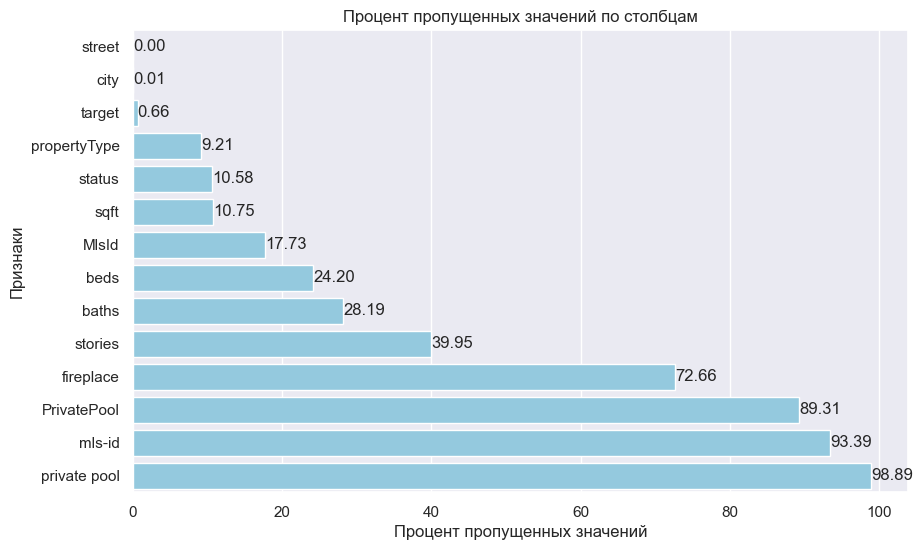

In [7]:
my_lib.visual_missing_data(df)

### 3.1. Признак: target

- Очистим данные у целевого признака с пустыми значениями, т.к. не сможем построить предсказание
- Преобразуем данные к числовому виду
- Построим распределение, проанализируем на аномальность данных


In [8]:
# Удалим данные целевого признака с пустыми значениями
df.dropna(subset=['target'], inplace=True)

Формат данных имеет вид:
- $365,000
- 155,000
- $1,215 - $1,437/mo
- $265,990+
- $10,500/mo

Удалим записи, оканчивающие на '/mo', эти данные относятся по аренде жилья,
что не соотвествует целям нашей задачи.
PS: пока не удаляем

- Добавим признак Arenda

In [9]:
# # Удаление строк, оканчивающихся на '/mo'
# df = df[~df['target'].str.endswith('/mo')]
# # Удаление символов "$", ",", "+" из столбца 'target' и преобразование в целые числа
# df['target'] = df['target'].str.replace(r'[\$\,\+]', '', regex=True).astype(int)
#-----------------------------

# Фильтрация строк, где целевой признак заканчивается на '/mo'
arenda_rows = df[df['target'].str.endswith('/mo')]

# Создание нового столбца 'Arenda' со значениями 1 для отфильтрованных строк
df['Arenda'] = 0
df.loc[arenda_rows.index, 'Arenda'] = 1

# Удаление символов "$", ",", "+", "/", "mo" из столбца 'target'
df['target'] = df['target'].str.replace(r'[\$\,+\+/mo]', '', regex=True)

# Замена строк, равных "1215 - 1437", на число "1300"
df['target'].replace("1215 - 1437", "1300", inplace=True)

# Преобразование в целые числа
df['target'] = df['target'].astype(int)

df['target'].sample(2)

8174     254999
50718    199900
Name: target, dtype: int32

Диапазон цен, min: $1, max: $195,000,000


<Axes: xlabel='target'>

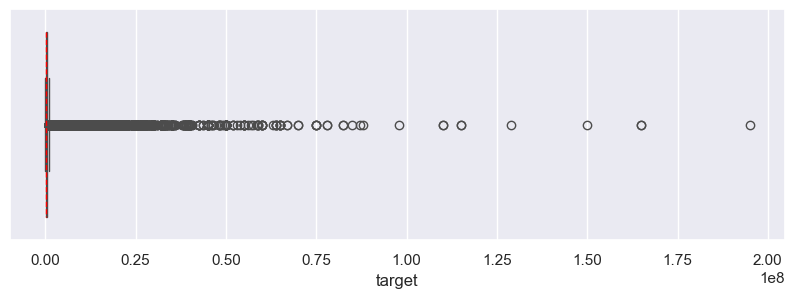

In [10]:
print(f'Диапазон цен, min: ${df.target.min()}, max: ${df.target.max():,}')
plt.figure(figsize=(10, 3))
sns.boxplot(x = df['target'], orient='h', medianprops={"color": "red", "linestyle": '--'})

Диапазон цен очень большой, применим фильтрацию методом IQR

In [12]:
mask = my_lib.IQR(df['target'])
df = df[mask].reset_index(drop=True)
print(f'Диапазон цен, min: ${df.target.min()}, max: ${df.target.max():,}')

Число записей перед фильтрацией:  374655
После применения фильтрации IQR останется 336242 записей
Диапазон цен, min: $1, max: $1,174,000


Мин цена 1$ пока смущает, оставим потом для дальнейшего анализа

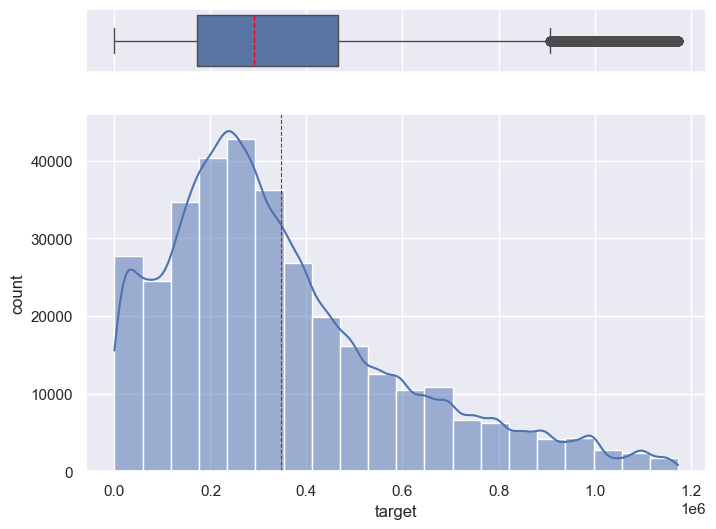

In [13]:
# lib.visual_hist_box(data=df['target'], c_name='Целевая переменная', x_label='Цена', y_label='Частота')
my_lib.visual_hist_box_2(data=df['target'])


### 3.2.Признак: private_pool - наличие собственного бассейна.
- Объединяем признаки, закодируем сразу.

In [14]:
# Объединение двух столбцов в один и переименование значений
df['private_pool'] = (df['PrivatePool']
                      .fillna(df['private pool'])
                      .str.lower()
                      .replace({'yes': True, 'no': False, None: False})
                      .astype('int8')
)

# Удаление старых столбцов 'private pool' и 'PrivatePool'
df.drop(columns=['private pool', 'PrivatePool'], inplace=True)

print(df['private_pool'].value_counts(dropna=False,normalize=True))


private_pool
0    0.895896
1    0.104104
Name: proportion, dtype: float64


### 3.3.Признак: 'mls-id' и 'MlsId':

Оба столбца содержат идентификаторы MLS и имеют высокий процент пропущенных значений (более 17% и более 93% соответственно). Поскольку это идентификаторы, они не предоставляют никакой полезной информации для анализа данных и прогнозирования цены, поэтому их можно безопасно удалить.

In [15]:
df.drop(columns=['mls-id', 'MlsId'], inplace=True)

# Появились новые дупликаты
print(f'Число дубликатов: {df.duplicated().sum()}')
df.drop_duplicates(inplace=True)

Число дубликатов: 89


### 3.4.Признак 'street':

Признаки, связанные с адресом:
   - 'street' — адрес объекта;
   - 'city' — город;  
   - 'zipcode' — почтовый индекс;
   - 'state' — штат;
  
В контексте нашего анализа, который охватывает практически всю страну, признак 'street' не является информативным. Он содержит множество уникальных значений, что делает его сложным для использования в анализе. Поэтому принимаем решение удалить этот столбец из нашего набора данных.

In [16]:
df[['street']].describe().T

,count,unique,top,freq
street,336151,300889,Address Not Disclosed,614


In [17]:
# Удаление столбца 'street'
df.drop(columns=['street'], inplace=True)

### 3.5.Признак 'state':
Обработаем признак на соотвествие правильности, существования и прочее.
Включим округ DC в список штатов

In [18]:
df[['state']].describe().T

,count,unique,top,freq
state,336153,39,FL,104727


In [19]:
address_data = ['city', 'zipcode', 'state']

# Список двухбуквенных кодов штатов США
valid_states = [
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
    'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
    'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
    'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
    'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'DC'
]

df['state'] = df['state'].str.upper()

# Фильтрация неверных записей
mask = (~df['state'].isin(valid_states))
df[mask][address_data]


,city,zipcode,state
153361,,33179,BA
172272,Other,11210,OT
274688,Foreign Country,00000,OS


In [20]:
# Удаление неверных записей c кодом штата из исходного датафрейма
df.drop(df[mask].index, inplace=True)

### 3.6.Признак 'zipcode':

- Приведем признак к числовому виду.

In [21]:
# 4666
# Обработка почтовых индексов с 4 цифрами, добавление ведущего нуля
mask = df['zipcode'].str.match(r'^\d{4}$')
df.loc[mask, 'zipcode'] = '0' + df['zipcode']

#27606-1626
# Извлечение первых пяти цифр из почтовых индексов
df['zipcode'] = df['zipcode'].str.extract(r'^(\d{5})')

# df['zipcode'] = df['zipcode'].astype(str)
# df[~df['zipcode'].str.match(r'^\d{5}$')][address_data]

df.dropna(subset=['zipcode'], inplace=True)


In [22]:
# Появились новые дупликаты
print(f'Число дубликатов: {df.duplicated().sum()}')
df.drop_duplicates(inplace=True)

# Save intermediate data
file_name = 'CleanedData_1'
df.to_csv(f'data/{file_name}.zip', index=False, compression=dict(method='zip', archive_name=file_name+'.csv'))
# df = pd.read_csv(f'data/{file_name}.zip')
print(f'{df.shape=}')
# df.shape=(334080, 15)

Число дубликатов: 2067
df.shape=(334080, 15)


In [ ]:
# Load intermediate data
file_name = 'CleanedData_1'
df = pd.read_csv(f'data/{file_name}.zip')
print(f'{df.shape=}')

df.shape=(334080, 15)


### 3.6.Признак 'city':

По почтовому коду выберем моду(частоту) в названии городов и заменим пустые ячейки и '--' данные.

In [23]:
not_valid_city_name = ["Other City - In The State Of Florida",
               "Other City Value Out Of Area",
               "Other City Not In The State Of Florida"
               ]

address_data = ['zipcode', 'state', 'city']

df['city'] = df['city'].str.title()

mask = (df['city'].isnull()) | (df['city'] == '--')
unique_zipcodes = df[mask]['zipcode'].unique()
zipcode_table = df[df['zipcode'].isin(unique_zipcodes)][address_data].astype({'city': str})

# grouped_zipcodes = zipcode_table.groupby('zipcode')['city'].unique()
# for zipcode, cities in grouped_zipcodes.items():
#     print(f'Почтовый индекс: {zipcode}, Города: {", ".join(cities)}')

# Найти самое частое значение в столбце 'city' для каждого уникального значения в столбце 'zipcode'
mode_city_per_zipcode=zipcode_table.groupby('zipcode')['city'].agg(lambda x: x.mode()[0]).reset_index()

# Присоединить найденные значения к основной таблице
df = pd.merge(df, mode_city_per_zipcode, on='zipcode', suffixes=('', '_most_common'), how='left')
print(f"Проверка на некорректные имена из списка, {(df['city_most_common'].isin(not_valid_city_name)).sum()} записей.")

# Присвоить значения из столбца 'city_most_common' для строк, где значение столбца 'city' равно NaN или '--'
df['city'] = np.where(mask, df['city_most_common'], df['city'])
print(f'Изменено {mask.sum()} записей.')
print(f"Проверка на пустые значения, {((df['city'].isnull()) | (df['city'] == '--')).sum()} записей.")


# Удалить временные столбецы
df.drop(columns=['city_most_common'], inplace=True)
del unique_zipcodes, zipcode_table, mode_city_per_zipcode

Проверка на некорректные имена из списка, 0 записей.
Изменено 36 записей.
Проверка на пустые значения, 0 записей.


Заменим редко употребляемые имена городов на часто употребляемые по почтовому индексу.

In [ ]:
city_counts = df[['state', 'city']].value_counts().to_frame()

# Сгруппировать DataFrame по столбцам 'zipcode' и 'city'
# и посчитать количество записей в каждой группе
mode_city_df = (df.groupby(['zipcode', 'state', 'city'])
                    .size().reset_index(name='count_')
                    # .groupby('zipcode').filter(lambda x: x['count_'].size > 1)
)

merge_df = pd.merge(mode_city_df, city_counts, on=['state', 'city'], suffixes=('', '_top'), how='left')
merge_df.drop(columns=['count_'], inplace=True)
# display(merge_df.query('zipcode=="50401"')[:5])
# 	zipcode	state	city	count
# 3114	50401	IA	Clear Lake	62
# 3115	50401	IA	Mason City	32

# Найти максимальные значения в каждой группе 'zipcode'
max_indices = merge_df.groupby('zipcode')['count'].idxmax()
merge_df_max = merge_df.loc[max_indices]
# display(merge_df_max.query('zipcode=="50401"')[:5])

# zipcode	state	city	count
# 3114	50401	IA	Clear Lake	62

# merge_df_max.shape ; df.zipcode.nunique() # 4256
df = pd.merge(df, merge_df_max, on='zipcode', suffixes=('', '_top'), how='left')
mask= (df['city']!=df['city_top'])
address_data.append('city_top')
display(df[mask][address_data][:3])

del city_counts, mode_city_df, merge_df, max_indices, merge_df_max
# df.drop(columns='city', inplace=True)
# df.rename(columns={'city_top': 'city'}, inplace=True)



,zipcode,state,city,city_top
1,99216,WA,Spokane Valley,Spokane
4,34759,FL,Poinciana,Kissimmee
6,50401,IA,Mason City,Clear Lake


---

Далее задача в проверке правильности названий городов c помощью библиотеки uszipcode.

In [ ]:
city_state_to_zip=dict()
city_state_to_major_city=dict()
invalid_cities=[]

# Объединяем столбцы 'state' и 'city_top' и удаляем дубликаты
unique_cities = df[['city_top','state']].drop_duplicates().to_records(index=False)#[:30]

# Сверка имени города
with SearchEngine() as search:
    for city, state in tqdm(unique_cities):
        try:
            results = search.by_city_and_state(city, state)
            if results and (city != results[0].major_city):
                city_state_to_major_city[(city, state)] = results[0].major_city
        except Exception as e:
            # print(f"Произошла ошибка при проверке города {city}, штата {state}: {e}")
            invalid_cities.append((city, state))

print('Не прошли сверку имени города:', len(invalid_cities))

if len(invalid_cities)>0:
    print("Неверные имена в названии городка:")
    for city, state in invalid_cities:
        print(city, state)

100%|██████████| 1236/1236 [03:51<00:00,  5.34it/s]

Не прошли сверку имени города: 14
Неверные имена в названии городка:
Sunrise FL
Seatac WA
Watauga TX
Georgia VT
Pittsfield Twp MI
Needmore TN
Highlands Ranch CO
Beaumont DE
Playa DE
Other NV
Bartlett TN
Mcallen FL
Indian Shores FL
Mount Pleasant GA


In [ ]:
# Удалим некоторые неверные записи
cities_tuple = (
    ('Pittsfield Twp', 'MI'),
    ('Needmore', 'TN'),
    ('Beaumont', 'DE'),
    ('Other', 'NV'),
    ('Mcallen', 'FL'),
    ('Mount Pleasant', 'GA')
)

# Создание маски на основе списка городов и штатов
mask = df[['city_top', 'state']].apply(tuple, axis=1).isin(cities_tuple)
print('Число записей перед удалением:', df.shape[0])

# Фильтрация DataFrame по маске и удаление записей
df = df[~mask]
print('Число записей после удаления:', df.shape[0])

Число записей перед удалением: 334080
Число записей после удаления: 334066


- Исключим редко используемые города, т.к. далее превратим имена городов в признак.

Порог отсечения: 100
Комбинация - штат и город.
Общее кол-во комбинаций: 1230
Количество комбинаций с частотой упоминания выше 100: 279
Общее количество записей: 334066
Количество записей, которые останутся после отсечения: 315127
Количество уникальных комбинаций, которые останутся после отсечения: 279


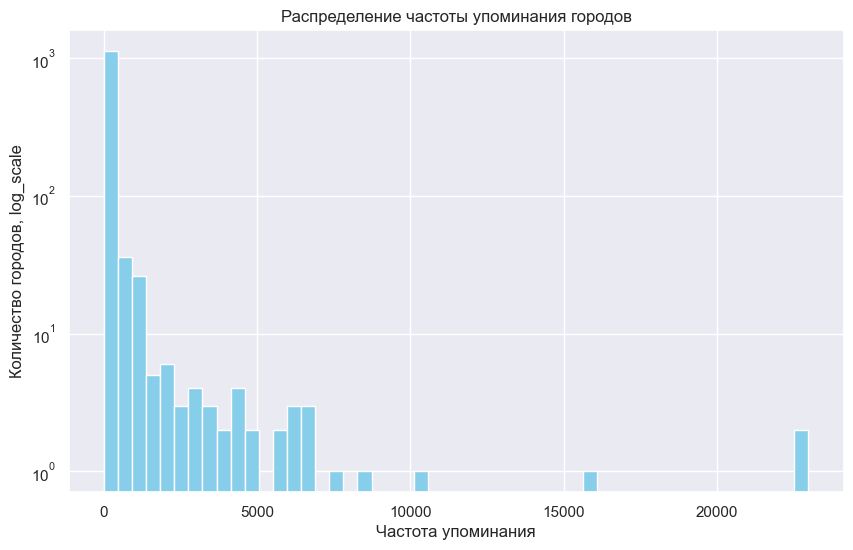

In [ ]:
# Определение порога для отсечения городов с малой частотой упоминания
threshold = 100

# filtered_df = df[df['city_top'].isin(df[['state', 'city_top']].value_counts().rename('count').reset_index().query('count > @threshold')['city_top'])]

# city_counts = df[['state','city_top']].value_counts().to_frame(name='count').reset_index()
# city_list = city_counts[city_counts['count'] > threshold]['city_top'].tolist()
# mask = df['city_top'].isin(city_list)
# filtered_df = df[mask]

city_counts = df[['state','city_top']].value_counts()
filtered_indices = city_counts[city_counts > threshold].index

# Фильтрация DataFrame по отфильтрованным индексам
filtered_df = df[df[['state', 'city_top']].apply(tuple, axis=1).isin(filtered_indices)]


print('Порог отсечения:', threshold)
print('Комбинация - штат и город.')
print(f'Общее кол-во комбинаций: {len(city_counts)}')
print(f"Количество комбинаций с частотой упоминания выше {threshold}: {(city_counts > threshold).sum()}")

print('Общее количество записей:', df.shape[0])
print(f"Количество записей, которые останутся после отсечения: {len(filtered_df)}")
print('Количество уникальных комбинаций, которые останутся после отсечения:',
        (filtered_df['state'] + '_' + filtered_df['city_top']).nunique())

plt.figure(figsize=(10, 6))
city_counts.plot(kind='hist', bins=50, color='skyblue')
plt.title('Распределение частоты упоминания городов')
plt.xlabel('Частота упоминания')
plt.ylabel('Количество городов, log_scale')
plt.grid(True)
plt.yscale('log')  # Устанавливаем логарифмический масштаб по оси y
plt.show()



PS: Как хороший вариант, загрузить базу крупных городов с гео кооординатми. И заменить имена маленьких городов к ближайщему городу.

In [ ]:
filtered_df.drop(columns=['count','zipcode','city', 'state_top'], inplace=True)
filtered_df.rename(columns={'city_top': 'city'}, inplace=True)

print(f'Число дубликатов: {filtered_df.duplicated().sum()}')
filtered_df.drop_duplicates(inplace=True)

# Сохраняем новую таблицу в отдельном файле, если это необходимо
file_name = 'CleanedData_2'
filtered_df.to_csv(f'data/{file_name}.zip', index=False, compression=dict(method='zip', archive_name=file_name+'.csv'))
df = filtered_df
del filtered_df

# df = pd.read_csv(f'data/{file_name}.zip')
print(f'{df.shape=}')
# df.shape=(315095, 14)

Число дубликатов: 32
df.shape=(315095, 14)


In [ ]:
# Для восстановления и продолжить
file_name = 'CleanedData_2'
df = pd.read_csv(f'data/{file_name}.zip')
print(f'{df.shape=}')

df.shape=(315095, 14)


### 3.7.Признак 'sqft - площадь в футах:

In [ ]:
df.sqft.value_counts()[:10]

sqft
0             9622
1,200 sqft     787
1,000 sqft     609
1,100 sqft     530
1,800 sqft     513
1,500 sqft     497
1,400 sqft     471
2,000 sqft     442
800 sqft       436
--             433
Name: count, dtype: int64

In [ ]:
# Преобразование данных в числовой формат и замена некорректных значений на None

feature_name = 'sqft'
print(f'# of null data before: {(df[feature_name].isna().sum())}')
df[feature_name] = (df[feature_name]
                  .str.replace(r'(,|sqft|--)', '', regex=True)
                  .str.strip()
                .apply(lib.extract_numbers)
                .astype(float)
                )
print(f'# of null data after: {(df[feature_name].isna().sum())}')
# Total null data(NaN) before: 32649
# Total null data(NaN) after: 33271

# of null data before: 32649
# of null data after: 33271


---

### 3.8. Признак 'status' - статус продажи:

In [ ]:
my_lib.short_info(df[['status']])

Размер таблицы :(315095, 1)
Число пустых значений: status    34980
dtype: int64


,count,unique,top,freq
status,280115,132,for sale,136125


Из анализа значений признака 'status' разобьем на 5 групп:
- New - жилье находится еще на стадии стройки
- Active - активное объявление
- Pending - есть покупатели на жилье и на стадии оформления
- 'Foreclosure' - арестовванные, аукционное жилье
- Other - прочие, которые были не возможны распознать к определенным группам

Случай со статусом жилья для аренды  мы удалим, оно не входит в наши задачу предсказания жилья

In [ ]:
feature_name = 'status'
# Arenda 393
# df.status.str.contains('rent') # 407
# mask = (df.status.str.contains('rent')) & (df.Arenda==1) # 393

# Временно заполним
df[feature_name] = df[feature_name].fillna('nan')
# Удаляем строки, в которых столбец 'status' содержит слово 'rent'
df = df[~df[feature_name].str.contains('rent')]

# Удаляем столбец 'Arenda'
df = df.drop(columns=['Arenda'])


In [ ]:
feature_name = 'status'

df[feature_name] = df[feature_name].str.lower()
mask = (df[feature_name].isin(['p','c','ct','pi','pf','ps']))
df[feature_name].mask(mask, 'Other',inplace=True)

status_replace_dict = {
    'New': ['new', 'coming'],
    'Foreclosure': ['auction', 'foreclo'],
    'Active': ['activ', 'sale','show','market','change'],
    'Pending': ['pending', 'continge', 'period','contract','closed','listing','backup','lease'],
    'Other': ['other']
}

my_lib.find_replace_by_contains_word(df[feature_name], status_replace_dict)

df.status.replace("nan", np.nan, inplace=True)
df.status.value_counts()

Replacing values: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


status
Active         258574
Foreclosure      9176
Pending          6217
New              4675
Other            1066
Name: count, dtype: int64

In [ ]:
print(f'Число дубликатов: {df.duplicated().sum()}')
df.drop_duplicates(inplace=True, ignore_index=True)

# Сохраняем новую таблицу в отдельном файле, если это необходимо
file_name = 'CleanedData_3'
df.to_csv(f'data/{file_name}.zip', index=False, compression=dict(method='zip', archive_name=file_name+'.csv'))
# df.shape=(314669, 13)
# df = pd.read_csv(f'data/{file_name}.zip')
print(f'{df.shape=}')

Число дубликатов: 19
df.shape=(314669, 13)


In [ ]:
# Для восстановления
file_name = 'CleanedData_3'
df = pd.read_csv(f'data/{file_name}.zip')
print(f'{df.shape=}')

df.shape=(314669, 13)


### 3.9.Признак 'stories' -  количество этажей:

In [ ]:
feature_name = 'stories'
df[feature_name] = df[feature_name].fillna('nan')
df[feature_name] = df[feature_name].str.lower()
df[feature_name+'_copy']= df[feature_name].copy(deep=True)


In [ ]:
# Удалить запятые и нули после цифры, пример: 5,00
df[feature_name] = df[feature_name].str.replace(r'\.\d+', '', regex=True)
df[feature_name] = df[feature_name].str.replace(r',\s|\.', '', regex=True)

stories_replace_dict = {
    'Mid Rise': ['4 stor','5+', '6+','six'],
    'Three Story': ['three', '3 stor','3+', 'tri'],
    'Two Story': ['two', '2 stor', 'fourplex', '2 level', '2 or', 'duplex',
          'bi-level'],
    'Single Story': ['one', '1 stor','1 level', 'ranch', 'manufactured','bungalow'],
    'Land': ['lot', 'acreage'],
}
my_lib.find_replace_by_contains_word(df[feature_name], stories_replace_dict)

stories_dict_ex ={
    'Low Rise': ['townhouse', 'stories/levels', 'multi-level', 'split level',
                 'traditional', 'garden', 'other multi-unit', 'split level w/ sub',
                 'ground level', 'modular home', 'cape cod', 'farm', 'multi level', 'multi-story'],
    'Mid Rise':['mid-rise', 'condo'],
    'High Rise':['high-rise'],
    'Land': ['commercial', 'unimproved commercial'],
}
lib.find_replace_by_contains_word(df[feature_name], stories_dict_ex)

# Фильтр малочисленных групп
not_numeric_values = df[~df[feature_name].str.isdigit()][feature_name]
list_values_del = not_numeric_values.value_counts().index.to_list()[7:]
df = df[~df[feature_name].isin(list_values_del)]

# Приводим к категориальному виду (Номинальный)
digit_to_number = {
    '0': 'Basement',
    '1': 'Single Story',
    '2': 'Two Story',
    '3': 'Three Story',
}

# Замена числовых значений на текстовые эквиваленты
df[feature_name].replace(digit_to_number, inplace=True)
# Замена оставшихся числовых значений на "Mid Rise"
df[feature_name].replace(['4','5','6','7','8','9'], 'Mid Rise', inplace=True)
# Замена всех оставшихся числовых значений на "High Rise"
df[feature_name].replace(to_replace=r'\d+', value='High Rise', regex=True, inplace=True)

df[feature_name].value_counts()

# df[feature_name].replace("nan", np.nan, inplace=True)
# stories
# nan             122271
# Single Story     91432
# Two Story        68447
# Three Story      13809
# Basement          8835
# Mid Rise          7808
# High Rise          647
# Low Rise           594
# Land               494



Replacing values: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


stories
nan             122271
Single Story     91432
Two Story        68447
Three Story      13809
Basement          8835
Mid Rise          7808
High Rise          647
Low Rise           594
Land               494
Name: count, dtype: int64

---

### 3.10.Признак 'propertyType' - типы жилья:

In [ ]:
feature = 'propertyType'
df[feature] = df[feature].fillna('nan')
df[feature] = df[feature].str.lower()
df[feature+'_сopy']= df[feature].copy(deep=True)

In [ ]:
# Добавть информацию об этажности в признак stories в отсутствующих данных
def find_fill_story(data: pd.DataFrame, feature_find, feature_set, replace_dict):
    for key, values in tqdm(replace_dict.items(), desc="Replacing values"):
        mask1 = data[feature_set] == 'nan'  # Создаем маску для незаполненных значений
        mask2 = data[feature_find].str.contains('|'.join(values), na=False)  # Обновляем маску с помощью оператора |
        data.loc[mask1&mask2, feature_set] = key  # Обновляем значения признака feature_set

story_replace_dict = {
    'Single Story': ['one stor', '1 stor', 'bungalow'],
    'Two Story': ['two stor', '2 stor', 'colonial'],
    'Three Story': ['3 stor'],
    'Land': ['lot/land']
}

feature = 'propertyType'
find_fill_story(df, feature, 'stories', story_replace_dict)

df['stories'].value_counts()[:10]

Replacing values: 100%|██████████| 4/4 [00:01<00:00,  3.27it/s]


stories
nan             97466
Single Story    95877
Two Story       71829
Land            17378
Three Story     13903
Basement         8835
Mid Rise         7808
High Rise         647
Low Rise          594
Name: count, dtype: int64

In [ ]:
property_replace_dict = {
    'Apartment': ['apartment'], # 791    Жилье для аренды, невозможно купить.
    'Elite-Residences':['historical', 'colonial', 'craftsman', 'greek revival',
                        'french','mediterranean','tudor', 'victorian', 'european',
                        'mid century','mid-century', 'other style', 'bungalow'
                        ,'penthouse', 'contemporary', 'spanish' ],
    'Townhouse':['multi-family', 'multi family', 'townho', 'co-op', '2 stor',
                 'two stor', 'low-rise', 'florida'],
    'Condominium':['condo', 'coop', 'cabin', 'ca2 n','ca2n',
          'mobile', 'mo2 le','mo2le', 'mid rise', 'high-rise', 'high rise',
          'multiple occupancy' ],
    'Single-family':['single-family', 'single family', 'cape cod', 'cottage',
          'farmhouse', 'ranch', 'log home', 'traditional', 'one stor',
          'single detached', '1 story', 'garden home', 'singlefamilyresidence'],
    'Land':['land'],
}

my_lib.find_replace_by_contains_word(df[feature], property_replace_dict)

df[feature].value_counts()[:10]

# propertyType
# Single-family       188929
# Condominium          50558
# Townhouse            40151
# Other                32023
# Land                 29445
# Elite-Residences      8481
# Apartment              791
# transitional           555
# other                  225
#                        121

Replacing values: 100%|██████████| 6/6 [00:10<00:00,  1.67s/it]


propertyType
Single-family       169993
Condominium          43640
Townhouse            34945
nan                  27753
Land                 27528
Elite-Residences      7289
Apartment              651
transitional           505
other                  143
cluster home           114
Name: count, dtype: int64

In [ ]:

# Удаляем малочисленные группы, а также Apartment
# df[feature].replace('nan','Other',inplace=True)
# df[feature].value_counts().index.to_list()
# Оставляем эти значения
propertyType_list = ['nan', 'Single-family', 'Condominium', 'Townhouse',
                        'Land', 'Elite-Residences']
df = df[df[feature].isin(propertyType_list)]
df[feature].value_counts()

propertyType
Single-family       169993
Condominium          43640
Townhouse            34945
nan                  27753
Land                 27528
Elite-Residences      7289
Name: count, dtype: int64

In [ ]:
# For test
mask1 = df.stories.str.contains('Land', na=False)
mask2 = df.propertyType.str.contains('Land', na=False)
# mask.sum()
# df[mask1 | mask2][['propertyType','stories']].drop_duplicates()[:20]
house_features = ['propertyType','stories', 'baths', 'sqft', 'beds', 'private_pool']
df[mask1 | mask2][house_features].drop_duplicates().sample(5)

,propertyType,stories,baths,sqft,beds,private_pool
30993,Land,Land,NaN,3200.0,3 Beds,0
35332,Land,Two Story,NaN,742.0,NaN,0
4059,Land,Single Story,NaN,1727.0,3 Beds,0
102729,Land,Land,NaN,1776.0,NaN,0
211225,Land,Two Story,NaN,613.0,NaN,0


Обработаем позже, чтобы понять это земельный участок или строение, когда заполним новые данные.

In [ ]:
# Удаляем временные файлы
df.drop(columns=['stories_copy', 'propertyType_сopy'],inplace=True)

# Вернем обратно пустые значения
df['stories'].replace("nan", np.nan, inplace=True)
df['propertyType'].replace("nan", np.nan, inplace=True)

print(f'Число дубликатов: {df.duplicated().sum()}')
df.drop_duplicates(inplace=True, ignore_index=True)

# Сохраняем таблицу в отдельном файле
file_name = 'CleanedData_4'
df.to_csv(f'data/{file_name}.zip', index=False, compression=dict(method='zip', archive_name=file_name+'.csv'))
# df = pd.read_csv(f'data/{file_name}.zip')
print(f'{file_name}, {df.shape=}')
# df.shape=(349587, 13)
# CleanedData_4, df.shape=(311076, 13)

Число дубликатов: 72
CleanedData_4, df.shape=(311076, 13)


In [ ]:
file_name = 'CleanedData_4'
df = pd.read_csv(f'data/{file_name}.zip')
print(f'{df.shape=}')
# df.shape=(349587, 13)

df.shape=(311076, 13)


---

### 3.11.Признак 'baths' — количество ванных комнат:

Особенности американских ванных. В числе ванных комнат с дробью встречаются различные значения, такие как:

- 0.5 ванной комнаты: Это может указывать на наличие только туалета и раковины без ванны или душа. Обычно такая конфигурация встречается в гостевых туалетах или в туалетах-комбинациях с другими помещениями.

- 1.5 ванной комнаты: Это может означать наличие полноценной ванной комнаты с ванной или душем, а также дополнительного туалета или душа без ванны.

- 2.5 ванных комнаты: Это может включать две полноценные ванные комнаты с ванной или душем и дополнительный туалет.

- 3.5 ванных комнаты: Здесь могут быть три полноценные ванные комнаты с дополнительным туалетом или душем.

Каждая из этих конфигураций представляет собой различные сочетания санузлов, душей и ванной, которые могут варьироваться в зависимости от спецификаций и дизайна конкретного помещения.

In [ ]:
feature_name = 'baths'
feature_copy = feature_name+'_copy'

lib.short_info(df[[feature_name]])
df[feature_name] = df[feature_name].str.lower()
df[feature_copy]= df[feature_name].copy(deep=True)
df[feature_name].value_counts()[:10]

Размер таблицы :(311076, 1)
Число пустых значений: baths    88064
dtype: int64


,count,unique,top,freq
baths,223012,154,2 Baths,49027


baths
2 baths         49030
3 baths         31438
2               18000
2.0             15669
4 baths         11296
3.0              9584
3                8751
bathrooms: 2     7019
2.5              6721
1.0              5672
Name: count, dtype: int64

In [ ]:
print(f'# of null data(NaN) before: {(df[feature_name].isna().sum())}')

df[feature_name] = (df[feature_name]
                  .str.replace(',','.')
                  .str.replace(r'(bath|--)', '', regex=True)
                .apply(my_lib.extract_numbers)
                .astype(float)
                )

print(f'# of null data(NaN) after: {df[feature_name].isna().sum()}')
df[feature_name].value_counts()[:10]

# of null data(NaN) before: 88064
# of null data(NaN) after: 88945


baths
2.00      93329
3.00      57358
4.00      19735
1.00      14821
2.50      11864
3.50       5032
5.00       4825
0.00       3695
1.50       3554
1.75       1453
6.00       1211
2.25       1154
1.25       1034
4.50        972
2.75        840
7.00        372
750.00      211
5.50        178
8.00        140
6.50         61
2.10         48
12.00        32
9.00         28
10.00        26
Name: count, dtype: int64

In [ ]:
mask = df[feature_name] ==750
df[mask]['propertyType'].value_counts()

propertyType
Elite-Residences    80
Townhouse           71
Single-family       14
Condominium          4
Name: count, dtype: int64

Как-то бросается в глаза значение 750, возможна ошибка, может быть 7.5.

Сделаем отсечение ванной со значением больше 10.

In [ ]:
# Подредактируем значение 750 на 7.5
mask = df[feature_name]==750
df.loc[mask, feature_name] = 7.5

print('Количество записей, до отсечения:', df.shape[0])
# Удалим записи больше 10
mask = df[feature_name] > 10
print(f"Количество записей для удаления: {mask.sum()}")
df = df[~mask]
print('Количество записей, после отсечения:', df.shape[0])

Количество записей, до отсечения: 311076
Количество записей для удаления: 110
Количество записей, после отсечения: 310966


Text(0, 0.5, '')

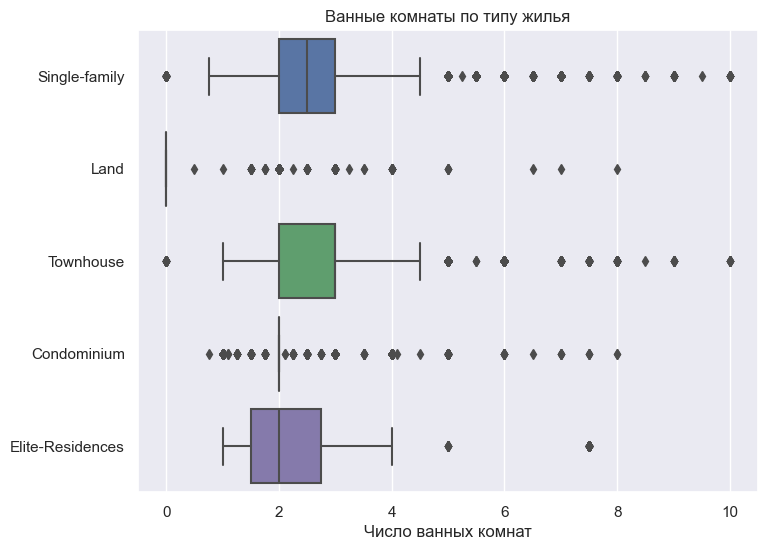

In [ ]:
boxplot = sns.boxplot(
    data = df,
    x = feature_name,
    y = 'propertyType',
    # y = 'stories',
)

boxplot.set_title('Ванные комнаты по типу жилья');
boxplot.set_xlabel('Число ванных комнат');
boxplot.set_ylabel('')

Пока вроде норм, т.е земельные участки без ванной и в кондоминимумах минимум.
В дальнейшем в EDA попробуем заполнить или очистить логически.

In [ ]:
# Удаляем временные файлы
df.drop(columns=[feature_copy],inplace=True)

print(f'Число дубликатов: {df.duplicated().sum()}')
df.drop_duplicates(inplace=True, ignore_index=True)

Число дубликатов: 6


---

### 3.12.Признак 'beds' — количество спален:

In [ ]:
feature_name = 'beds'
feature_copy = feature_name+'_copy'
lib.short_info(df[[feature_name]])

# df[feature] = df[feature].fillna('nan')
df[feature_name] = df[feature_name].str.lower()
df[feature_copy]= df[feature_name].copy(deep=True)
df[feature_name].value_counts()[:10]

Размер таблицы :(310960, 1)
Число пустых значений: beds    75194
dtype: int64


,count,unique,top,freq
beds,235766,1004,3 Beds,48557


beds
3 beds    48557
4 beds    30422
3         27855
2 beds    23935
4         16600
2         14591
baths     12615
3 bd       9152
5 beds     7835
3.0        6203
Name: count, dtype: int64

Гадать , что может значить эти данные не представляеся возможным, общее число таких данных 13131:
- 'baths'      12615
- 'bath'         435
- '-- sqft'       81
-
Решение пока обозначить как np.nan

In [ ]:
# Извлечение числовых данных
df[feature_name] = (df[feature_name]
                .str.replace(r'(beds|bd)', '', regex=True)
                .str.strip()
                .apply(my_lib.extract_numbers)
                .astype(float)
                )
print(f'# of null data(NaN) after: {df[feature_name].isna().sum()}')
# mask = df[tmp_col].str.contains(r'[a-z]', na=False, regex=True)
# df[mask][tmp_col].value_counts()[:10]

# of null data(NaN) after: 89204


In [ ]:
house_features = ['propertyType', 'stories', 'sqft', 'baths', 'beds']
view_col = house_features + [feature_copy]

mask1 = df[feature_copy].str.contains('acres', na=False, regex=False)
print(mask1.sum()) # 1292
df1 = df[mask1]

# Какова заполненость данных с пусым значением
# Есть ли смысл обработать
mask2 = (df1[['propertyType', 'stories', 'sqft']].isna().all(axis=1))
print(mask2.sum()) # 1284 rows

display(df1[mask2][view_col].sample(5))
del df1

1292
1284


,propertyType,stories,sqft,baths,beds,beds_copy
258610,NaN,NaN,NaN,NaN,0.50,0.5 acres
189553,NaN,NaN,NaN,NaN,2.97,2.97 acres
197355,NaN,NaN,NaN,NaN,0.54,0.54 acres
134621,NaN,NaN,NaN,NaN,1.25,1.25 acres
203505,NaN,NaN,NaN,NaN,1.02,1.02 acres


- Предположим, что строка 'acres' - площадь земли.
- Заполним в соотвествующие признаки данными

In [ ]:
def process_acres_row(row):
    # 1. Проверка наличия 'acres' в beds_copy
    if 'acres' in str(row['beds_copy']):
        # 2. Проверка всех трех столбцов на пустые значения
        if row[['propertyType', 'stories', 'sqft']].isna().all():
            # Присвоить значение 'Land' для propertyType и stories, если они пустые
            row['propertyType'] = 'Land'
            row['stories'] = 'Land'
            # Переведем акры в футах
            row['sqft'] = row['beds'] * 43560
            # Присвоить None для beds
            row['beds'] = None
    return row

mask1 = df[feature_copy].str.contains('acres', na=False, regex=False)
# Применение функции только к строкам, которые соответствуют маске mask1
df.loc[mask1] = df[mask1].apply(process_acres_row, axis=1)

In [ ]:
df.beds.value_counts()

beds
3.00      91861
4.00      56824
2.00      44362
5.00      14587
1.00       5632
6.00       3713
0.00       1128
7.00        994
8.00        662
9.00        292
10.00       225
12.00        44
64.00        44
11.00        29
16.00        14
14.00         8
13.00         8
18.00         6
15.00         5
20.00         5
17.00         3
640.00        2
24.00         2
708.00        1
0.26          1
100.00        1
0.57          1
448.00        1
34.00         1
871.00        1
4.64          1
540.00        1
44.00         1
360.00        1
0.29          1
248.00        1
30.00         1
831.00        1
23.00         1
0.63          1
0.32          1
1.80          1
0.71          1
22.00         1
840.00        1
Name: count, dtype: int64

Произведем отсечение до 12 спален
Удалим записи с содержанием слова sqft

- 'baths'      12615 - похоже ссылка на колонку baths
- 'bath'         435
- '-- sqft'       81


In [ ]:
print('Количество записей, до отсечения:', df.shape[0]) #(310960, 14)
# Удалим записи больше 12
mask1 = (df[feature_name] > 12) #& (df.propertyType=='Land')
mask2 = df[feature_copy].str.contains('sqft', na=False, regex=False) #1261
mask = mask1 | mask2
print(f"Количество записей для удаления: {mask.sum()}")
# df[mask][view_col+['target','city']].sample(20)
df = df[~mask]

# Удалим слишком пустые значения
mask3 = df[['propertyType', 'stories', 'sqft', 'beds', 'baths']].isna().all(axis=1)
mask3 = mask3.reindex(df.index)  # Переиндексация маски

print(f"Количество записей для удаления: {mask3.sum()}")
# df[mask3][view_col+['target','city']].sample(10)
df = df[~mask3]
print('Количество записей, после отсечения:', df.shape[0]) #310913 309652

# Количество записей, до отсечения: 310960
# Количество записей для удаления: 1363
# Количество записей для удаления: 9396
# Количество записей, после отсечения: 300201

Количество записей, до отсечения: 310960
Количество записей для удаления: 1363
Количество записей для удаления: 9396
Количество записей, после отсечения: 300201


In [ ]:
# Удаляем временные cтолбцы
df.drop(columns=[feature_copy],inplace=True)

print(f'Число дубликатов: {df.duplicated().sum()}')
df.drop_duplicates(inplace=True, ignore_index=True)

# Сохраняем в таблицу, если необходимо
file_name = 'CleanedData_5'
df.to_csv(f'data/{file_name}.zip', index=False, compression=dict(method='zip', archive_name=file_name+'.csv'))
# df = pd.read_csv(f'data/{file_name}.zip')
print(f'{file_name}, {df.shape=}')
# df.shape=(300200, 13)

Число дубликатов: 1
CleanedData_5, df.shape=(300200, 13)


In [ ]:
file_name = 'CleanedData_5'
df = pd.read_csv(f'data/{file_name}.zip')
print(f'{file_name}, {df.shape=}')
# df.shape=(300200, 13)

CleanedData_5, df.shape=(300200, 13)


---
### 3.13.Признак 'homeFacts' — сведения о строительстве объекта:

In [ ]:
# # Функция десериализации строки со словарем значений
# def deserialize_home(s: str) -> pd.Series:
#     result = eval(s)['atAGlanceFacts']
#     return pd.Series([r['factValue'] for r in result])

def deserialize_home(s: str) -> pd.Series:
    try:
        # Попытка разобрать строку JSON
        data_dict = json.loads(s.replace("'", '"').replace('None', 'null'))['atAGlanceFacts']
        return pd.Series([r['factValue'] for r in data_dict])
    except json.JSONDecodeError as e:
        # Обработка ошибки разбора JSON
        # print(f"Error parsing JSON: {e}")
        return pd.Series([np.nan] * 7)  # Возвращаем NaN для каждого столбца

home_features = ['yearBuilt', 'remodeledYear', 'heating', 'cooling',
                    'parking', 'lotsize', 'price_sqft']

# Применение функции к столбцу 'homeFacts'
# df1 = df[['homeFacts']].head(10).copy(deep=True)
df[home_features] = df['homeFacts'].apply(deserialize_home).replace(['', 'null', 'None', '—'], np.nan)

print(df[home_features].isna().sum())
display(df[home_features].head(3))


yearBuilt         42225
remodeledYear    173169
heating           75918
cooling           94565
parking          135848
lotsize           64374
price_sqft        40180
dtype: int64


,yearBuilt,remodeledYear,heating,cooling,parking,lotsize,price_sqft
0,2019,NaN,"Central A/C, Heat Pump",NaN,NaN,None,$144
1,2019,NaN,NaN,NaN,NaN,5828 sqft,$159/sqft
2,NaN,NaN,NaN,NaN,NaN,"10,019 sqft",None


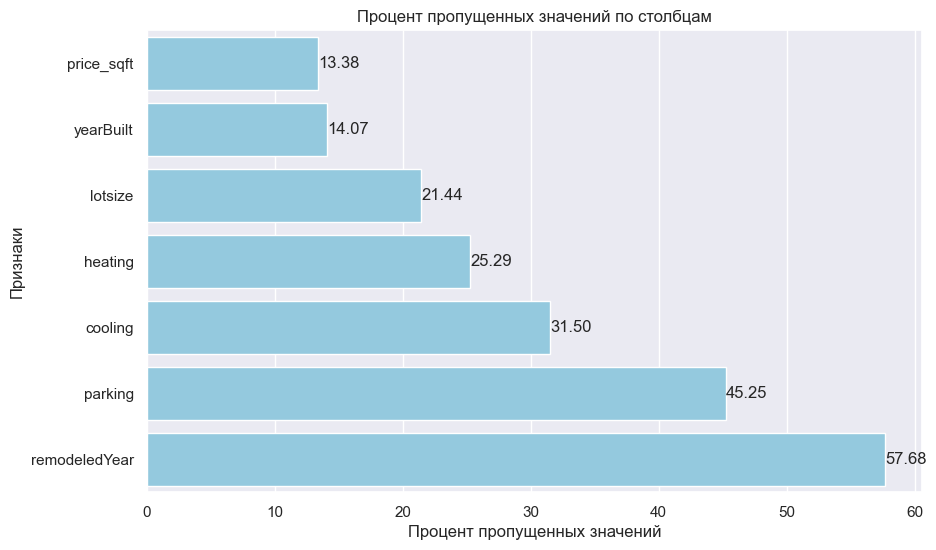

In [ ]:
# df[home_features].isna().sum().plot.barh()
lib.visual_missing_data(df[home_features])


---
#### 3.13.1 Признак 'homeFacts.lotsize - площадь земельного участка:

In [ ]:
feature_name = 'lotsize'
feature_copy = feature_name+'_copy'
house_features = ['propertyType', 'stories', 'sqft', 'beds', 'baths']

my_lib.short_info(df[[feature_name]])
df[feature_name] = df[feature_name].str.lower()
df[feature_copy]= df[feature_name].copy(deep=True)
df[feature_name].value_counts()[:10]

Размер таблицы :(300200, 1)
Число пустых значений: lotsize    64374
dtype: int64


,count,unique,top,freq
lotsize,235826,31581,no data,4751


lotsize
no data        4751
-- sqft lot    2817
0.26 acres     2602
0.25 acres     2386
0.28 acres     2169
0.27 acres     2110
0.29 acres     1893
0.34 acres     1543
6,098 sqft     1392
0.31 acres     1381
Name: count, dtype: int64

- Вычистим символы, извлечем числовые данные.
- Переведем акры в футы.
- Оставшие нечисловые присвоим None
- Записи типа 4,356 sqft будут интерпретироваться как 4356 sqft

In [ ]:
# Извлечение числовых данных
def convert_to_sqft(s):
    if pd.isna(s):
        return None

    acre_bool = ('acre' in s)

    pattern = r'\b\d+([\.|\,]\d+)?\b'
    numbers = re.search(pattern, s)
    result = None

    if numbers:
        number_str = numbers.group(0)
        if acre_bool or ('.' in number_str): # Переведем акры в футы
            # 21,767 acres -не очень верится в акры такие площади
            result = float(number_str.replace(',', '.')) * 43560
        elif ',' in number_str:
            result = float(number_str.replace(',', '.')) * 1000
        else:
            result = float(number_str)

    return result

mask = df[feature_name].str.contains(r'49,299', na=False)
df.loc[mask, feature_name] = '49299'
df[feature_name] = df[feature_name].apply(convert_to_sqft)

print(f'Число пустых значений: {df[feature_name].isna().sum()}')
df[house_features+[ feature_name, feature_copy]].sample(5)


Число пустых значений: 71942


,propertyType,stories,sqft,beds,baths,lotsize,lotsize_copy
90307,Single-family,NaN,1675.0,3.0,2.0,11761.0,11761
90965,Single-family,Two Story,2913.0,NaN,NaN,6875.0,"6,875 sq. ft."
234049,Single-family,Single Story,1744.0,3.0,2.0,8500.0,8500
187571,Single-family,Single Story,2020.0,3.0,2.0,9920.0,"9,920 sqft"
138055,Condominium,NaN,616.0,NaN,NaN,NaN,NaN


In [ ]:
mask = (df.lotsize < 10) #& (df.lotsize < 50)
# mask = df[feature_copy].str.contains(r'9,500', na=False)
print(mask.sum())
df[mask][house_features +[ feature_name, feature_copy]].sample(5)

175


,propertyType,stories,sqft,beds,baths,lotsize,lotsize_copy
276538,Land,NaN,0.0,NaN,NaN,1.0,1
172119,Townhouse,NaN,1590.0,3.0,3.0,1.0,1 sqft
289669,NaN,NaN,705.0,NaN,NaN,1.0,1 sq. ft.
194873,Condominium,NaN,540.0,NaN,NaN,1.0,1 sqft
104479,Condominium,NaN,696.0,NaN,1.0,1.0,1 sq. ft.


Возможно это площади, прилегающие к участку дому, или если фермерские дома, размер поля. Объединять с признаком sqft не стоит.

Число записей перед фильтрацией:  169868
После применения фильтрации IQR останется 134130 записей
Число записей перед фильтрацией:  169868
После применения z_score останется 143897 записей
Число записей перед фильтрацией:  28765
После применения фильтрации IQR останется 22758 записей
Число записей перед фильтрацией:  28765
После применения z_score останется 25403 записей
Число записей перед фильтрацией:  34823
После применения фильтрации IQR останется 21049 записей
Число записей перед фильтрацией:  34823
После применения z_score останется 22232 записей
Число записей перед фильтрацией:  43629
После применения фильтрации IQR останется 11542 записей
Число записей перед фильтрацией:  43629
После применения z_score останется 12764 записей
Число записей перед фильтрацией:  7284
После применения фильтрации IQR останется 4431 записей
Число записей перед фильтрацией:  7284
После применения z_score останется 4641 записей


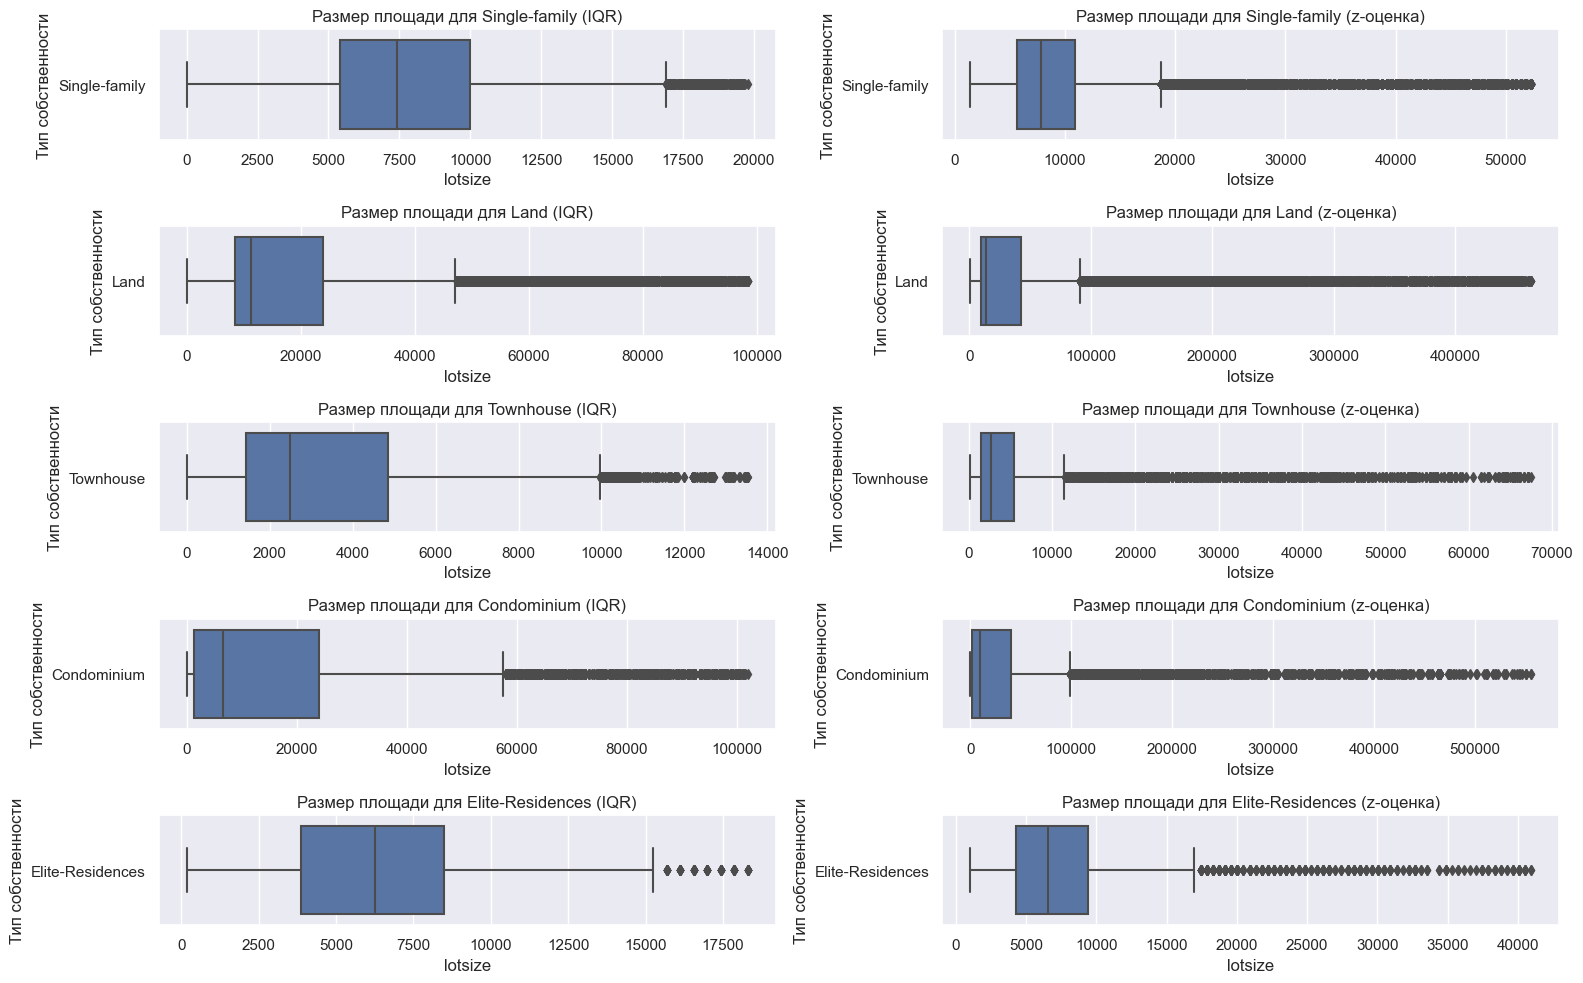

In [ ]:
# Создание графиков для каждого типа собственности
list_of_property = ['Single-family', 'Land', 'Townhouse', 'Condominium', 'Elite-Residences']
fig, axes = plt.subplots(len(list_of_property), 2, figsize=(16, 2 * len(list_of_property)))

for idx, property_type in enumerate(list_of_property):
    data_subset = df[df['propertyType'] == property_type]

    # График для IQR
    data_subset_iqr_filtered = data_subset[lib.IQR(data_subset[feature_name])]
    sns.boxplot(x=feature_name, y='propertyType', data=data_subset_iqr_filtered, ax=axes[idx, 0])
    axes[idx, 0].set_title(f'Размер площади для {property_type} (IQR)')
    axes[idx, 0].set_xlabel(feature_name)
    axes[idx, 0].set_ylabel('Тип собственности')

    # График для z-оценки
    data_subset_z_filtered = data_subset[lib.outliers_z_score(data_subset[feature_name],True,2,2)]
    sns.boxplot(x=feature_name, y='propertyType', data=data_subset_z_filtered, ax=axes[idx, 1])
    axes[idx, 1].set_title(f'Размер площади для {property_type} (z-оценка)')
    axes[idx, 1].set_xlabel(feature_name)
    axes[idx, 1].set_ylabel('Тип собственности')

plt.tight_layout()
plt.show()


- Предварительынй просмотр распределения при применении фильтрации данных по методу межквартильных размахов с 20 % по обеим сторонам.

Число записей перед фильтрацией:  300200
После применения фильтрации IQR останется 203366 записей


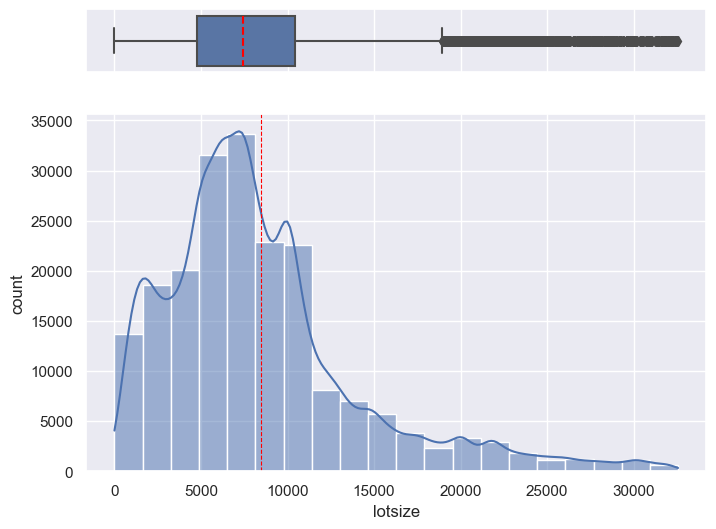

In [ ]:
# data = df['lotsize']
# data_filtered = df[df[feature_name] > 10]
# data = data_filtered[my_lib.IQR(data_filtered[feature_name],0.1)][feature_name]
data = df[lib.IQR(df[feature_name],0.2)][feature_name]

my_lib.visual_hist_box_2(data)

In [ ]:
df.drop(columns=['lotsize_copy'],inplace=True)

---

#### 3.13.2 Признак 'homeFacts.yearBuilt - год постройки:

home_features = ['remodeledYear', 'heating', 'cooling',
                    'parking', 'price_sqft']


In [ ]:
feature_name = 'yearBuilt'
feature_copy = feature_name+'_copy'

lib.short_info(df[[feature_name]])

df[feature_name] = df[feature_name].str.lower()
df[feature_copy]= df[feature_name].copy(deep=True)
print(df[feature_name].value_counts().index.to_list()[:10])

Размер таблицы :(300200, 1)
Число пустых значений: yearBuilt    42225
dtype: int64


,count,unique,top,freq
yearBuilt,257975,200,2019,26338


['2019', '2006', '2005', '2007', '2018', '2004', '2017', '2016', '2008', '1950']


In [ ]:
mask1 = df[feature_name].str.contains(r'^\d{4}$', na=False, regex=True)
# mask1 = df[feature_name].str.contains(r'\d{5,}', na=False, regex=True) # 2 rows
df.loc[~mask1, feature_name] = None

mask2 = df[feature_name]=='1057'
df.loc[mask2, feature_name] = None

mask3    = df[feature_name]=='2025' # ???
df.loc[mask2, feature_name] = '2015'



Число записей перед фильтрацией:  257002
После применения фильтрации IQR останется 256260 записей


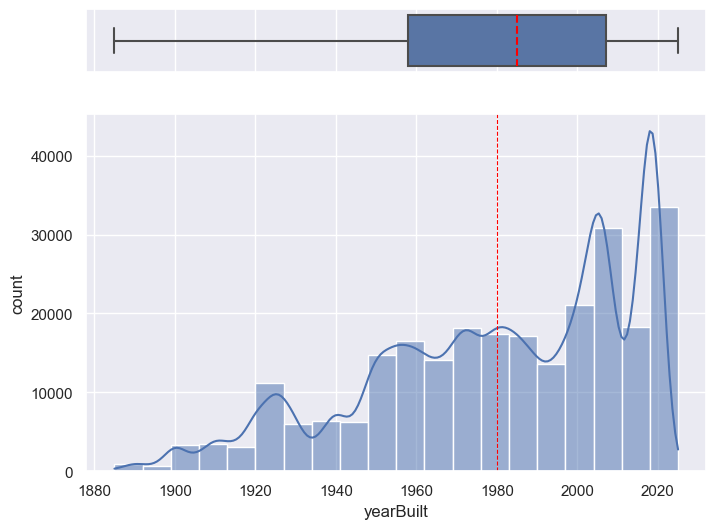

In [ ]:
mask_notna = df[feature_name].notna()
df_filtered = df[mask_notna][feature_name].astype(int)
data = df_filtered[my_lib.IQR(df_filtered)]
lib.visual_hist_box_2(data)

---

#### 3.13.3 Признак 'homeFacts.remodeledYear - год перестройки (ремонта):

- Если год перестройки не задан, присвоим им значение из признака yearBuilt
- Если год перестройки меньше чем год постройки, возьмем большее из них
- Удалим признак yearBuilt, далее будем использовать remodeledYear

In [ ]:
feature_name = 'remodeledYear'
feature_copy = feature_name+'_copy'

my_lib.short_info(df[[feature_name]])
df[feature_name] = df[feature_name].str.lower()
df[feature_copy]= df[feature_name].copy(deep=True)
# mask = df[feature_name].str.contains(r'[a-z]', na=False, regex=True)
# print(df[mask][feature_name].unique().tolist()[:30])
print(df[feature_name].value_counts().index.to_list()[:30])
# print(df[feature_name].str.isdigit().sum() + df[feature_name].isna().sum())

Размер таблицы :(300200, 1)
Число пустых значений: remodeledYear    173169
dtype: int64


,count,unique,top,freq
remodeledYear,127031,147,2006,4839


['2006', '2005', '2007', '2008', '2004', '1980', '1970', '2000', '1985', '1975', '2003', '1965', '1990', '1983', '2002', '1995', '1962', '2001', '1988', '1978', '1981', '1982', '1972', '1998', '1984', '1960', '1974', '1999', '1979', '1996']


In [ ]:
mask1 = df[feature_name]=='0'
df.loc[mask1, feature_name] = None

df['remodeledYear'].fillna(df['yearBuilt'], inplace=True)

# Создаем маску, чтобы найти строки, где год постройки больше года перестройки
mask2= df['remodeledYear'].astype(float) < df['yearBuilt'].astype(float)
# Используем маску для заполнения значений в признаке remodeledYear из yearBuilt
df.loc[mask2, 'remodeledYear'] = df.loc[mask2, 'yearBuilt']
df[mask2][['remodeledYear', 'yearBuilt', feature_copy]].sample(5)


,remodeledYear,yearBuilt,remodeledYear_copy
275939,2019,2019,1955
188507,2016,2016,1925
152570,1966,1966,1955
119294,2019,2019,2015
120622,1930,1930,1925


Min range: 1700 Max range: 2025
Число записей перед фильтрацией:  257177
После применения фильтрации IQR останется 253764 записей


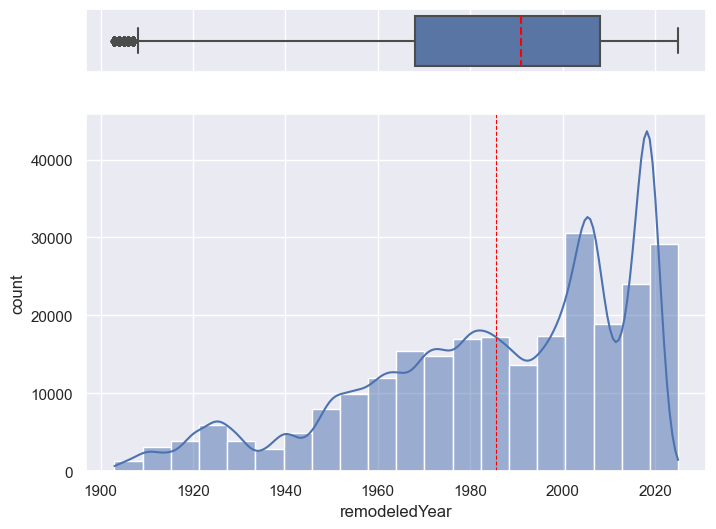

In [ ]:
mask_notna = df[feature_name].notna()
df_filtered = df[mask_notna][feature_name].astype(int)
print('Min range:', df_filtered.min(), 'Max range:',df_filtered.max())
data = df_filtered[lib.IQR(df_filtered)]
lib.visual_hist_box_2(data)

In [ ]:
# Удаляем временные cтолбцы
df.drop(columns=['yearBuilt', 'yearBuilt_copy', 'remodeledYear_copy'],inplace=True)

print(f'Число дубликатов: {df.duplicated().sum()}')
df.drop_duplicates(inplace=True, ignore_index=True)

# Сохраняем таблицу в файл, если необходимо
file_name = 'CleanedData_6'
df.to_csv(f'data/{file_name}.zip', index=False, compression=dict(method='zip', archive_name=file_name+'.csv'))
# df = pd.read_csv(f'data/{file_name}.zip')
print(f'{file_name}, {df.shape=}')
# df.shape=(300200, 19)

Число дубликатов: 0
CleanedData_6, df.shape=(300200, 19)


In [ ]:
# Read file
file_name = 'CleanedData_6'
df = pd.read_csv(f'data/{file_name}.zip')
print(f'{file_name}, {df.shape=}')

CleanedData_6, df.shape=(300200, 19)


---

#### 3.13.4 Признак 'homeFacts.price_sqft - цена площади за квадратный фут:

In [ ]:
feature_name = 'price_sqft'
feature_copy = feature_name+'_copy'

my_lib.short_info(df[[feature_name]])
df[feature_name] = df[feature_name].str.lower()
df[feature_copy]= df[feature_name].copy(deep=True)

mask = df[feature_name].str.contains(r'[a-z]', na=False, regex=True)
print(df[mask][feature_name].unique().tolist()[:10])

Размер таблицы :(300200, 1)
Число пустых значений: price_sqft    40180
dtype: int64


,count,unique,top,freq
price_sqft,260020,3657,$1/sqft,962


['$159/sqft', '$233/sqft', '$120 / sq. ft.', '$515/sqft', '$185/sqft', '$152 / sq. ft.', '$119/sqft', '$388/sqft', '$137/sqft', '$93/sqft']


Образцы данных:

- ['$159/sqft', '$1,031/sqft', '$120 / sq. ft.', 'no info', '$1,104']

In [ ]:
# Извлечение числовых данных
def extract_numbers(s):
    if pd.isna(s):
        return None
    pattern = r'\b\d+([\.|\,]\d+)?\b'
    numbers = re.search(pattern, s)
    result = None

    if numbers:
        number_str = numbers.group(0)
        if ',' in number_str:
            number_str = number_str.replace(',', '')
        result = float(number_str)

    return result

df[feature_name] = df[feature_name].apply(extract_numbers)

print(f'Число пустых значений: {df[feature_name].isna().sum()}')
print(df[feature_name].value_counts().sort_index())

df.drop(columns=feature_copy, inplace=True)



Число пустых значений: 41795
price_sqft
0.0          163
1.0         1040
2.0          224
3.0          216
4.0          143
            ... 
790000.0       1
889000.0       1
898000.0       1
899900.0       1
950000.0       1
Name: count, Length: 1548, dtype: int64


---

#### 3.13.5 Признак 'homeFacts.parking - наличие парковки (гаража).

Создадим три типа:
- garage - наличие гаража
- parking - парковка
- no data - нет данных

In [ ]:
feature_name = 'parking'
feature_copy = feature_name+'_copy'

lib.short_info(df[[feature_name]])
df[feature_name] = df[feature_name].str.lower()
df[feature_copy]= df[feature_name].copy(deep=True)

df[feature_name].value_counts()[:10]

Размер таблицы :(300200, 1)
Число пустых значений: parking    135848
dtype: int64


,count,unique,top,freq
parking,164352,2649,Attached Garage,59351


parking
attached garage             59351
2 spaces                    23087
1 space                     12202
detached garage             11485
no data                     11446
carport                      7035
off street                   4513
3 spaces                     3240
carport, attached garage     2611
1                            2553
Name: count, dtype: int64

In [ ]:
parking_replace_dict = {
    'Garage': ['garage', 'electric door', 'attached', 'detached'],
    'Parking':['parking', 'driveway', 'street', 'carport', 'drvwy',
               'concr', 'open', 'aspht', 'gravl', 'covered', 'pkpad'],
    'No data':['no data'],
}

my_lib.find_replace_by_contains_word(df[feature_name], parking_replace_dict)

pattern = r'[1-9]+(car|spac)?' # 2 car, 1 space
mask1 = df[feature_name].str.contains(pattern, na=False, regex=True)
df[feature_name].mask(mask1, 'Garage',inplace=True)
df[feature_name].mask(df[feature_name]=='0', 'No data',inplace=True)

pattern = r'^[a-z]' # Все оставшиеся
mask2 = df[feature_name].str.contains(pattern, na=False)
df[feature_name].mask(mask2, 'No data',inplace=True)

df[feature_name].value_counts()[:10]


Replacing values: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


parking
Garage     132777
Parking     19162
No data     12413
Name: count, dtype: int64

Т.к. перевес между наличием гаража и парковкой(на улице, во дворе и прочее) значительный, принято решение сделать бинарный признак garage - наличие\отсутствие

In [ ]:
# Значения "Garage" на "Yes", "Parking" на "No" и "No data" на "No"
df[feature_name].replace({'Garage': 1, 'Parking': 0, 'No data': 0}, inplace=True)

# Заполнить пропущенные значения как "No"
df[feature_name].fillna(0, inplace=True)
df.rename(columns={'parking': 'garage'}, inplace=True)
df['garage']= df['garage'].astype(int)
df.drop(columns=feature_copy, inplace=True)
df['garage'].value_counts()[:10]


garage
0    167423
1    132777
Name: count, dtype: int64

---

#### 3.13.6 Признак 'homeFacts.cooling - вентиляция.

In [ ]:
feature_name = 'cooling'
feature_copy = feature_name+'_copy'

lib.short_info(df[[feature_name]])
df[feature_name] = df[feature_name].str.lower()
df[feature_copy]= df[feature_name].copy(deep=True)

df[feature_name].value_counts()[:10]

Размер таблицы :(300200, 1)
Число пустых значений: cooling    94565
dtype: int64


,count,unique,top,freq
cooling,205635,1064,Central,133031


cooling
central                                       133031
central air                                    12922
no data                                         9003
has cooling                                     7492
central electric                                5764
wall                                            3520
central gas                                     3270
central heating                                 2669
cooling system                                  2238
central a/c (electric), central heat (gas)      1493
Name: count, dtype: int64

Создадим бинарный признак наличие\отсутствие вентиляции

In [ ]:
df[feature_name].mask(df[feature_name]=='no data', 0,inplace=True)
df[feature_name].fillna(0, inplace=True)
df[feature_name].mask(df[feature_name]!=0, 1,inplace=True)
df.drop(columns=feature_copy, inplace=True)
df[feature_name] = df[feature_name].astype(int)
df[feature_name].value_counts()

cooling
1    196632
0    103568
Name: count, dtype: int64

---

#### 3.13.7 Признак 'homeFacts.heating - обогрев.


In [ ]:
feature_name = 'heating'
feature_copy = feature_name+'_copy'

my_lib.short_info(df[[feature_name]])
df[feature_name] = df[feature_name].str.lower()
df[feature_copy]= df[feature_name].copy(deep=True)

# mask = df[feature_name].str.contains(r'[a-z]', na=False, regex=True)
# print(df[mask][feature_name].unique().tolist()[:30])
# print(df[feature_name].value_counts().index.to_list()[:30])
df[feature_name].value_counts()[:10]

Размер таблицы :(300200, 1)
Число пустых значений: heating    75918
dtype: int64


,count,unique,top,freq
heating,224282,1338,Forced Air,72453


heating
forced air           113760
other                 24834
electric               8972
gas                    7843
heat pump              7733
no data                7120
central electric       6599
central air            6026
central                5546
central, electric      3865
Name: count, dtype: int64

Если бы пустых значений не было бы таким большим, можно было бы как-то разделить на типы отопления.

Создание бинарного признака не имело бы смысла, т.к обогрев здания изначально полагается во всех домах, если требуется по климатическим условиям.

In [ ]:
df.drop(columns=[feature_name, feature_copy, 'fireplace'], inplace=True)

---
### 3.14.Признак 'schools' — сведения о школах в районе:

#### 3.14.1 Признак 'schools - наличие школы поблизости, рейтинг и расстояние.

In [ ]:
pd.set_option('display.max_colwidth', 200)
df[['schools']][:3]
# df['schools'][:3]

,schools
0,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR'], 'data': {'Distance': ['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5 mi', '12.6 mi', '2.7 mi', '3.1 mi'], 'Grades': ['3–5', '6–8', '9–12', '..."
1,"[{'rating': ['4/10', 'None/10', '4/10'], 'data': {'Distance': ['1.65mi', '1.32mi', '1.01mi'], 'Grades': ['9-12', '3-8', 'PK-8']}, 'name': ['East Valley High School&Extension', 'Eastvalley Middle S..."
2,"[{'rating': ['4/10', '5/10', '5/10'], 'data': {'Distance': ['5.96mi', '3.25mi', '3.03mi'], 'Grades': ['7-8', '9-12', 'PK-6']}, 'name': ['Southwest Middle School', 'Bayside High School', 'Westside ..."


Из данных можно предположить, что данные состоят из рейтинга, расстоянии и название каждой школы.
Произведем десериализацию, вычислим среднее рейтинга и расстояния.

In [ ]:
# Заполним пустым значением
null_data = "[{'rating': [], 'data': {'Distance': [], 'Grades': []}, 'name': []}]"
df['schools'].mask(df['schools']==null_data, None,inplace=True)

In [ ]:
# # Функция десериализации строки со словарем значений
def deserialize_schools(s: str) -> pd.Series:
    if pd.isna(s):
        return pd.Series([None] * 2)
    try:
        data_dict = eval(s)[0]
        # Попытка разобрать строку JSON
        # "Crain's Creek Middle School" problem ???
        # data_dict = json.loads(s.replace("'", '"').replace('None', 'null'))[0]
        return pd.Series([data_dict['rating'],data_dict['data']['Distance']])
    except json.JSONDecodeError as e:
        # Обработка ошибки разбора JSON
        # print(f"Error parsing JSON: {e}")
        # print(s)
        return pd.Series([None] * 2)  # Возвращаем NaN для каждого столбца

schools_features = ['Rating', 'Distance']

# Применение функции к столбцу 'schools'
df[schools_features] = df['schools'].apply(deserialize_schools)
df[['schools']+schools_features].sample(3)

,schools,Rating,Distance
172578,"[{'rating': ['7', 'NR', '8', '6'], 'data': {'Distance': ['0.2 mi', '0.1 mi', '0.2 mi', '0.2 mi'], 'Grades': ['Preschool to 8', 'Preschool to 8', '6 to 8', 'K to 12']}, 'name': ['PS 95 the Gravesen...","[7, NR, 8, 6]","[0.2 mi, 0.1 mi, 0.2 mi, 0.2 mi]"
196778,"[{'rating': ['1/10', '4/10', '4/10'], 'data': {'Distance': ['0.5 mi', '1.9 mi', '1.3 mi'], 'Grades': ['PK-5', '6-8', '9-12']}, 'name': ['Lakewood Elementary School', 'Bay Point Middle School', 'La...","[1/10, 4/10, 4/10]","[0.5 mi, 1.9 mi, 1.3 mi]"
135409,"[{'rating': ['7', '6', '5', '7'], 'data': {'Distance': ['18.2 mi', '2.5 mi', '8.1 mi', '18.2 mi'], 'Grades': ['K to 8', 'Preschool to 8', '9 to 12', '9 to 12']}, 'name': ['Cornerstone Academy Char...","[7, 6, 5, 7]","[18.2 mi, 2.5 mi, 8.1 mi, 18.2 mi]"


In [ ]:
# Функция для извлечения только целых чисел из списка строк, игнорируя значения "None" и дроби
def extract_and_mean_rating_from_list(data_list):
    # integers = [int(num) for num in re.findall(r'(\d+)/?', ' '.join(data_list)) if num != '10']
    # integers = [int(item.group(1)) for item in (re.search(r'^(\d+)/?', item) for item in data_list) if item]
    if data_list:
        integers = []
        for item in data_list:
            # Находим первое число в элементе списка с помощью регулярного выражения
            match = re.search(r'^(\d+)/?', item)
            if match:
                integers.append(int(match.group(1)))
        return np.mean(integers).round(2) if integers else None
    return None

df['Rating_Schools']= df.Rating.apply(extract_and_mean_rating_from_list)
df[['Rating', 'Rating_Schools']].sample(5)

,Rating,Rating_Schools
222659,"[3/10, 7/10, 2/10]",4.00
7475,"[9, 6, 7, 4, 7, 5, NR, NR]",6.33
193800,"[7/10, 9/10, 2/10]",6.00
215678,"[2, 7, 3, 5, 4, 6, NR, NR]",4.50
298152,"[2, 2, 3]",2.33


In [ ]:
# Функция для извлечения чисел из списка строк
def extract_and_mean_distance_from_list(data_list):
    if data_list:
        dis_list = []
        pattern = r'(\d+\.?\d*)\s*mi'
        for item in data_list:
            match = re.search(pattern, item)
            if match:
                dis_list.append(float(match.group(1)))
        return np.mean(dis_list).round(2) if dis_list else None
    return None

df['Distance_Schools']= df.Distance.apply(extract_and_mean_distance_from_list)
df[['Distance', 'Distance_Schools']].sample(5)

,Distance,Distance_Schools
159913,"[0.8 mi, 2.3 mi, 0.5 mi, 2.8 mi, 7.9 mi]",2.86
95644,"[0.12mi, 2.19mi]",1.16
100989,"[2.5 mi, 6.4 mi, 6.4 mi]",5.10
217397,"[1.5 mi, 1.9 mi, 2.9 mi]",2.10
86745,"[0.51mi, 0.81mi]",0.66


In [ ]:
column_drop = ['homeFacts', 'schools', 'Rating', 'Distance']
df.drop(columns=column_drop, inplace=True)

print(f'Число дубликатов: {df.duplicated().sum()}')
df.drop_duplicates(inplace=True, ignore_index=True)

# Сохраняем очищенную таблицу в отдельный файл
file_name = 'CleanedData_7'
df.to_csv(f'data/{file_name}.zip', index=False, compression=dict(method='zip', archive_name=file_name+'.csv'))
# df = pd.read_csv(f'data/{file_name}.zip')
print(f'{file_name}, {df.shape=}')
# CleanedData_7, df.shape=(299678, 17)

Число дубликатов: 522
CleanedData_7, df.shape=(299678, 17)


In [ ]:
# Read file
file_name = 'CleanedData_7'
df = pd.read_csv(f'data/{file_name}.zip')
print(f'{file_name}, {df.shape=}')

CleanedData_7, df.shape=(299678, 17)


## 4. Исследовательский анализ данных EDA

- Описание признаков
- Выявление отличий и взаимосвязей
- Построение начальльных моделей

В рамках EDA нам нужно решить три основных задачи: описать данные, найти отличия и выявить взаимосвязи. Описание данных позволяет понять, о каких данных идет речь, а также выявить недостатки в данных (с которыми мы справляемся на этапе обработки). Отличия и взаимосвязи в данных — основа для построения модели, это то, за что модель «цепляется», чтобы выдать верный числовой результат, правильную классификацию или кластер.

Для решения этих задач наилучшим образом подходят средства визуализации и описательная статистика.

Отдельно хочется сказать про baseline models, простые модели, которые мы строим в самом начале работы. Они позволяют понять какой результат мы можем получить, не вкладывая дополнительных усилий в работу с данными, а затем отталкиваться от этого результата для обработки данных и построения более сложных моделей.

Данные:

1. Числовые (выражены числами):
    - Непрерывные (неограниченное число вариантов): возраст, вес, артериальное давление
        + 'target' - целевая переменная
        + 'sqft', 'price_sqft', 'lotsize', 'baths', 'Rating_Schools', 'Distance_Schools'
    - Дискретные (ограниченное число вариантов): размер обуви, количество детей
        + 'remodeledYear'
        +  'beds' - округлим в целые числа

2. Категориальные (выражены словами):
    - Порядковые (имеют иерархию): выраженность боли, уровень удовлетворённости, настроение
        - Можно было отнести к этому этажность, но определить что цена на жилье в многоэтажке выше чем в обычном одноэтажном, спорно.
    - Номинальные (не имеют иерархии): пол, цвет глаз, порода собак, группа крови
        + 'status', 'state', 'city', 'stories', 'propertyType'
        + 'private_pool', 'cooling', 'garage' -бинарные признаки


Оценим пропущенные значения

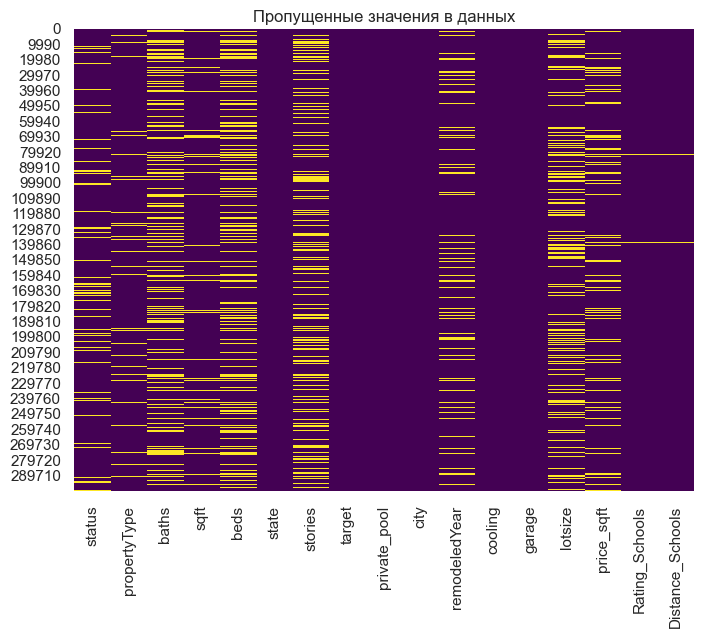

In [ ]:
sns.heatmap(df.isnull(), cmap='viridis', cbar=False)
plt.title('Пропущенные значения в данных')
plt.show()

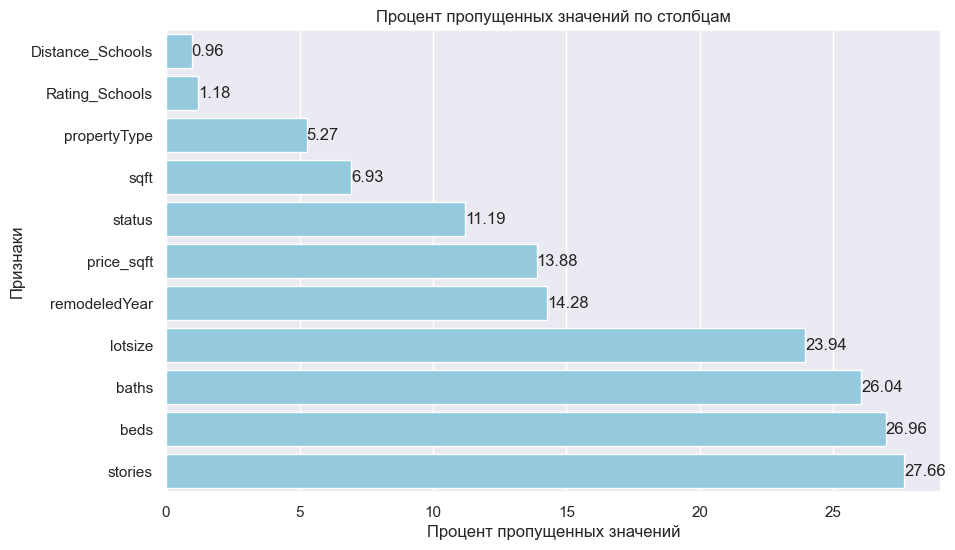

In [ ]:
lib.visual_missing_data(df)

In [ ]:
print('Пример жесткого варианта очистки данных, останется ', len(df.dropna()), ' записей.')

Пример жесткого варианта очистки данных, останется  102315  записей.


Выберем очистку данных, где в строке имеется больше 2 NaN значений.

In [ ]:
print('Исходная таблица: ', df.shape)
# Удаление строк с более чем 2 NaN значениями
threshold = df.shape[1] - 2  # Минимальное количество ненулевых значений для строки (столбцы - 1)
df_cleaned = df.dropna(thresh=threshold)
print(f'После очистки пустых значений с порогом более {df.shape[1] - threshold} NaN: ', df_cleaned.shape)

Исходная таблица:  (299678, 17)
После очистки пустых значений с порогом более 2 NaN:  (226156, 17)


Вполне достаточный размер для обучения baseline-model.

Далее мы заполним некоторые признаки модой, медианой и средним, очистим выбросы.

---

### 4.1 Признак target

Целевая переменная, количественный, значит наша задача -построить модель регрессии.

- На этапе очистки данных, мы уже использовали метод межквартильый размах.
- Оценим нормальность, если нет, попробуем привести его к нормальному виду.

Если преобразовываете целевую переменную, важно выполнить обратное преобразования после формирования прогноза.

- Глянем на распределений исходных данных целевого признака

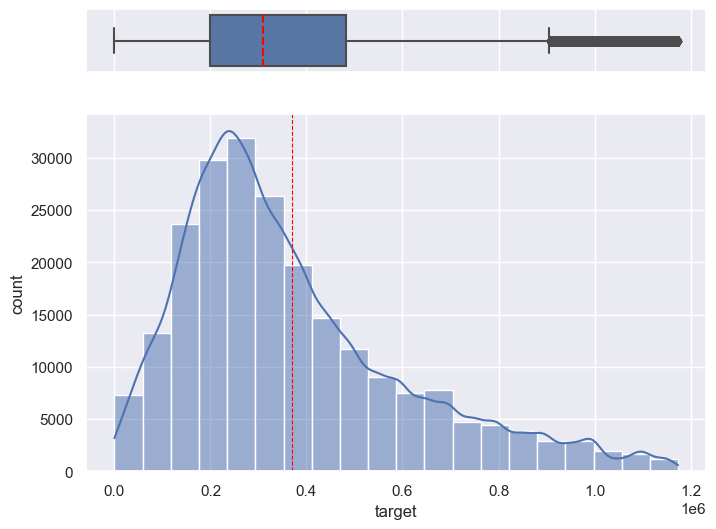

In [ ]:
my_lib.visual_hist_box_2(df_cleaned.target)

Есть несколько способов проверить на нормальность(распределение) данных.

1. Графики для проверки нормальности
2. Статистические тесты на нормальность

При визуализации данных видим, что график немного скошен(skewness) вправо.
Проведем некоторые преобразования, применим графический и статистический тест Шапиро.

- Вариант 1 - логарифмирование данных.

Статистика теста Шапиро-Уилка: 0.8565157651901245, p-value: 0.0
Отклоняем гипотезу о нормальности(Gaussian)


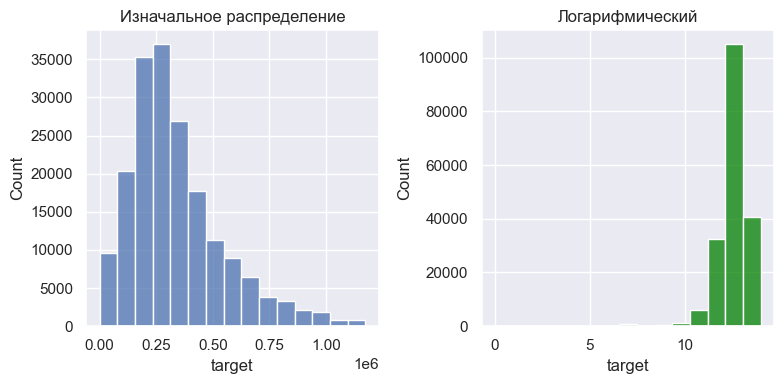

In [ ]:
log_target = np.log(df_cleaned.target)
lib.test_shapiro(log_target)
# lib.visual_hist_box_2(log_target)
lib.visual_compare_hist(df_cleaned.target, log_target, 'Изначальное распределение', 'Логарифмический')


- Вариант 2 - преобразование Бокса-Кокса.

Статистика теста Шапиро-Уилка: 0.9927409887313843, p-value: 0.0
Отклоняем гипотезу о нормальности(Gaussian)


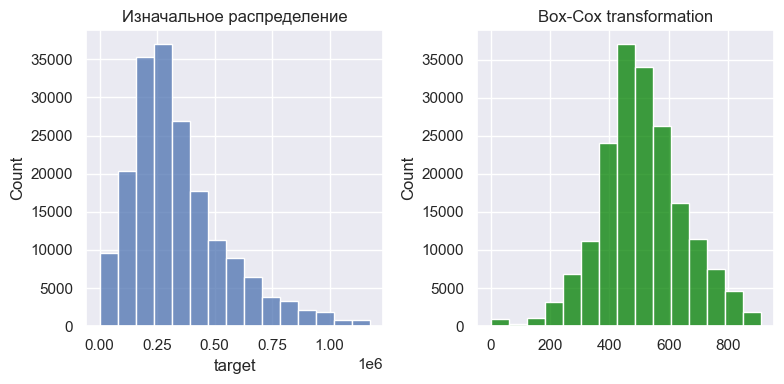

In [ ]:
# Преобразование Бокса-Кокса
transformed_target, lambda_value = boxcox(df_cleaned.target)

# Обратное преобразование после формирования прогноза
# Предположим, прогнозные значения transformed_predicted_target
# Обратно преобразуем их на исходную шкалу
# original_predicted_target = inv_boxcox(transformed_predicted_target, lambda_value)


# Тест Шапиро на нормальность после преобразования Бокса-Кокса
my_lib.test_shapiro(transformed_target)

lib.visual_compare_hist(df_cleaned.target, transformed_target,
                           'Изначальное распределение', 'Box-Cox transformation')

Хотя тест на нормальность не прошел, примем преобразование целевого признака по методу Бокса-Кокса

---

### 4.2 EDA, признак 'propertyType'

- Категориальный, номинальный ('Single-family', 'Land', 'Townhouse', 'Condominium', nan,
       'Elite-Residences')

In [ ]:
# Сгруппируем признаки для анализа
address_features = ['state','city']
home_features = ['status', 'propertyType', 'stories', 'baths',
    'beds', 'sqft',  'lotsize', 'price_sqft', 'private_pool',
     'cooling', 'garage', 'remodeledYear', ]
schools_features = ['Rating_Schools', 'Distance_Schools']

In [ ]:
# Заполнение пропущенных значений в столбце 'propertyType' модой

fill_values = df_cleaned.groupby('stories')['propertyType'].apply(lambda x: x.mode().iloc[0]).to_dict()
mask = df_cleaned['propertyType'].isnull()
df_cleaned.loc[mask, 'propertyType'] = df_cleaned.loc[mask, 'stories'].map(fill_values)

print(df_cleaned[['propertyType', 'stories']].isna().sum())

propertyType        0
stories         39897
dtype: int64


Text(0, 0.5, 'Типы недвижимости')

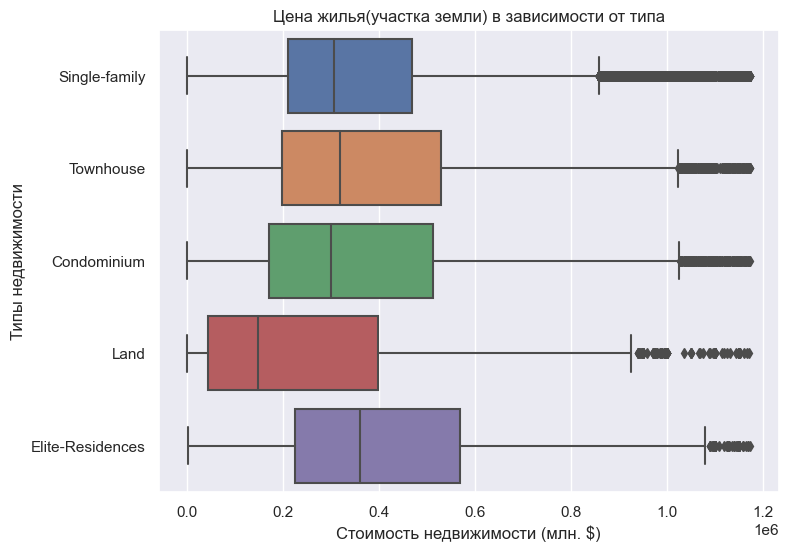

In [ ]:
boxplot = sns.boxplot(data = df_cleaned, x = 'target', y = 'propertyType')
boxplot.set_title('Цена жилья(участка земли) в зависимости от типа')
boxplot.set_xlabel('Стоимость недвижимости (млн. $)')
boxplot.set_ylabel('Типы недвижимости')

- Стоимость участка земли без жилья низкая
- Медианная цена элитного жилья цениться выше остальных

Можно предположить что заполнение с признаком 'propertyType' хорошее.

---

### 4.3 EDA, признак 'stories'

- Категориальный, номинальный
- Значения - ('Two Story', 'Land', 'Single Story', 'Mid Rise', 'Basement',
 'Three Story', 'High Rise', 'Low Rise')

In [ ]:
# # Функция для заполнения пропущенных значений в столбце 'stories' модой

fill_values = df_cleaned.groupby('propertyType')['stories'].apply(lambda x: x.mode().iloc[0]).to_dict()
mask = df_cleaned['stories'].isnull()
df_cleaned.loc[mask, 'stories'] = df_cleaned.loc[mask, 'propertyType'].map(fill_values)

print(df_cleaned.stories.isna().sum())

0


Осталось устранить конфликт значений с земельным участком

In [ ]:
# Если тип жилья и этажность упоминается как земельный участок,
# но есть данные по числу спален или размер ванной, то удалим записи
# Создание маски
mask1 = (df_cleaned['propertyType'] == 'Land') & (df_cleaned['stories'] == 'Land')
mask2 = (df_cleaned['baths'].notna()) | (df_cleaned['beds'].notna())
mask = mask1 & mask2

# Подсчет количества строк, которые соответствуют маске
print(mask.sum())

# Удаление строк, соответствующих маске, из DataFrame
df_cleaned = df_cleaned[~mask]


1069


In [ ]:
# Если данных по числу спален или размер ванной нету
# и при этом есть упоминание о не земельном участке в одном из них
# удаляем
mask1 = (df_cleaned['propertyType'] == 'Land') | (df_cleaned['stories'] == 'Land')
mask2 = (df_cleaned['baths'].isna()) & (df_cleaned['beds'].isna())
mask3 = df_cleaned['propertyType'] != df_cleaned['stories']
mask = mask1 & mask2 & mask3

# Подсчет количества строк, которые соответствуют маске
print(mask.sum())

# select_columns = ['propertyType','stories','baths','beds']
# df_cleaned[mask][select_columns].sample(10)

# Удаление строк, соответствующих маске, из DataFrame
df_cleaned = df_cleaned[~mask]


358


In [ ]:
# Находим в одном из них упоминание о земельном участке
# Если есть данные по размеру ванной либо спален
# то заменяем по словарю

prototype_to_stories = {'Condominium': 'Mid Rise',
    'Elite-Residences': 'Two Story',
    'Land': 'Land',
    'Single-family': 'Single Story',
    'Townhouse': 'Two Story'}

stories_to_prototype = {'Basement': 'Single-family',
            'High Rise': 'Condominium',
            'Land': 'Land',
            'Low Rise': 'Townhouse',
            'Mid Rise': 'Condominium',
            'Single Story': 'Single-family',
            'Three Story': 'Townhouse',
            'Two Story': 'Single-family'}

select_columns = ['propertyType','stories','baths','beds']

mask1 = (df_cleaned.propertyType == 'Land') | (df_cleaned.stories == 'Land')
mask2 = df_cleaned.propertyType != df_cleaned.stories
mask3 = df_cleaned.baths.notna() | df_cleaned.beds.notna()
mask = mask1 & mask2 & mask3

print(mask.sum())

select_columns = ['propertyType', 'stories', 'baths', 'beds']

# Создаем DataFrame, содержащий строки, которые соответствуют маске
df_filtered = df_cleaned[mask][select_columns]

for index, row in df_filtered.iterrows():
    if row['propertyType'] != 'Land':
        df_cleaned.at[index, 'propertyType'] = stories_to_prototype[row['stories']]
    elif row['stories'] != 'Land':
        df_cleaned.at[index, 'stories'] = prototype_to_stories[row['propertyType']]


932


Text(0, 0.5, 'Этажность')

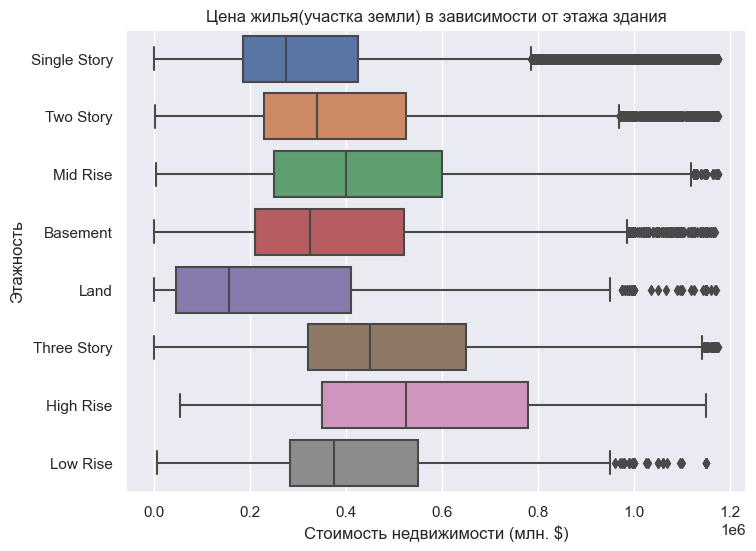

In [ ]:
# Построим диаграмму целевого признака с разбивкой по этажности дома
boxplot = sns.boxplot(data = df_cleaned, x = 'target', y = 'stories')
boxplot.set_title('Цена жилья(участка земли) в зависимости от этажа здания')
boxplot.set_xlabel('Стоимость недвижимости (млн. $)')
boxplot.set_ylabel('Этажность')

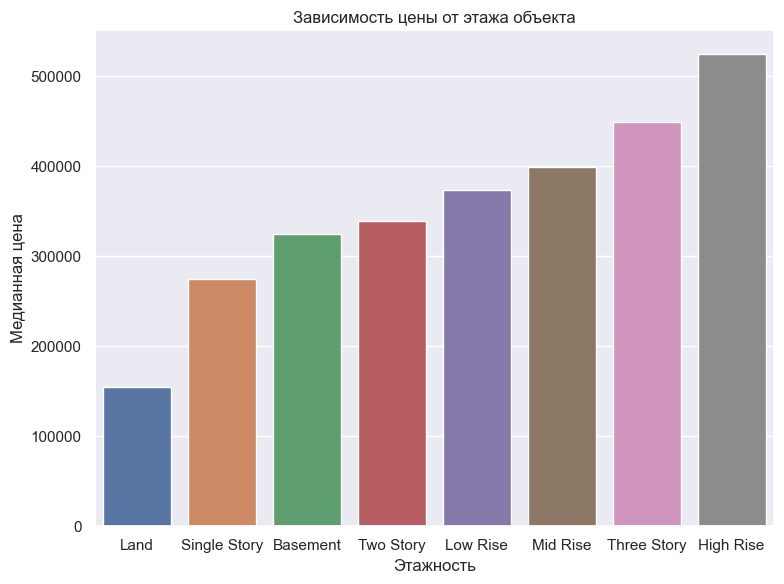

In [ ]:
# Группировка данных по этажности объекта и вычисление медианы цены
price_by_stories = df_cleaned.groupby('stories')['target'].median().reset_index()
price_by_stories.sort_values(by='target', inplace=True)

sns.barplot(x='stories', y='target', data=price_by_stories)
plt.title('Зависимость цены от этажа объекта')
plt.xlabel('Этажность')
plt.ylabel('Медианная цена')
# plt.xticks(rotation=90)
# plt.ylim((220000,360000))
plt.tight_layout()
plt.show()


- Чем больше этажей, тем выше цена. Как бы с логикой сходится
- Трехэтажные частные дома ценятся выше всех. P.S HighRise

In [ ]:
# column_drop = []
# df.drop(columns=column_drop, inplace=True)

print(f'Число дубликатов: {df_cleaned.duplicated().sum()}')
df_cleaned.drop_duplicates(inplace=True, ignore_index=True)

# Сохраняем очищенную таблицу в отдельный файл
file_name = 'CleanedData_8'
df_cleaned.to_csv(f'data/{file_name}.zip', index=False, compression=dict(method='zip', archive_name=file_name+'.csv'))
# df = pd.read_csv(f'data/{file_name}.zip')
print(f'{file_name}, {df_cleaned.shape=}')
# (224715, 17)
df = df_cleaned

Число дубликатов: 14
CleanedData_8, df_cleaned.shape=(224715, 17)


In [ ]:
# Read file
file_name = 'CleanedData_8'
df = pd.read_csv(f'data/{file_name}.zip')
print(f'{file_name}, {df.shape=}')
# (224715, 17)

CleanedData_8, df.shape=(224715, 17)


---

### 4.4 EDA, признак 'sqft', 'lotsize', 'price_sqft'

- Количественный, непрерывный

In [ ]:
# 1. Создаем функцию для заполнения пропущенных значений медианой
fill_median = lambda x: x.fillna(x.median())

print(df[['sqft', 'lotsize', 'price_sqft']].isna().sum())

# 2. Заполняем пропущенные значения в 'sqft', 'price_sqft' и 'lotsize' медианой
# для каждой группы 'propertyType' и 'stories'
data_group = df.groupby(['state', 'city', 'propertyType', 'stories'])
df['sqft'] = data_group['sqft'].transform(fill_median)
df['lotsize'] = data_group['lotsize'].transform(fill_median)
df['price_sqft'] = data_group['price_sqft'].transform(fill_median)

print(df[['sqft', 'lotsize', 'price_sqft']].isna().sum())

df['lotsize'] = df.groupby(['propertyType', 'stories'])['lotsize'].transform(fill_median)
print(df[['sqft', 'lotsize', 'price_sqft']].isna().sum())

df.dropna(subset=['sqft', 'lotsize', 'price_sqft'], inplace=True)


sqft            324
lotsize       38940
price_sqft     8388
dtype: int64
sqft             2
lotsize       1336
price_sqft      33
dtype: int64
sqft           2
lotsize       19
price_sqft    33
dtype: int64


Число записей перед фильтрацией:  224715
После применения фильтрации IQR останется 168936 записей


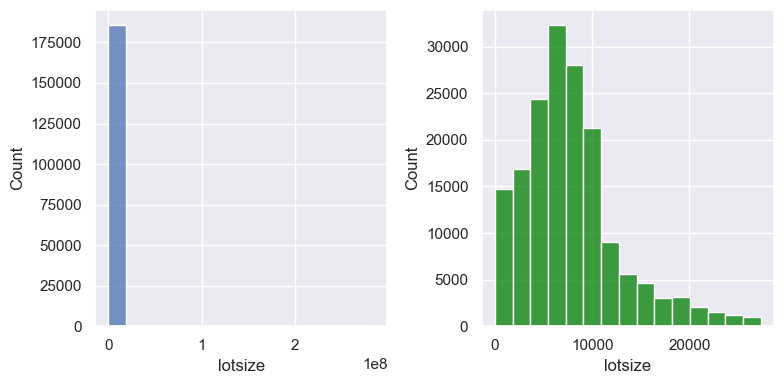

In [ ]:
feature_name = 'lotsize'
# data = df[feature_name]
# data_filtered = df[df[feature_name] > 10]
# data = data_filtered[my_lib.IQR(data_filtered[feature_name],0.1)][feature_name]
mask_IQR = my_lib.IQR(df[feature_name],0.2)
data = df[mask_IQR][feature_name]
# data2 = df[my_lib.outliers_z_score(df[feature_name])][feature_name]
# my_lib.visual_hist_box_2(data)
my_lib.visual_compare_hist(df[feature_name], data, 'Исходные данные', 'После очистки IQR=0.2')

# Очистим выбросы
df = df[mask_IQR]

Число записей перед фильтрацией:  168936
После применения фильтрации IQR останется 166550 записей


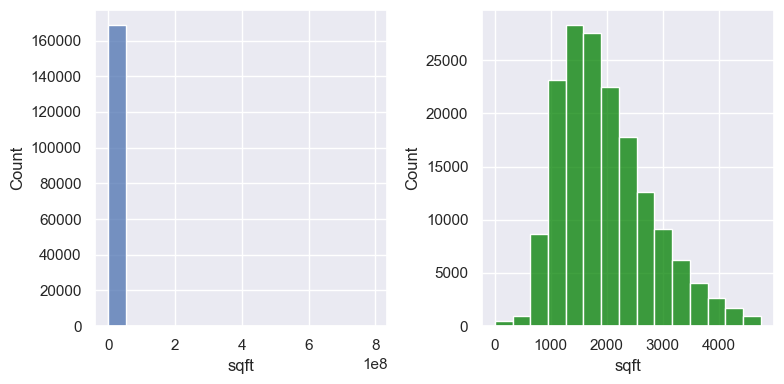

In [ ]:
feature_name = 'sqft'
mask_IQR = my_lib.IQR(df[feature_name],0.2)
data = df[mask_IQR][feature_name]
# my_lib.visual_hist_box_2(data)
my_lib.visual_compare_hist(df[feature_name], data, 'Исходные данные', 'После очистки IQR=0.2')

# Очистим выбросы
df = df[mask_IQR]

Число записей перед фильтрацией:  166550
После применения фильтрации IQR останется 152465 записей


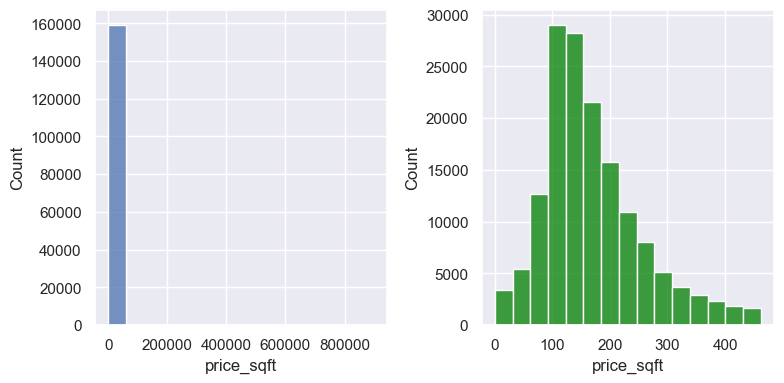

In [ ]:
feature_name = 'price_sqft'
mask_IQR = my_lib.IQR(df[feature_name],0.2)
data = df[mask_IQR][feature_name]
# my_lib.visual_hist_box_2(data)
my_lib.visual_compare_hist(df[feature_name], data, 'Исходные данные', 'После очистки IQR=0.2')

# Очистим выбросы
df = df[mask_IQR]

После фильтрации значения sqft более 10 останется 152465 записей.


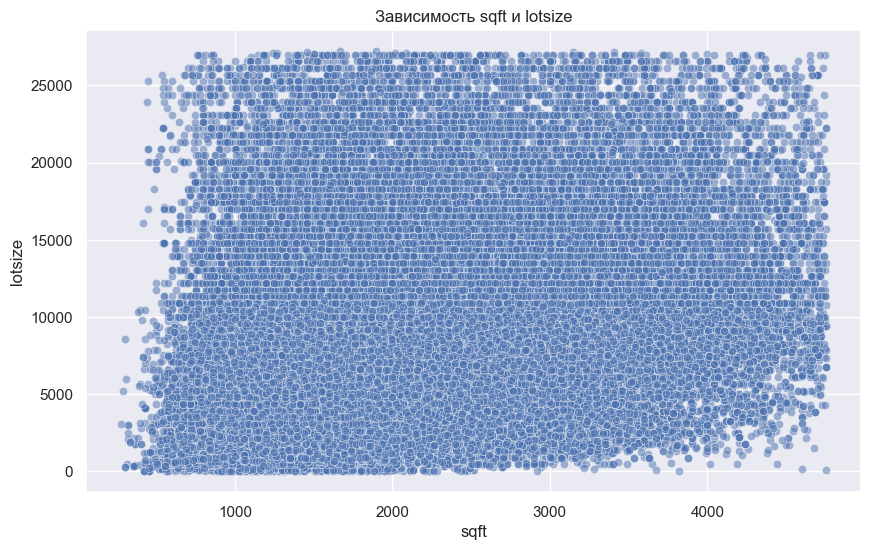

In [ ]:
# Дополнительно очистим
feature_name = 'sqft'
mask= df[feature_name] > 10
data_filtered = df[mask]

print(f'После фильтрации значения sqft более 10 останется {mask.sum()} записей.')
df = df[mask]

plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_filtered.sqft, y=data_filtered.lotsize, alpha=0.5)
plt.title('Зависимость sqft и lotsize')
plt.xlabel('sqft')
plt.ylabel('lotsize')
plt.grid(True)
plt.show()


---

### 4.5 EDA, признак 'Rating_Schools', 'Distance_Schools'.

- Количественный, непрерывный

Рейтинг и расстояние школы логично связано с местом объекта продажи недвижимости, возьмем среднее по группировке штата и города

In [ ]:
# 1. Создаем функцию для заполнения пропущенных значений средним
fill_mean = lambda x: x.fillna(x.mean())

schools_features = ['Rating_Schools', 'Distance_Schools']
print(df[schools_features].isna().sum())

# 2. Заполняем пропущенные значения в 'Rating_Schools' и 'Distance_Schools'
# средним значением для каждой группы 'state' и 'city'
data_group = df.groupby(['state', 'city'])
df['Rating_Schools'] = data_group['Rating_Schools'].transform(fill_mean)
df['Distance_Schools'] = data_group['Distance_Schools'].transform(fill_mean)
print(df[schools_features].isna().sum())

# df.dropna(subset=schools_features, inplace=True)


Rating_Schools      845
Distance_Schools    544
dtype: int64
Rating_Schools      0
Distance_Schools    0
dtype: int64


0.01980262729617973 3.7059823620135983


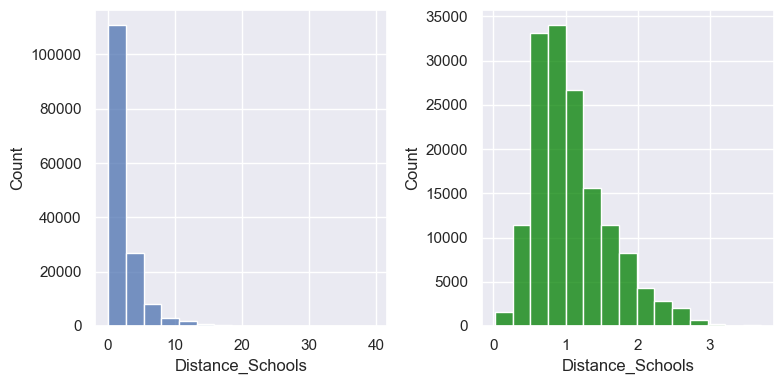

In [ ]:
data = np.log(df.Distance_Schools+1)
# data = np.log(df.Rating_Schools+1)
# data = df.Rating_Schools
print(data.min(), data.max())
# lib.visual_hist_box_2(data)
lib.visual_compare_hist(df.Distance_Schools, data)

Признак 'Distance_Schools' сделаем в логарифмическом масштабе

1.0 10.0


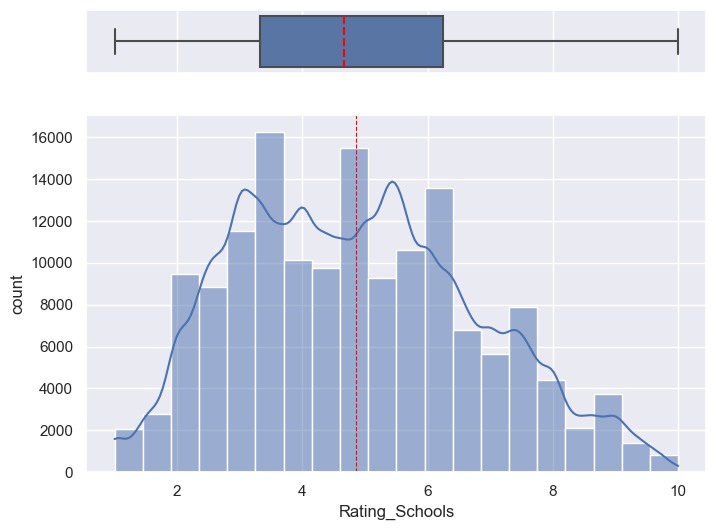

In [ ]:
data = df.Rating_Schools
print(data.min(), data.max())
my_lib.visual_hist_box_2(data)

---

### 4.6 EDA, признак 'baths', 'beds'.

- Количественный, непрерывный  baths (округлим в 0.5, те что больше 5 округлим в целые)
- Количественный, порядковый  beds (округлим в целые числа)

Удалим записи, которые содержат 2 и более пустых значений в строке

In [ ]:
# # df.isna().sum()
# # status              22520
# # baths               20825
# # beds                17624
# # remodeledYear        9772

# Подсчет числа пропущенных значений в каждой строке
mask = df.isna().sum(axis=1) >= 2
print('Число записей для удаления, содержащиеся 2 и более NaN в строке: ', mask.sum())
df = df[~mask]
df[['status', 'baths', 'beds', 'remodeledYear']].isna().sum()


Число записей для удаления, содержащиеся 2 и более NaN в строке:  10853


status           14113
baths             9845
beds              6127
remodeledYear     2614
dtype: int64

In [ ]:
# 1. Создаем функцию для заполнения пропущенных значений медианой
fill_median = lambda x: x.fillna(x.median())

print(df[['beds', 'baths']].isna().sum())

# 2. Заполняем пропущенные значения в 'sqft' и 'lotsize' медианой
# для каждой группы 'propertyType' и 'stories'
data_group = df.groupby(['state', 'city', 'propertyType', 'stories'])
df['beds'] = data_group['beds'].transform(fill_median)
df['baths'] = data_group['baths'].transform(fill_median)

# beds     1423
# baths     104

data_group = df.groupby(['propertyType', 'stories'])
df['beds'] = data_group['beds'].transform(fill_median)
df['baths'] = data_group['baths'].transform(fill_median)

print(df[['beds', 'baths']].isna().sum())
# beds     1409
# baths       0
df.dropna(subset=['beds'], inplace=True)
print(df[['beds', 'baths']].isna().sum())


beds     6127
baths    9845
dtype: int64
beds     1139
baths       0
dtype: int64
beds     0
baths    0
dtype: int64


Округлим в целое число, число спален превыщающий 6 сделаем как 7.

In [ ]:
df.beds = df.beds.round().astype('int')
df.beds[df.beds > 6] = 7
df.beds.value_counts()

beds
3    67621
4    41598
2    17678
5     9959
6     2114
7      968
1      449
0       86
Name: count, dtype: int64

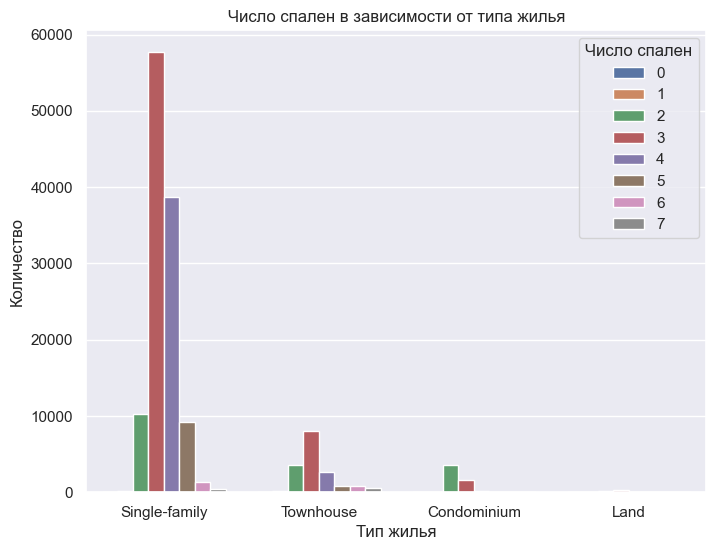

In [ ]:
# df.groupby(by=['propertyType', 'beds'])['beds'].count().plot.bar(color=['blue', 'green', 'red', 'orange', 'purple', 'yellow'])

sns.countplot(x='propertyType', hue='beds', data=df)
plt.title('Число спален в зависимости от типа жилья')
plt.xlabel('Тип жилья')
plt.ylabel('Количество')
# plt.xticks(rotation=45)
plt.legend(title='Число спален')
plt.show()


- В частных домах преобладает с большим числом спален.
- У земельных участков естественно ноль спален

- Хотя известно об особеностях размера ванной, сделаем проще для анализа данных.
- Округлим в целое, все что больше 5 приравняем к 5.
- Объекты, что относится к земельному участку, обнулим число ванной.

In [ ]:
# df.baths.value_counts().sort_index()

# Округление значений столбца "baths" до целых чисел
df['baths'] = df['baths'].round().astype(int)

# Замена значений больше 5 на 5
df.loc[df['baths'] > 5, 'baths'] = 5

# Обнуление значений "baths" для объектов, относящихся к земельным участкам
df.loc[df['propertyType'] == 'Land', 'baths'] = 0

# Вывод количества объектов для каждого значения "baths" после обработки
print(df['baths'].value_counts())


baths
2    73339
3    39728
4    16862
1     6326
5     3614
0      604
Name: count, dtype: int64


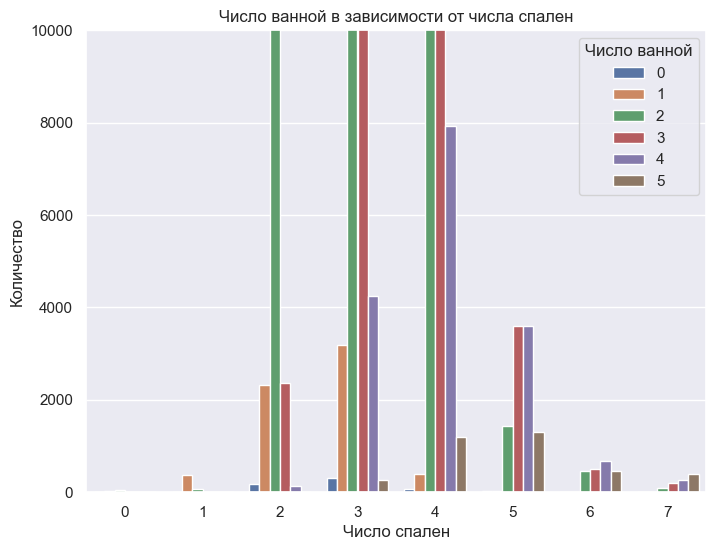

In [ ]:
sns.countplot(x='beds', hue='baths', data=df)
plt.title('Число ванной в зависимости от числа спален')
plt.xlabel('Число спален')
plt.ylabel('Количество')
# plt.xticks(rotation=45)
plt.legend(title='Число ванной')
plt.ylim((0,10000))
plt.show()


- С ростом числа спален растет и число ванной 5 и более.

---

### 4.6 EDA, признак 'remodeledYear'.

- Количественный, порядковый

Выбор заполнения логичней по частоте, но что привязать к какой группе?
Может быть лучше к месту, где основные постройки были возведены в эти года?
Но ведь процесс стройки зданий идет непрерывно. Много вопросов.
Чтоб не засорять данные неверными данными, принято удалить пустые значения.

Переменуем столбец как 'lastYear'.

In [ ]:
df.dropna(subset=['remodeledYear'], inplace=True)
df.rename(columns={'remodeledYear': 'lastYear'}, inplace=True)
df.lastYear = df.lastYear.astype(int)
df.lastYear.dtype

dtype('int32')

- Переводим в категориальный признак 'lastYear'

In [ ]:
# Создание категориального признака на основе года постройки
df['lastYear_category'] = pd.cut(df['lastYear'],
                        bins=[0, 1935, 1967, 1997, 2008, 2017, 2024],
                        labels=['<1936', '1936-1967', '1968-1997', '1998-2008', '2011-2017', '2019-2024'])


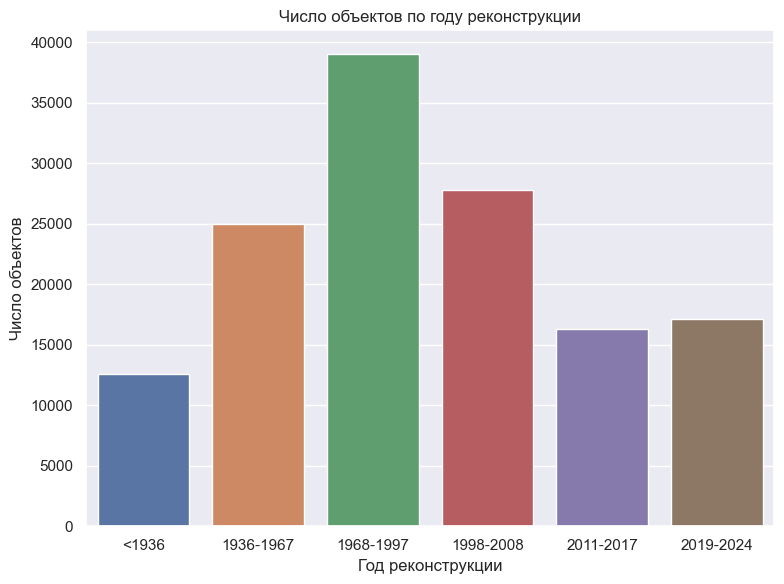

In [ ]:
sns.countplot(x='lastYear_category', data=df)
plt.title('Число объектов по году реконструкции')
plt.xlabel('Год реконструкции')
plt.ylabel('Число объектов')
# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


- Распределение числа объектов по интервалу времени хорошее.

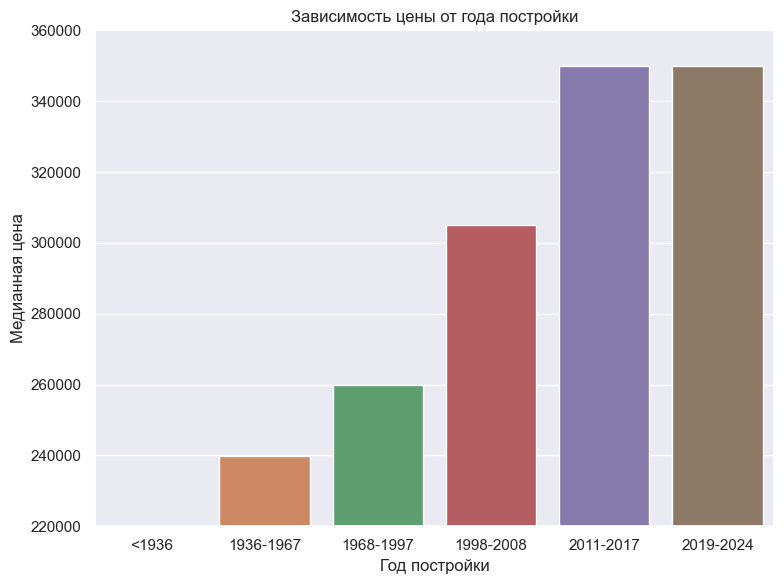

In [ ]:
# Группировка данных по году постройки и вычисление медианы цены
price_by_year = df.groupby('lastYear_category')['target'].median().reset_index()

sns.barplot(x='lastYear_category', y='target', data=price_by_year)
plt.title('Зависимость цены от года постройки')
plt.xlabel('Год постройки')
plt.ylabel('Медианная цена')
plt.ylim((220000,360000))
plt.tight_layout()
plt.show()


- Новые(перестроенные, отремонтированные) дома в цене выше.

---

### 4.7 EDA, признак 'status'.

- Категориальный, номинальный.
- ['Active', 'Pending', 'New', 'Foreclosure', 'Other']

Т.к. пустых значений много, и нет косвенных признаков, что связывало бы с этим признаком для заполнения, заполним значением 'Other'.

In [ ]:
# Заполнение пропущенных значений
df['status'].fillna('Other', inplace=True)

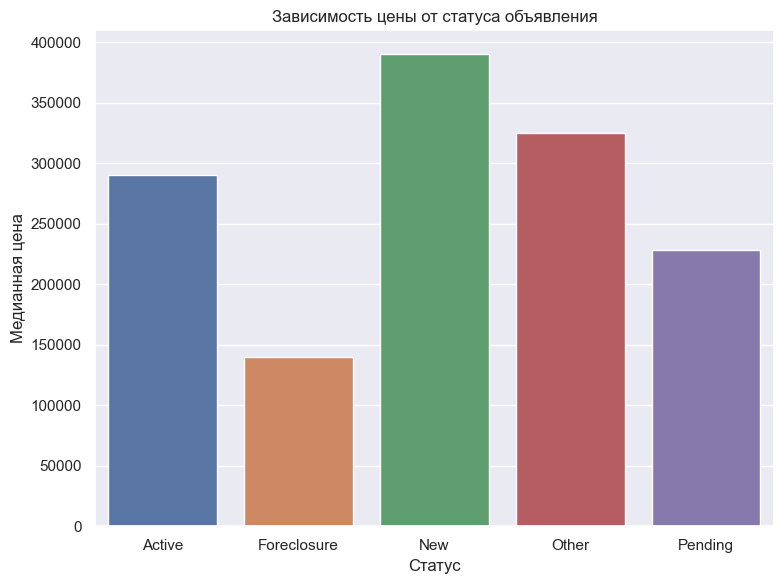

In [ ]:
# Группировка данных по году постройки и вычисление медианы цены
price_by_year = df.groupby('status')['target'].median().reset_index()

sns.barplot(x='status', y='target', data=price_by_year)
plt.title('Зависимость цены от статуса объявления')
plt.xlabel('Статус')
plt.ylabel('Медианная цена')
# plt.ylim((220000,360000))
plt.tight_layout()
plt.show()


- Новостройки в цене выше.
- Аукционные, арестованные дешевле.

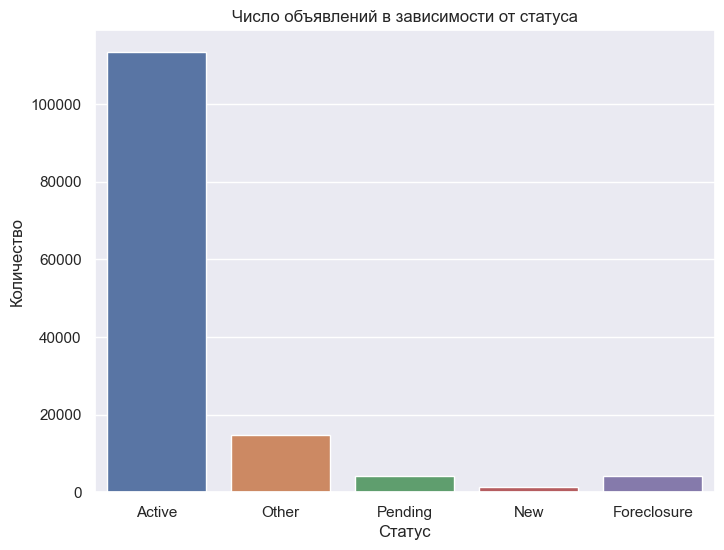

In [ ]:
sns.countplot(x='status', data=df)
plt.title('Число объявлений в зависимости от статуса')
plt.xlabel('Статус')
plt.ylabel('Количество')
plt.show()


- "Active" будет самой распространенной категорией, т.к. это означает, что объявление все еще активно и недвижимость еще не продана или не снята с рынка. Это естественно, поскольку обычно занимает некоторое время найти покупателя.

- Посмотрим зависимость цены за фут от штата государства.

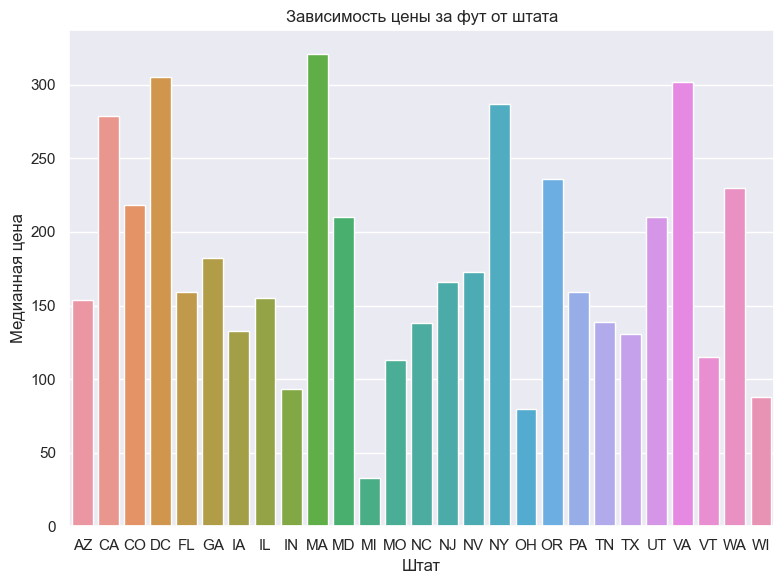

In [ ]:
# Группировка данных по году постройки и вычисление медианы цены
price_by_state = df.groupby('state')['price_sqft'].median().reset_index()

sns.barplot(x='state', y='price_sqft', data=price_by_state)
plt.title('Зависимость цены за фут от штата')
plt.xlabel('Штат')
plt.ylabel('Медианная цена')
# plt.ylim((220000,360000))
plt.tight_layout()
plt.show()


- Дороже всех в штате Массачусетс

In [ ]:
print('# of table: ', df.shape)
print('\nNull data:')
print(df.isna().sum())


# of table:  (137859, 18)

Null data:
status               0
propertyType         0
baths                0
sqft                 0
beds                 0
state                0
stories              0
target               0
private_pool         0
city                 0
lastYear             0
cooling              0
garage               0
lotsize              0
price_sqft           0
Rating_Schools       0
Distance_Schools     0
lastYear_category    0
dtype: int64


- Наши данные заполнены.

In [ ]:
column_drop = ['lastYear']
df.drop(columns=column_drop, inplace=True)

print(f'Число дубликатов: {df.duplicated().sum()}')
df.drop_duplicates(inplace=True, ignore_index=True)

sort_columns = [
    'status',
    'state', 'city',
    'propertyType', 'stories',
    'beds', 'baths',
    'sqft', 'lotsize','price_sqft',
    'private_pool', 'cooling', 'garage',
    'Rating_Schools', 'Distance_Schools', 'lastYear_category',
    'target'
]

df = df[sort_columns] # упорядочим по смыслу
# Replace values to avoid column name conflicts during feature encoding
df.stories.replace('Land', 'None Story', inplace=True)

# Переименуем столбцы
rename_dict = {'Rating_Schools': 'rating', 'Distance_Schools': 'distance', 'lastYear_category':'rangeYears'}
df.rename(columns=rename_dict,inplace=True)

# Заменяем значение '<1936' на 'less_1935'
# ValueError: feature_names must be string, and may not contain [, ] or <
df['rangeYears'] = df['rangeYears'].replace('<1936', 'less_1935')

# Сохраняем очищенную таблицу в отдельном файле
file_name = 'CleanedData_9'
df.to_csv(f'data/{file_name}.zip', index=False, compression=dict(method='zip', archive_name=file_name+'.csv'))
# df = pd.read_csv(f'data/{file_name}.zip')
print(f'{file_name}, {df.shape=}')

# Число дубликатов: 14
# CleanedData_9, df.shape=(137845, 17)


CleanedData_9, df.shape=(137845, 17)


In [5]:
# Read file
file_name = 'CleanedData_9'

# # Прочитаем данные из Colab
df = pd.read_csv(DATA_DIR+file_name+'.zip')
# local
# df = pd.read_csv(f'data/{file_name}.zip')
print(f'{file_name}, {df.shape=}')

CleanedData_9, df.shape=(137845, 17)


---

## 5. Обработка данных
- Кодирование признаков
- Конструирование и отбор признаков, понижение признаков

In [6]:
target_feature = 'target' # Convert with Box-cox , regresion model
categorical_features = ['state', 'city', 'status', 'propertyType', 'stories', 'rangeYears']
ordinal_features = [ 'beds', 'baths', ]
numerical_features = ['sqft', 'lotsize', 'price_sqft', 'rating',
                      'distance', # convert to log_scale
                      ]
binary_features = ['private_pool', 'cooling',  'garage' ]

df.sample(3)

,status,state,city,propertyType,stories,beds,baths,sqft,lotsize,price_sqft,private_pool,cooling,garage,rating,distance,rangeYears,target
42917,Other,TX,Houston,Single-family,Single Story,4,2,2030.0,9334.0,241.0,0,1,1,5.67,2.23,1968-1997,489000
94994,Active,TX,Mcallen,Single-family,Two Story,4,5,3057.0,11325.6,104.0,0,1,1,4.67,1.32,1968-1997,319100
26203,Active,TN,Johnson City,Townhouse,Two Story,2,3,512.0,435.0,186.0,0,1,0,7.00,3.27,1998-2008,95000


- Визуальный анализ числовых признаков.

,count,mean,std,min,25%,50%,75%,max
sqft,137845.0,2020.782,806.928,300.00,1404.00,1875.00,2496.00,4754.00
lotsize,137845.0,7897.940,4939.628,1.00,4791.00,7135.00,10018.00,27225.00
price_sqft,137845.0,168.484,86.316,0.00,111.00,149.00,210.00,462.00
rating,137845.0,4.848,1.927,1.00,3.33,4.67,6.20,10.00
distance,137845.0,2.456,2.657,0.02,1.03,1.63,2.82,39.69


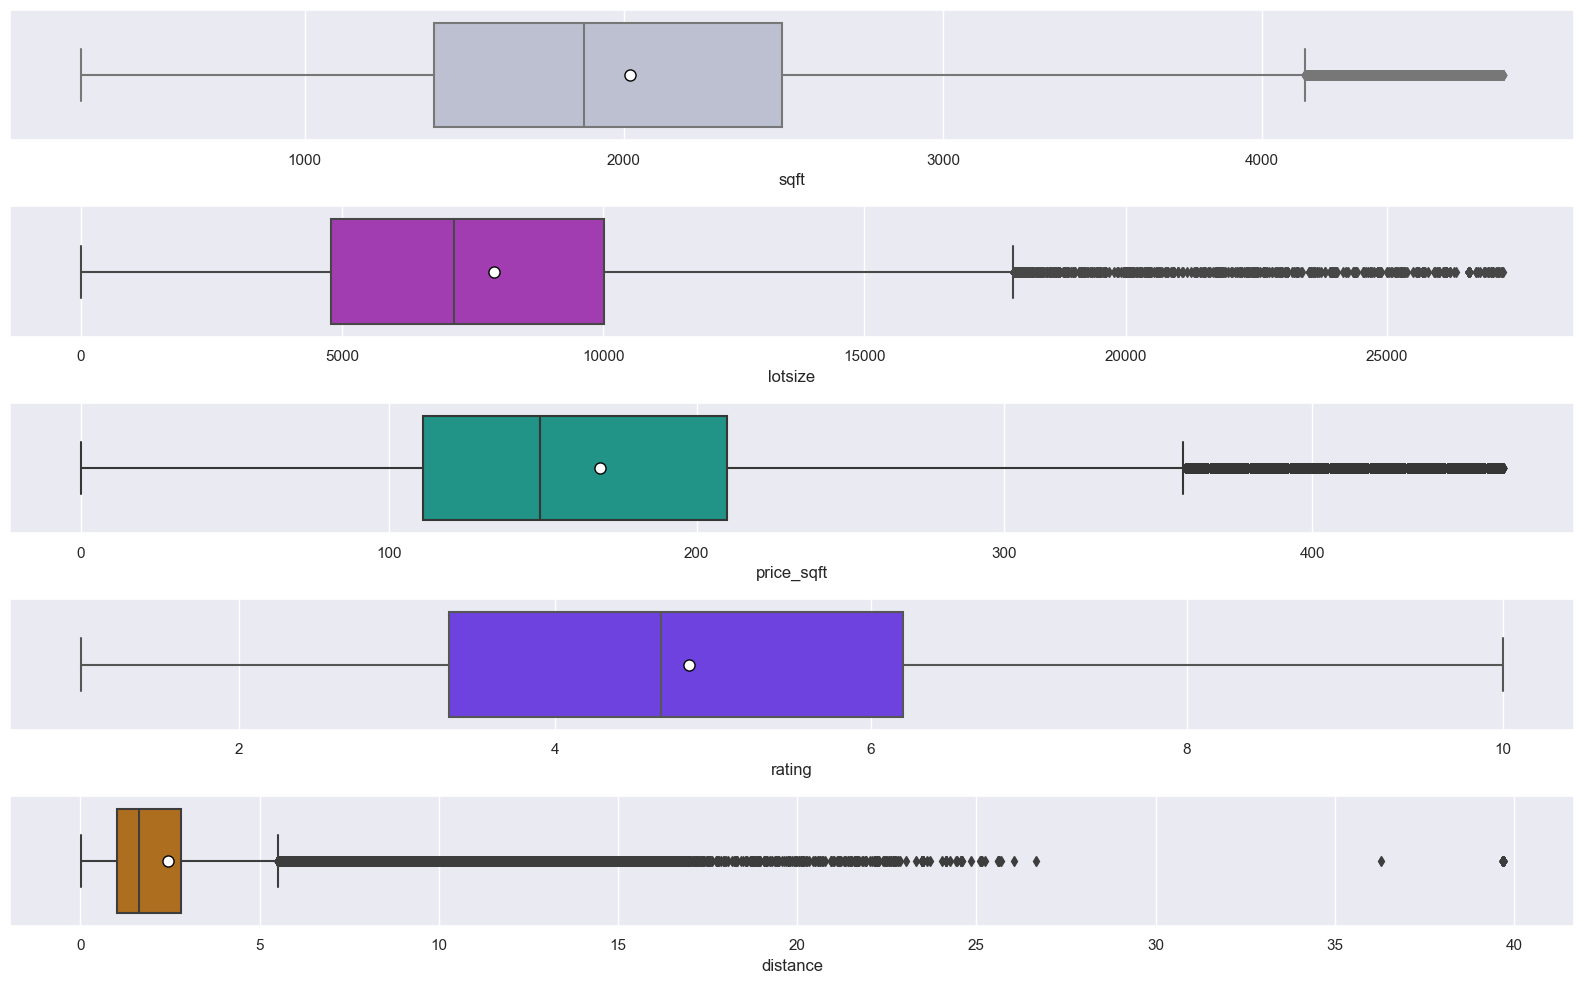

In [ ]:
display(df[numerical_features].describe().T.round(3))

len_columns = len(numerical_features)
fig, axes = plt.subplots(len_columns,1 , figsize=(16, 2 * len_columns))

for i, column in enumerate(numerical_features):
    sns.boxplot(data= df, x=column, ax=axes[i], color=my_lib.rand_rgb(),
                showmeans=True, meanprops={'marker':'o',
                       'markerfacecolor':'white',
                       'markeredgecolor':'black',
                       'markersize':'8'})
    #axes[i].set_title(f'Box Plot for {column}')

plt.tight_layout()
plt.show()

- Визуальный анализ категориальных признаков.

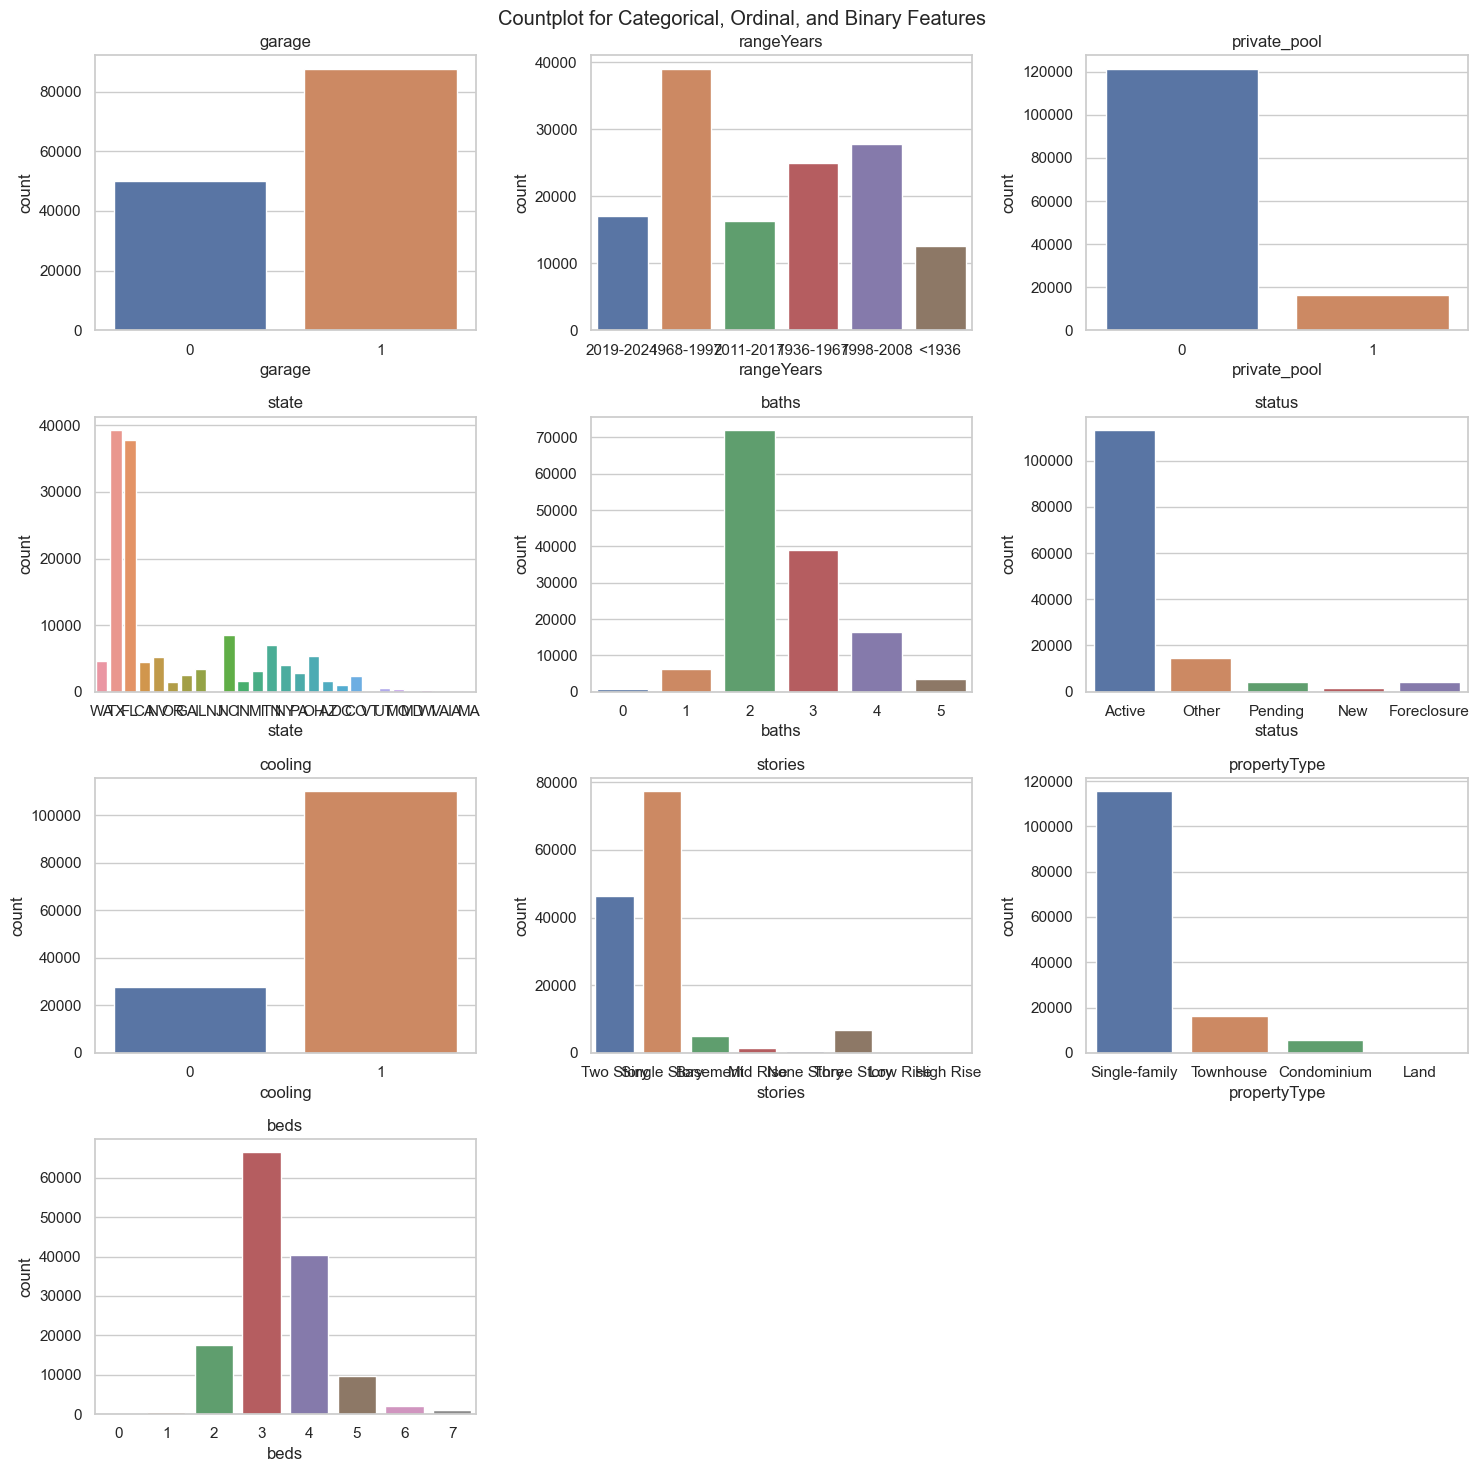

In [ ]:
categorical_columns = categorical_features + ordinal_features + binary_features
categorical_columns = set(categorical_columns) - {'city'}

sns.set(style="whitegrid")

plt.figure(figsize=(15, 15))
plt.suptitle('Countplot for Categorical, Ordinal, and Binary Features')

for i, column in enumerate(categorical_columns, 1):
    plt.subplot(4, 3, i)
    sns.countplot(x=column, data=df)
    plt.title(column)

plt.tight_layout()
plt.show()

### 5.1 Кодирование данных

In [9]:
# Функция для трансформации данных
def process_transform(data, feat_transform):

    # Full Encoding
    # # OneHotEncoding
    # encoded_categorical_features = pd.get_dummies(data[feat_transform['CategEncoding']], dtype='int8')

    # mini encoding
    # Порог для использования OneHotEncoder или BinaryEncoder
    threshold = 10
    one_hot_features, multibinary_features = [], []

    # Определение признаков, которые будут закодированы с использованием OneHotEncoder или BinaryEncoder
    for col in feat_transform['CategEncoding']:
        if data[col].nunique() < threshold:
            one_hot_features.append(col)
        else:
            multibinary_features.append(col)

    one_hot_encoded_data = ce.OneHotEncoder(use_cat_names=True).fit_transform(data[one_hot_features])
    multibinary_encoded_data = ce.BinaryEncoder().fit_transform(data[multibinary_features])
    # Объединение закодированных признаков обратно в исходный DataFrame
    encoded_categorical_data = pd.concat([one_hot_encoded_data, multibinary_encoded_data], axis=1)

    # LabelEncoder
    label_encoder = LabelEncoder()
    encoded_ordinal_data = data[feat_transform['LabelEncoder']].apply(label_encoder.fit_transform)

    # Logarithmic transformation for numerical features
    log_scaled_data = data[feat_transform['log_scale']].apply(np.log1p) # FunctionTransformer(np.log1p)

    # Binary encoding for binary features
    binary_features = feat_transform['binary_features']
    for feature in feat_transform['binary_features']:
        if data[feature].dtype == 'object':
            data[feature] = data[feature].str.lower().map({'yes': 1, 'no': 0}).astype(int)

    # Combine all data
    return pd.concat([encoded_categorical_data, encoded_ordinal_data,
                            data[feat_transform['numerical_features']],
                            log_scaled_data, data[binary_features]], axis=1)

In [10]:
feat_transform = {
    'CategEncoding': ['state', 'city', 'status', 'propertyType', 'stories', 'rangeYears'],
    'LabelEncoder': ['beds', 'baths'],
    'numerical_features' : ['sqft', 'lotsize', 'price_sqft', 'rating'],
    'log_scale': ['distance'],
    'binary_features': ['private_pool', 'cooling',  'garage' ],
}

X_full = process_transform(df.drop('target', axis=1), feat_transform)

# Data after power transformation (Box-Cox)
pow_trans_bx = PowerTransformer(method="box-cox", standardize=False)
y_full = pow_trans_bx.fit_transform(df['target'].values.reshape(-1, 1))
lambda_box_cox = pow_trans_bx.lambdas_

filepath = PICKLE_DIR+"transformer_box_cox.pkl"
with open(filepath, "wb") as f:
    pickle.dump(pow_trans_bx, f)

print(X_full.shape)
X_full.sample(3)

(137845, 47)


,status_Active,status_Other,status_Pending,status_New,status_Foreclosure,propertyType_Single-family,propertyType_Townhouse,propertyType_Condominium,propertyType_Land,stories_Two Story,...,beds,baths,sqft,lotsize,price_sqft,rating,distance,private_pool,cooling,garage
77486,1,0,0,0,0,1,0,0,0,0,...,4,2,1803.0,14375.0,197.0,6.17,1.015231,0,1,0
117030,0,1,0,0,0,1,0,0,0,0,...,3,2,1900.0,10497.0,161.0,5.33,0.693147,0,1,1
41914,1,0,0,0,0,1,0,0,0,0,...,2,2,1000.0,10895.0,155.0,5.60,1.232560,0,1,0


In [11]:
# Загрузка сохраненного преобразователя
with open(filepath, "rb") as f:
    pow_trans_bx = pickle.load(f)

# Преобразование обратно в исходное пространство
y_reverse = pow_trans_bx.inverse_transform(y_full).round(0).astype(int)

comparison_df = pd.DataFrame({
    'Original_Target': df['target'].values.astype(int),
    'Reversed_Target': y_reverse.flatten()
})

# Сравнение двух серий
if comparison_df['Original_Target'].equals(comparison_df['Reversed_Target']):
    print('Реверс целевого признака, закодированных по методу Бокса-Кокс, идентичен исходному')

Реверс целевого признака, закодированных по методу Бокса-Кокс, идентичен исходному


### 5.2. Оценка мультиколлинеарности признаков

- Коэффициент инфляции дисперсии или **VIF** — мера помогает обнаружить степень мультиколлинеарности в множественной регрессионной модели.
```py
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["feature"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

# предположим, data — это DataFrame с предикторами
vif_info = calculate_vif(data)
high_vif = vif_info[vif_info['VIF'] > 10]  # Установите порог, например 10
data = data.drop(columns=high_vif['feature'])
```

- **PLS** — метод сокращает размерность данных, проецируя предикторы на меньшее количество измерений, при этом стараясь сохранить те, которые наиболее сильно коррелируют с зависимой переменной.
```py
from sklearn.cross_decomposition import PLSRegression
pls = PLSRegression(n_components=3)
pls.fit(X, y)
```

- Устранение мультиколлинеарности можно путем выбора подмножества переменных, основанного на их значимости или вкладе в объяснение зависимой переменной на основе их статистической значимости.

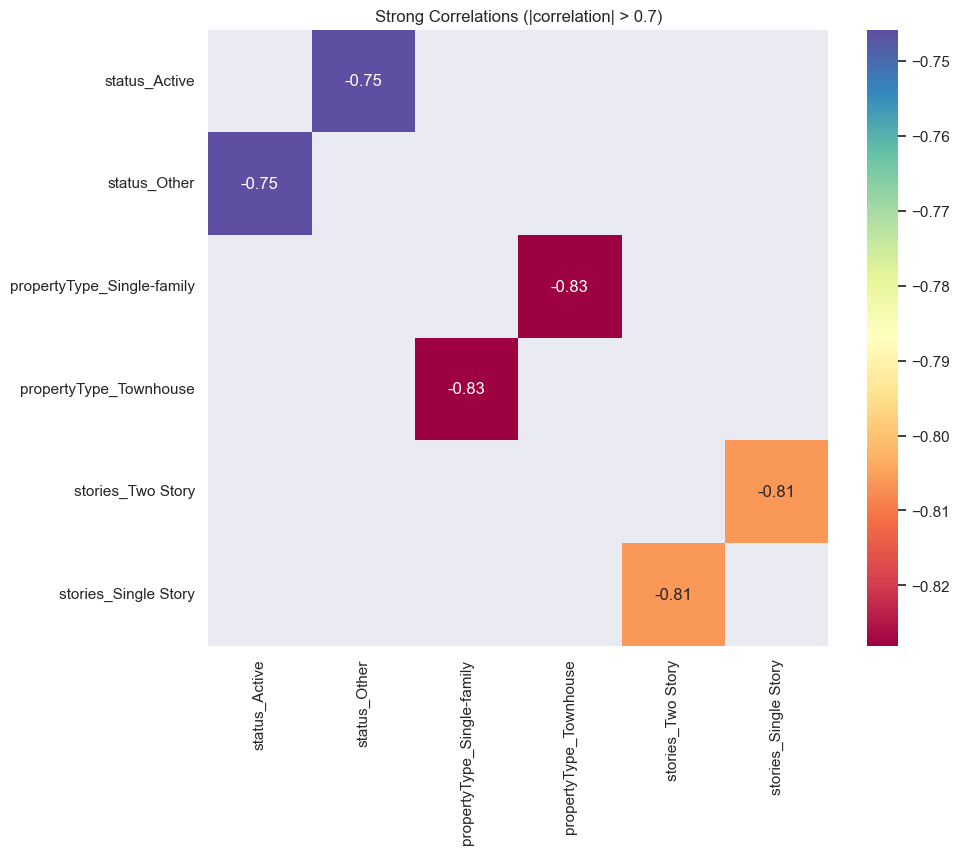

In [ ]:
# mini encoding
data = X_full.corr(method='pearson')

# Фильтрация корреляционной матрицы
strong_correlation = data[(data.abs() > 0.7) & (data != 1)]

# Удаление столбцов, которые не коррелируют сильно
strong_correlation = strong_correlation.dropna(axis=1, how='all')
strong_correlation = strong_correlation.dropna(axis=0, how='all')

plt.figure(figsize=(10, 8))
sns.heatmap(strong_correlation, annot=True, cmap='Spectral', fmt=".2f")
plt.title('Strong Correlations (|correlation| > 0.7)')
plt.show()

- Статусы 'Active' и 'Other' коллинеарны, можно было объединить их в одну. Но тогда оно будет большинство, и ,в принципе, можно было бы удалить признак 'status'.

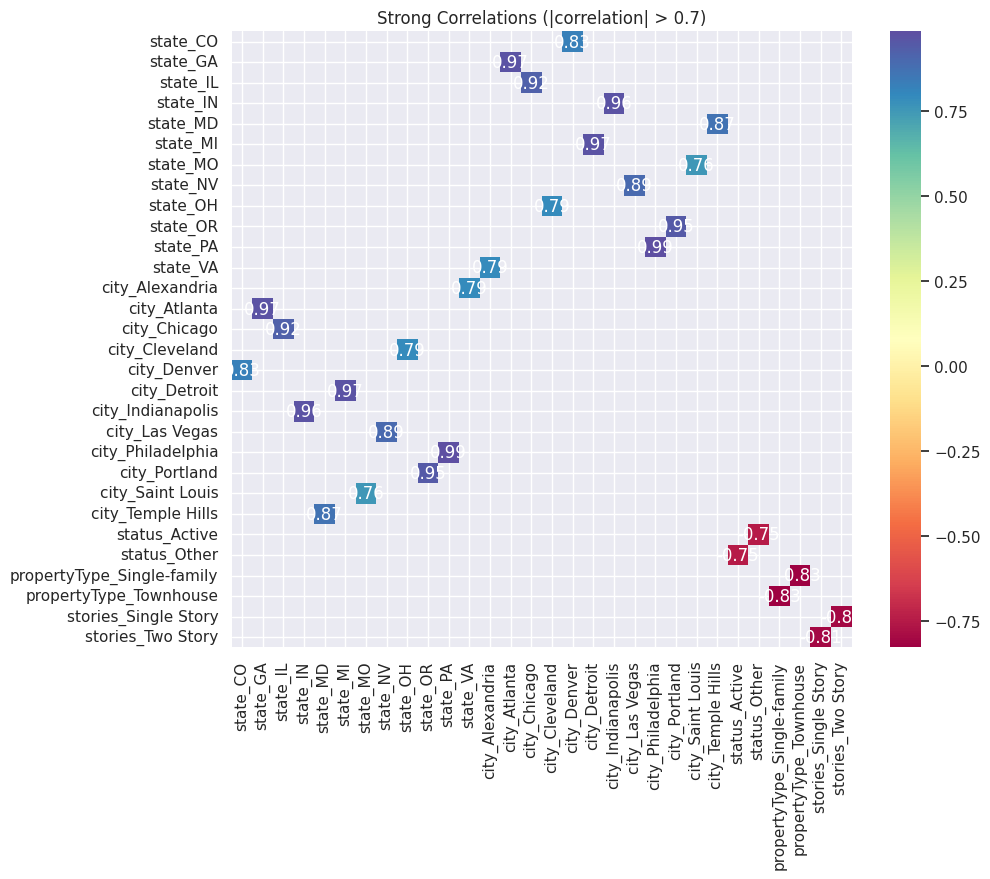

In [ ]:
# # Full encoding
# data = X_full.corr(method='pearson')

# # Фильтрация корреляционной матрицы
# strong_correlation = data[(data.abs() > 0.7) & (data != 1)]

# # Удаление столбцов, которые не коррелируют сильно
# strong_correlation = strong_correlation.dropna(axis=1, how='all')
# strong_correlation = strong_correlation.dropna(axis=0, how='all')

# plt.figure(figsize=(10, 8))
# sns.heatmap(strong_correlation, annot=True, cmap='Spectral', fmt=".2f")
# plt.title('Strong Correlations (|correlation| > 0.7)')
# plt.show()

- На 327 признаков не так много коррелированых признаков.

## 6. Моделирование и оценка результатов

Для оценки качества модели будут использоваться следующие метрики:
- **MAE (Mean Absolute Error)** – среднее арифметическое модуля отклонения предсказанного значения от реального. Идеально --> 0
- **RMSE (Root Mean Squared Error)** - это метрика, которая измеряет среднеквадратичное отклонение между фактическими значениями и прогнозируемыми значениями в модели.  Идеально --> 0
- **MAPE (Mean Absolute Percent Error)** - на сколько процентов в среднем предсказание модели отклоняется от реального значения. Идеально --> 0
- **$R^2$** - коэффициент детерминации, который показывает, какую долю дисперсии зависимой переменной объясняет модель. Идеально --> 1


### 6.1 Baseline model.

- Разобьем на тренировочные и тестовые.
- Заскалируем числовые признаки для линейных регрессоров.

In [12]:
num_features = ['sqft', 'lotsize', 'price_sqft', 'rating', 'distance']
cat_features = list(set(X_full.columns) - set(num_features))

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.25, random_state=77)

ssc = StandardScaler()
X_train_scaled = np.hstack((ssc.fit_transform(X_train[num_features]), X_train[cat_features]))
X_test_scaled  = np.hstack((ssc.transform(X_test[num_features]), X_test[cat_features]))

(X_train.shape, X_test.shape, X_train_scaled.shape, X_test_scaled.shape, y_full.shape)

((103383, 47), (34462, 47), (103383, 47), (34462, 47), (137845, 1))

In [13]:
X_tr, X_te = X_train_scaled, X_test_scaled
model = LinearRegression().fit(X_tr, y_train)
print(f'\nМетрики модели LinearRegression.')
# _,_=lib.metric_mae_boxcox(y_train, model.predict(X_train), y_test, model.predict(X_test), lambda_box_cox)
my_lib.show_metrics_boxcox(y_train, model.predict(X_tr), y_test, model.predict(X_te), lambda_box_cox)

#===========Full OneHotEncoding==========================
# Метрики модели LinearRegression.
# MAE -  train:            29274.058
# MAPE - train:              289.638
# RMSE - train:            15304.781
# R_2 -  train:                0.995

# MAE -  test:            29291.665
# MAPE - test:              148.136
# RMSE - test:            15429.793
# R_2  - test:                0.995

#===============mini without scaler===========

# Метрики модели LinearRegression.
# MAE -  train:            30978.823
# MAPE - train:              283.840
# RMSE - train:            15681.830
# R_2 -  train:                0.994

# MAE -  test:            30974.765
# MAPE - test:              165.446
# RMSE - test:            15684.734
# R_2  - test:                0.995


Метрики модели LinearRegression.
MAE -  train:            30978.823
MAPE - train:              283.840
RMSE - train:            48179.044
R_2 -  train:                0.948

MAE -  test:            30974.765
MAPE - test:              165.446
RMSE - test:            47942.957
R_2  - test:                0.949


### 6.2 Отбор признаков

Отбор признаков – это процесс выбора признаков, имеющих наиболее тесные взаимосвязи с целевой переменной.

Присутствие в данных неинформативных признаков приводит к снижению точности многих моделей.

Методы:
1. Одномерный отбор признаков, класс **SelectKBest**.
Признаки, имеющие наиболее выраженную взаимосвязь с целевой переменной, могут быть отобраны с помощью статистических критериев.

2. Рекурсивное исключение признаков, **recursive feature elimination, RFE**
Модель обучается на исходном наборе признаков и оценивает их значимость, затем исключается один или несколько наименее значимых признаков, модель обучается на оставшихся признаках, и так далее, пока не останется заданное количество лучших признаков.
```py
from sklearn.feature_selection import RFE
...
fit = RFE(LogisticRegression(), 3).fit(X, Y)
print("Num Features: %d") % fit.n_features_
print("Selected Features: %s") % fit.support_
print("Feature Ranking: %s") % fit.ranking_
```

3. Метод главных компонент, **(principal component analysis, PCA)**
PCA  позволяет уменьшить размерность данных с помощью преобразования на основе линейной алгебры. Задаем требуемое количество измерений (главных компонент) в результирующих данных.

4. Отбор на основе важности признаков
Ансамблевые алгоритмы на основе деревьев решений, такие как случайный лес (random forest), позволяют оценить важность признаков.
```py
from sklearn.ensemble import ExtraTreesClassifier
...

print(ExtraTreesClassifier().fit(X, Y).feature_importances_)
```

Отбор признаков перед моделированием обеспечивает три следующих преимущества:

- Уменьшение переобучения. Чем меньше избыточных данных, тем меньше возможностей для модели принимать решения на основе «шума».
- Повышение точности. Чем меньше противоречивых данных, тем выше точность.
- Сокращение времени обучения. Чем меньше данных, тем быстрее обучается модель.


### 6.2 Оценка значимости и отбор признаков

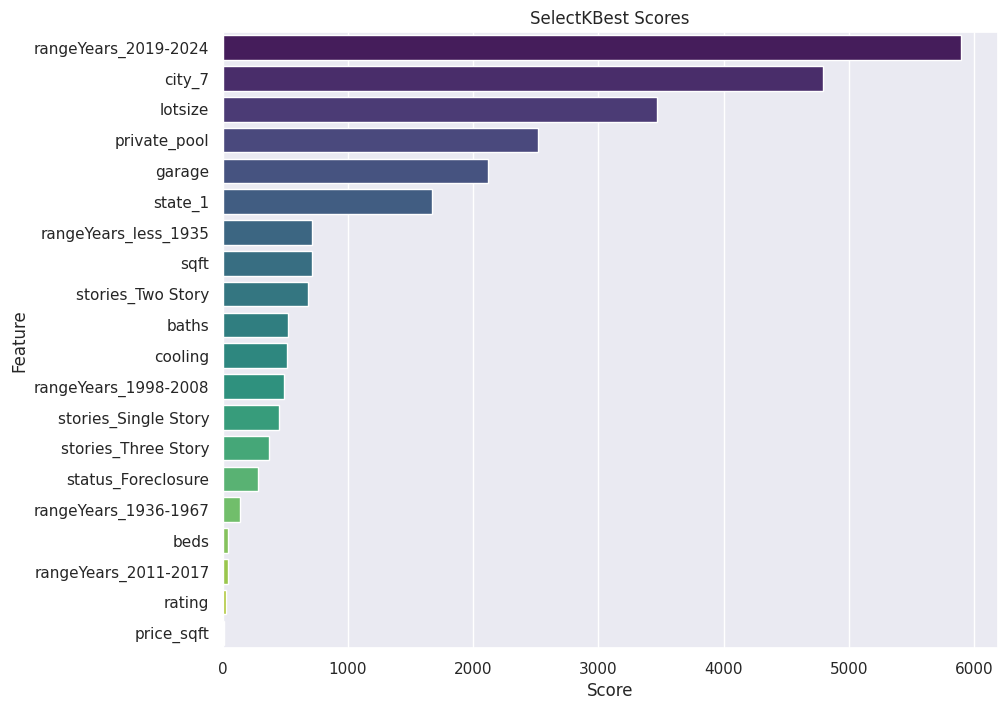

In [19]:
k=20
kbest = SelectKBest(score_func=f_regression,k=k).fit(X_full, y_full)
# kbest_features = kbest.transform(X)
kbest_features = kbest.get_feature_names_out()
kbest_scores = kbest.scores_[:k]
data = (pd.DataFrame(
            {'Feature': kbest_features, 'Score': kbest_scores})
            .sort_values(by='Score', ascending=False)
)

plt.figure(figsize=(10, 8))
sns.barplot(x='Score', y='Feature', data=data, palette='viridis')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.title('SelectKBest Scores')
plt.show()


- Свежеотремонитрованные дома хорошо предсказывают цену.
- Как ни странно, наличие бассейна в несбалансированном признаке помогают предсказывать цену.
- Размер участка отлично показывают

## 6.3 Отбор признаков. Статистические тесты.

- Статистический тест хи-квадрат для категориальных признаков

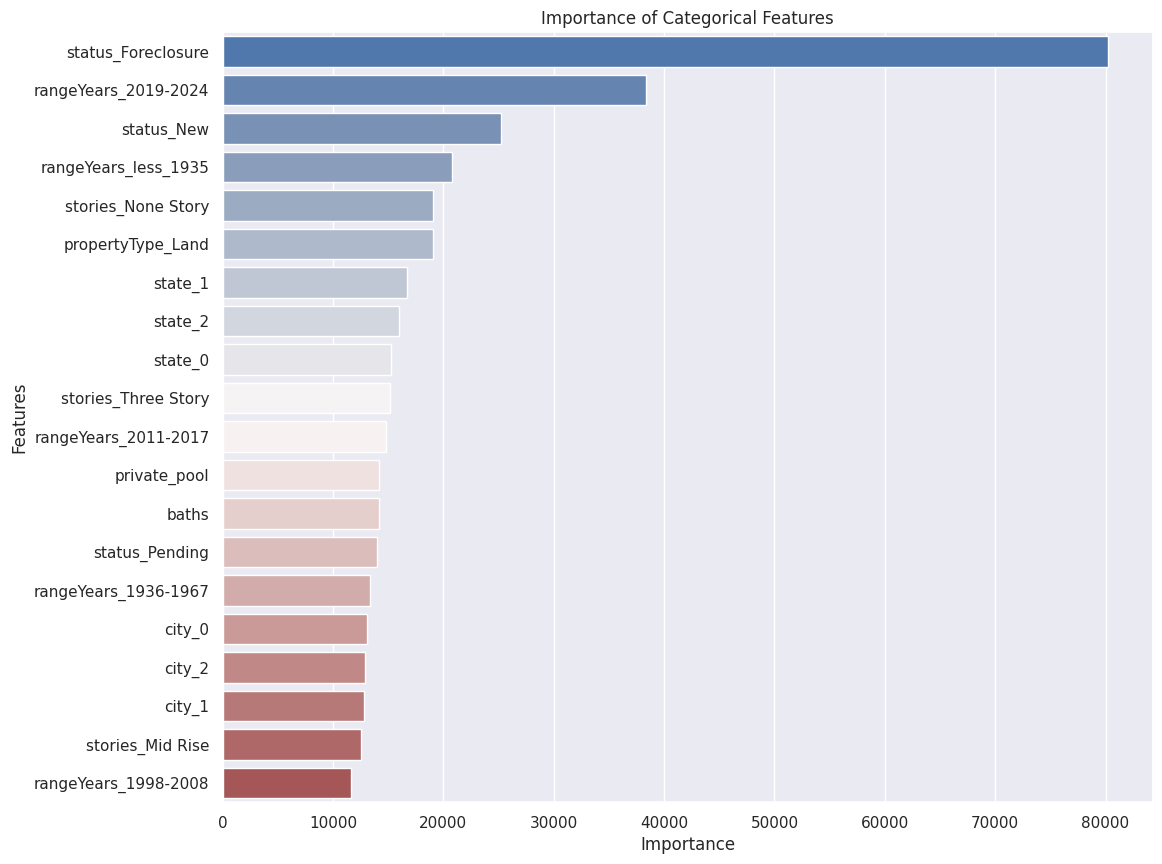

In [22]:
# Выполняем тест хи-квадрат
chi2_test = chi2(X_full[cat_features], df.target) # pow_trans_bx.inverse_transform(y_full).round(0).astype(int)
importance_cat_chi2 = pd.Series(chi2_test[0], index=cat_features).sort_values(ascending=False)

# Визуализация важности категориальных признаков
plt.figure(figsize=(12, 10))
barplot = sns.barplot(
    data=importance_cat_chi2.to_frame(name='importance').reset_index()[:20],
    x='importance',
    y='index',
    orient='h',
    palette='vlag'
)
barplot.set_title('Importance of Categorical Features', fontsize=12)
barplot.set_xlabel('Importance')
barplot.set_ylabel('Features')
plt.show()


- Данный тест показывает важность признака 'status', почти все значения статуса попадают в важность признаков.

- Статистический тест для непрерывных признаков

Text(0, 0.5, 'Признаки')

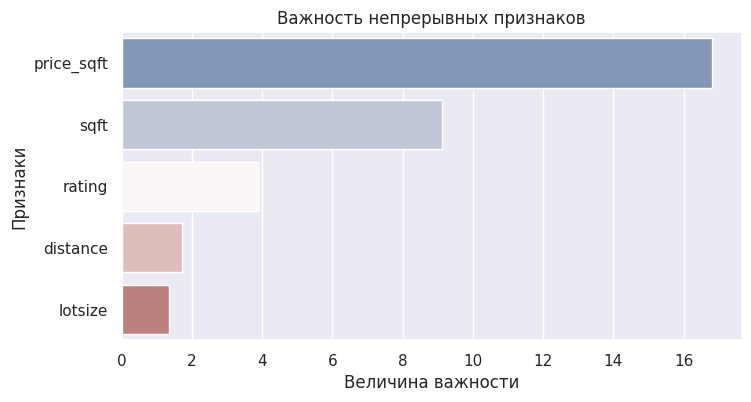

In [23]:
# Тест ANOVA
importance_num_anova = (pd.Series(
        f_classif(X_full[numerical_features], df.target)[0], index = numerical_features)
        .sort_values(ascending=False)
)

fig = plt.figure(figsize=(8, 4))
barplot = sns.barplot(
    data = importance_num_anova.to_frame(name='importance').reset_index(),
    x = 'importance',
    y = 'index',
    orient = 'h',
    palette = 'vlag'
)
barplot.set_title('Важность непрерывных признаков', fontsize = 12)
barplot.set_xlabel('Величина важности')
barplot.set_ylabel('Признаки')

- Интуитивно можно сказать что цена за площадь в футах почти всегда будет способна предсказать цену недвижимости. Странно, его как-бы следовало удалить из моделирования.

- Моделирование с отбором признака.

In [24]:
cat_f, num_f = importance_cat_chi2.index[:20].tolist(), importance_num_anova.index[:3].tolist()
X_tr, X_te, y_tr, y_te = train_test_split(X_full[cat_f + num_f], y_full, test_size=0.25, random_state=77)

print((X_tr.shape, X_te.shape))

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_f),  # Скалирование числовых признаков
        ('cat', 'passthrough', cat_f) # Оставление категориальных признаков без изменений
    ])

pipe = Pipeline([
  ('preprocessor', preprocessor),
  ('Linear', LinearRegression())
  ])
pipe.fit(X_tr, y_tr)

print(f'\nМетрики модели LinearRegression. Выбор признаков с помощью стат.тестов.')
my_lib.show_metrics_boxcox(y_tr, pipe.predict(X_tr), y_te, pipe.predict(X_te), lambda_box_cox)
# _,_=my_lib.metric_mae_boxcox(y_tr, model.predict(X_tr), y_te, model.predict(X_te), lambda_box_cox)
# Метрики модели LinearRegression. Full
# MAE -  train:            31794.424
# MAPE - train:              317.410
# RMSE - train:            48512.511
# R_2 -  train:                0.947

# MAE -  test:            31734.134
# MAPE - test:              192.754
# RMSE - test:            48453.212
# R_2  - test:                0.948

# Метрики модели LinearRegression. Выбор признаков с помощью стат.тестов. Mini
# MAE -  train:            31682.251
# MAPE - train:              261.025
# RMSE - train:            16016.724
# R_2 -  train:                0.994

# MAE -  test:            31609.011
# MAPE - test:              179.815
# RMSE - test:            16275.606
# R_2  - test:                0.994

((103383, 23), (34462, 23))

Метрики модели LinearRegression. Выбор признаков с помощью стат.тестов.
MAE -  train:            31682.080
MAPE - train:              260.794
RMSE - train:            49066.547
R_2 -  train:                0.946

MAE -  test:            31608.939
MAPE - test:              179.819
RMSE - test:            48842.806
R_2  - test:                0.947


- Качество метрики с отбором признаков хуже базовой модели.

- Подход к отбору признаков: Отбор признаков основан на статистических методах (как важность категориальных признаков и ANOVA для числовых), что может не учитывать полезность признаков для конкретной модели.
- Переобучение: Признаки, отобранные статистическими методами, могут не обобщаться хорошо на тестовый набор данных, что может привести к переобучению модели.
- Потеря информации: Отбор признаков может привести к потере информации, которая может быть важной для построения более точной модели.
- Случайность разделения данных: Различие в метриках также может быть связано с различиями в разделении данных на обучающий и тестовый наборы. Может случиться так, что во втором случае, когда используется отобранный набор признаков, данные разбиваются таким образом, что тестовый набор менее репрезентативен для обучающего набора.

### 6.3 Моделирование с различыми регрессорами.

In [25]:
metric_train, metric_test =  'mae_train', 'mae_test'
df_models = pd.DataFrame(data=None, columns=['Algorithm', metric_train, metric_test])

models_list =[
    (LinearRegression(), 'LinearRegression',True),
    (Ridge(), 'Ridge',True),
    (Lasso(), 'Lasso',True),
    (GradientBoostingRegressor(), 'GradientBoosting', False),
    (XGBRegressor(), 'XGBoost', False),
    (RandomForestRegressor(), 'RandomForest', False),
]

for model, model_name, isScaled in models_list:
    X_tr, X_te = X_train, X_test
    if isScaled:
        X_tr, X_te = X_train_scaled, X_test_scaled

    print('\nProcessing: ', model_name)
    # print(f'\nМетрики модели {pipe.named_steps["Model"].__class__.__name__}')
    model.fit(X_tr, y_tr)
    mae_tr, mae_te = my_lib.metric_mae_boxcox(y_train, model.predict(X_tr), y_test, model.predict(X_te), lambda_box_cox)
    df_models.loc[len(df_models)] = [model_name, mae_tr, mae_te]

# Processing:  LinearRegression
# MAE -  train:            29280.195
# MAE  - test:            91600.427

# Processing:  Ridge
# MAE -  train:            29275.579
# MAE  - test:            29291.887

# Processing:  Lasso
# MAE -  train:            32023.747
# MAE  - test:            31999.951

# Processing:  ElasticNet
# MAE -  train:            58441.677
# MAE  - test:            58736.163

# Processing:  GradientBoosting
# MAE -  train:             5855.915
# MAE  - test:             5884.373

# Processing:  RandomForest
# MAE -  train:              403.278
# MAE  - test:              982.084

# Processing:  XGBoost
# MAE -  train:             3378.554
# MAE  - test:             3614.704


# Processing:  LinearRegression
# MAE -  train:            30978.611
# MAE  - test:            30974.568

# Processing:  Ridge
# MAE -  train:            30979.006
# MAE  - test:            30974.799

# Processing:  Lasso
# MAE -  train:            31949.862
# MAE  - test:            31950.797

# Processing:  GradientBoosting
# MAE -  train:             5810.032
# MAE  - test:             5837.325

# Processing:  XGBoost
# MAE -  train:             3158.744
# MAE  - test:             3395.734

# Processing:  RandomForest
# MAE -  train:              417.321
# MAE  - test:             1014.236


Processing:  LinearRegression
MAE -  train:            30978.611
MAE  - test:            30974.568

Processing:  Ridge
MAE -  train:            30979.006
MAE  - test:            30974.799

Processing:  Lasso
MAE -  train:            31949.862
MAE  - test:            31950.797

Processing:  GradientBoosting
MAE -  train:             5810.032
MAE  - test:             5837.325

Processing:  XGBoost
MAE -  train:             3158.744
MAE  - test:             3395.734

Processing:  RandomForest
MAE -  train:              417.321
MAE  - test:             1014.236


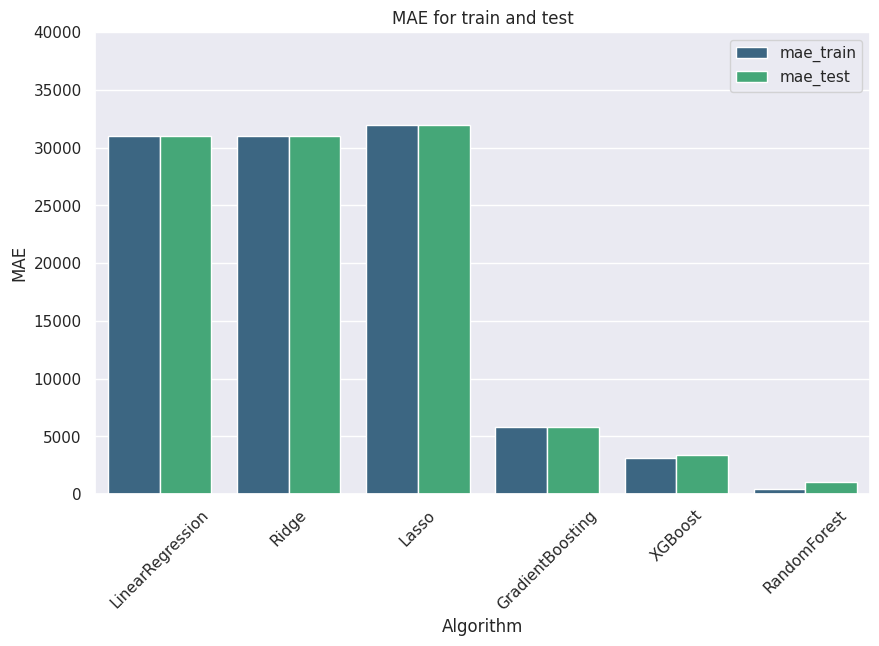

In [26]:
data=pd.melt(df_models[['Algorithm', metric_train, metric_test]], id_vars='Algorithm', var_name='variable', value_name='value')

plt.figure(figsize=(10, 6))
sns.barplot(x='Algorithm', y='value', hue='variable', data=data, palette='viridis')
plt.xlabel('Algorithm')
plt.ylabel('MAE')
plt.title('MAE for train and test')
plt.legend(title=None)
plt.ylim(0,40000)
plt.xticks(rotation=45)
plt.show()


- Отлично зарекомендовала XGBoost, RandomForest без ограничения по глубине дерева будет всегда выдавать почти идеальный ответ.

In [28]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),  # Скалирование числовых признаков
        ('cat', 'passthrough', cat_features) # Оставление категориальных признаков без изменений
    ])

k = 20
pipe = Pipeline([
  # ('Scaling', MinMaxScaler()),
  ('preprocessor', preprocessor),
  ('FeatureSelection', SelectKBest(f_regression, k=k)),
  ('Model', LinearRegression())
  ])
pipe.fit(X_train, y_train)

print(f'\nМетрики модели {pipe.named_steps["Model"].__class__.__name__}. SelectKBest ={k}')
my_lib.show_metrics_boxcox(y_train, pipe.predict(X_train), y_test, pipe.predict(X_test), lambda_box_cox)
# score_train, score_test = my_lib.metric_mae_boxcox(y_tr, pipe.predict(X_train), y_te, pipe.predict(X_test), lambda_box_cox)

# Метрики модели LinearRegression. Whithout SelectKBest
# Количество NaN значений в тестовой выборке перед обработкой: 1
# MAE -  train:            29274.658
# MAPE - train:              289.689
# RMSE - train:            45827.189
# R_2 -  train:                0.953

# MAE -  test:            29291.921
# MAPE - test:              147.973
# RMSE - test:            45658.168
# R_2  - test:                0.954

# Метрики модели LinearRegression. SelectKBest = 100
# MAE -  train:            30673.166
# MAPE - train:              287.819
# RMSE - train:            47591.812
# R_2 -  train:                0.949

# MAE -  test:            30581.529
# MAPE - test:              171.813
# RMSE - test:            47283.972
# R_2  - test:                0.950

# Метрики модели XGBRegressor. Whithout SelectKBest
# MAE -  train:             3378.551
# MAPE - train:                1.514
# RMSE - train:             5201.394
# R_2 -  train:                0.999

# MAE -  test:             3614.704
# MAPE - test:                2.196
# RMSE - test:             5617.504
# R_2  - test:                0.999


# Метрики модели XGBRegressor. SelectKBest = 100
# MAE -  train:             3379.190
# MAPE - train:                1.406
# RMSE - train:             5242.024
# R_2 -  train:                0.999

# MAE -  test:             3635.308
# MAPE - test:                2.654
# RMSE - test:             5843.798
# R_2  - test:                0.999


Метрики модели LinearRegression. SelectKBest =20
MAE -  train:            31556.107
MAPE - train:              304.378
RMSE - train:            49039.519
R_2 -  train:                0.946

MAE -  test:            31490.586
MAPE - test:              187.984
RMSE - test:            48739.069
R_2  - test:                0.947


- Перебор скалеров для числовых признаков показал, что StandardScaler лучше показывает метрики и дает небольшое улучшение качества модели.
- Отбор признаков ухудшает метрики, возможно, что данные качественные и уменьшение числа признаков сокращает информацию и не дает более точней предсказывать.

### 6.4 RandomForestRegressor и оптимизация гиперпараметров.

- RandomForestRegressor занимает очень длительный процесс обучения, возьмем данные 20 %.

In [30]:
# from scipy.stats import randint

X = X_full.sample(frac=0.3,random_state=77)
y = y_full[X.index]
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=77)

# Создаем пайплайн с предварительной обработкой данных
preprocessor = Pipeline([
    ('feature_selection', SelectKBest(f_regression))
])

# Создаем сетку перебираемых параметров для RandomForestRegressor
param_distributions = {
    # 'preprocessor__feature_selection__k': [50, 100,'all'],  # Разное количество отобранных признаков, Full
    'preprocessor__feature_selection__k': [20, 35,'all'],  # Разное количество отобранных признаков Mini
    'randomforestregressor__n_estimators': [100, 150, 200],
    'randomforestregressor__max_depth': np.arange(11, 18, 3), #randint(11, 18),
    'randomforestregressor__min_samples_leaf': [5, 10, 15]
}

# Создаем модель RandomizedSearchCV с использованием пайплайна
rand_search = RandomizedSearchCV(
    estimator=Pipeline([
        ('preprocessor', preprocessor),
        ('randomforestregressor', RandomForestRegressor(warm_start=True, random_state=77)) # n_jobs=-1,
    ]),
    param_distributions=param_distributions,
    cv=2,
    scoring='neg_mean_absolute_error',
    return_train_score=False,
    # n_jobs=-1, # Проц в полную нагрузку
    verbose=1
)

# Обучаем модель
%time rand_search.fit(X_tr, y_tr)

y_tr_pred = rand_search.predict(X_tr)
y_te_pred = rand_search.predict(X_te)

# Вычисляем метрики качества
my_lib.show_metrics_boxcox(y_tr, y_tr_pred, y_te, y_te_pred, lambda_box_cox)
# score_train, score_test = metric_mae_boxcox(y_tr, pipe.predict(X_train), y_te, pipe.predict(X_test), lambda_box_cox)
print("Лучшие гиперпараметры:")
print(rand_search.best_params_)

# Full data
# CPU times: total: 1h 11min 18s
# Wall time: 1h 12min 35s
# MAE -  train:              786.437
# MAPE - train:                2.735
# RMSE - train:             3495.435
# R_2 -  train:                1.000

# MAE -  test:             1056.767
# MAPE - test:                5.552
# RMSE - test:             2819.677
# R_2  - test:                1.000
# ------------------------------------

# Fitting 2 folds for each of 10 candidates, totalling 20 fits
# CPU times: total: 7min 7s
# Wall time: 7min 14s
# MAE -  train:             1361.968
# MAPE - train:                0.554
# RMSE - train:             2707.879
# R_2 -  train:                1.000

# MAE -  test:             1940.461
# MAPE - test:                0.788
# RMSE - test:             3467.795
# R_2  - test:                1.000
# Лучшие гиперпараметры:
# {'randomforestregressor__n_estimators': 200, 'randomforestregressor__min_samples_leaf': 5,
# 'randomforestregressor__max_depth': 17, 'preprocessor__feature_selection__k': 100}

# Mini, df 30 %
# CPU times: total: 5min 13s
# Wall time: 5min 15s
# MAE -  train:             1163.746
# MAPE - train:                2.768
# RMSE - train:             2335.614
# R_2 -  train:                1.000

# MAE -  test:             1626.088
# MAPE - test:                8.215
# RMSE - test:             3019.109
# R_2  - test:                1.000
# Лучшие гиперпараметры:
# {'randomforestregressor__n_estimators': 100, 'randomforestregressor__min_samples_leaf': 5,
#  'randomforestregressor__max_depth': 17, 'preprocessor__feature_selection__k': 20}

Fitting 2 folds for each of 10 candidates, totalling 20 fits
CPU times: user 4min 33s, sys: 2.21 s, total: 4min 36s
Wall time: 4min 38s
MAE -  train:             1116.083
MAPE - train:                2.749
RMSE - train:             2735.150
R_2 -  train:                1.000

MAE -  test:             1606.120
MAPE - test:                8.595
RMSE - test:             3754.907
R_2  - test:                1.000
Лучшие гиперпараметры:
{'randomforestregressor__n_estimators': 200, 'randomforestregressor__min_samples_leaf': 5, 'randomforestregressor__max_depth': 17, 'preprocessor__feature_selection__k': 'all'}


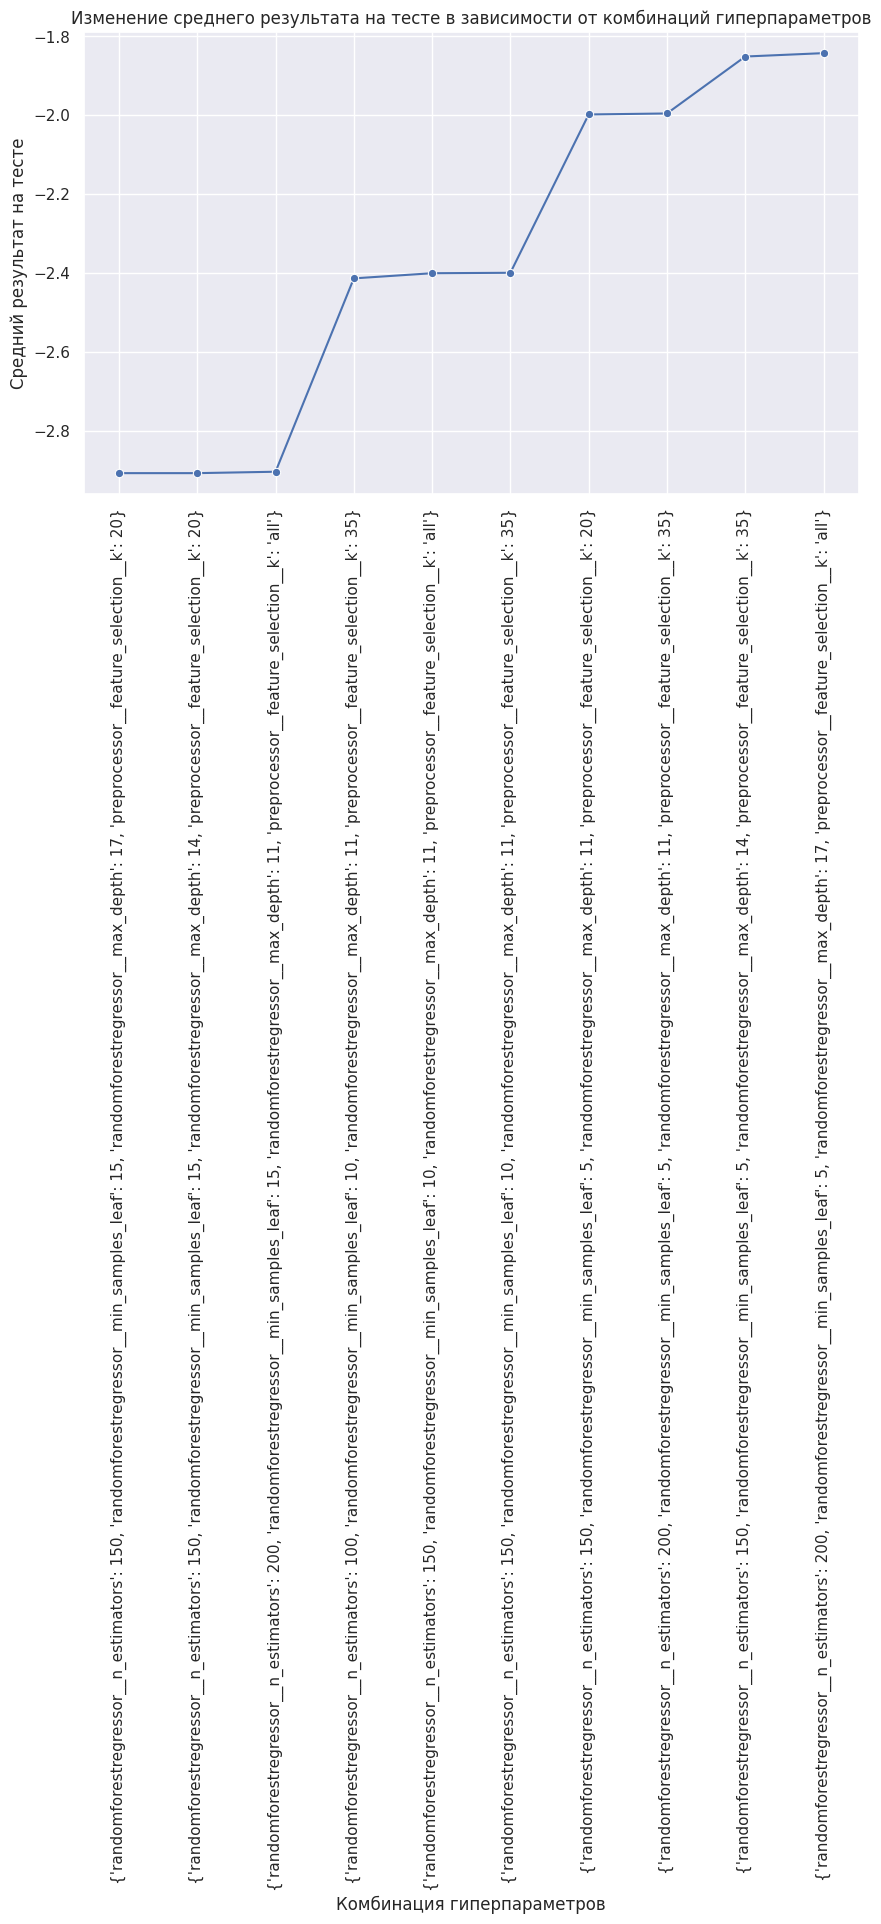

In [31]:
results = rand_search.cv_results_

# Параметры и оценки метрики
params = results['params']
mean_scores = results['mean_test_score']

results_df = pd.DataFrame({
    'Hyperparameters': [str(param) for param in params],
    'Mean Test Score': mean_scores
    }).sort_values(by='Mean Test Score')

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='Hyperparameters', y='Mean Test Score', marker='o', linestyle='-')

plt.xlabel('Комбинация гиперпараметров')
plt.ylabel('Средний результат на тесте')
plt.title('Изменение среднего результата на тесте в зависимости от комбинаций гиперпараметров')

plt.xticks(rotation=90)
plt.grid(True)
plt.show()


### 6.5. Стэкинг моделей

Реализация концепции стекинга моделей, объединяющая несколько базовых регрессоров для предсказания целевой переменной.

Используются базовые модели: LinearRegression, DecisionTreeRegressor и GradientBoostingRegressor с предварительно настроенными гиперпараметрами.

С помощью класса StackingRegressor позволяет комбинировать базовые модели с финальным регрессором.
В качестве финального регрессора выбран RandomForestRegressor, который автоматически подбирает оптимальные значения гиперпараметров с использованием перекрестной проверки.

In [33]:
X = X_full #.sample(frac=0.3,random_state=77)
y = y_full[X.index]
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=77)

# Список базовых моделей
base_estimators = [
    ('lr', LinearRegression()),
    ('dt', DecisionTreeRegressor(max_depth = 15, min_samples_leaf = 10, random_state = 77)),
    ('gb', GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=15, min_samples_split=20, random_state=77))
]

# {'randomforestregressor__n_estimators': 100, 'randomforestregressor__min_samples_leaf': 5,
#  'randomforestregressor__max_depth': 17, 'preprocessor__feature_selection__k': 20}

# Стекинг регрессор с RandomForestRegressor в качестве финального регрессора
stack_reg = StackingRegressor(
    estimators=base_estimators,
    final_estimator = RandomForestRegressor(n_estimators=100, max_depth=17, min_samples_leaf=5, warm_start=True, random_state=77),
    cv=2,
    n_jobs=-1,
    verbose=1
)

%time stack_reg.fit(X_tr, y_tr)

my_lib.show_metrics_boxcox(y_tr, stack_reg.predict(X_tr), y_te, stack_reg.predict(X_te), lambda_box_cox)

# MAE -  train:             1038.875
# MAPE - train:                4.770
# RMSE - train:             1999.613
# R_2 -  train:                1.000

# MAE -  test:             2320.826
# MAPE - test:                0.883
# RMSE - test:             4111.484
# R_2  - test:                1.000

# CPU times: user 36.4 s, sys: 700 ms, total: 37.1 s
# Wall time: 4min 25s
# MAE -  train:              480.656
# MAPE - train:                1.220
# RMSE - train:             1222.791
# R_2 -  train:                1.000

# MAE -  test:             1134.191
# MAPE - test:                1.540
# RMSE - test:             3210.309
# R_2  - test:                1.000

CPU times: user 36.4 s, sys: 700 ms, total: 37.1 s
Wall time: 4min 25s
MAE -  train:              480.656
MAPE - train:                1.220
RMSE - train:             1222.791
R_2 -  train:                1.000

MAE -  test:             1134.191
MAPE - test:                1.540
RMSE - test:             3210.309
R_2  - test:                1.000


- Качество модели со стекингом повысилась по сравнению со случайным перебором гиперпараметров RandomizedSearchCV с моделью RandomForestRegressor.

### 6.6. XGBoost и Optuna

In [14]:
X_trainval, X_valid, y_trainval, y_valid = train_test_split(X_train, y_train, shuffle=True,  random_state=77)

# data = df_encoded.sample(frac=0.2,random_state=55)
# X_tr, X_te, y_tr, y_te = train_test_split(data.drop('target', axis=1), data['target'], test_size=0.25, random_state=55)
# X_trainval, X_valid, y_trainval, y_valid = train_test_split(X_tr, y_tr, shuffle=True,  random_state=77)

In [15]:
def objective(trial):
    param = {
        # 'tree_method': 'gpu_hist', # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'eta': trial.suggest_categorical('eta', [0.3, 0.5, 0.7, 1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.015, 0.02]),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.6, 0.7, 0.8, 0.9]),
        'n_estimators': trial.suggest_int('n_estimators', 400, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 8, 600),
        'max_depth': trial.suggest_categorical('max_depth', [3, 5, 7]),
        'subsample': trial.suggest_categorical('subsample', [0.5, 0.6, 0.7, 0.8]),
        'random_state': 77
    }

    model = XGBRegressor(**param)
    model.fit(X_trainval, y_trainval, eval_set=[(X_valid, y_valid)], early_stopping_rounds=10, verbose=False)
    predict = model.predict(X_valid)
    y_val, y_pred = my_lib.inverse_boxcox_transform(y_valid, predict, lambda_box_cox)
    return mean_absolute_error(y_val, y_pred)

metric = 'MAE'
direction = 'minimize'
study = optuna.create_study(direction=direction)

study.optimize(objective, n_trials=20, timeout=600 )

print(f"Количество завершенных испытаний: {len(study.trials)}")
print("Лучшее испытание:")
trial = study.best_trial

print(f"  Значение: {trial.value}")

print("  Параметры: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Количество завершенных испытаний: 7
# Лучшее испытание:
#   Значение: 3206.037800820243
#   Параметры:
#     lambda: 0.03052848562658944
#     alpha: 0.0006417409978973063
#     eta: 0.7
#     learning_rate: 0.015
#     colsample_bytree: 0.9
#     n_estimators: 804
#     min_child_weight: 287
#     max_depth: 7
#     subsample: 0.8
# Mini Encoding
# Количество завершенных испытаний: 20
# Лучшее испытание:
#   Значение: 3952.1878433800202
#   Параметры: 
#     lambda: 0.031495058542363744
#     alpha: 1.0180911031218614e-06
#     eta: 0.7
#     learning_rate: 0.02
#     colsample_bytree: 0.8
#     n_estimators: 812
#     min_child_weight: 262
#     max_depth: 5
#     subsample: 0.8


[I 2024-05-02 10:02:56,263] A new study created in memory with name: no-name-df5b3090-4cfc-456e-912c-b1172bb46722
[I 2024-05-02 10:03:15,305] Trial 0 finished with value: 20827.808326240036 and parameters: {'lambda': 2.9082613805077177e-08, 'alpha': 2.681270410454213e-06, 'eta': 1.0, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_estimators': 504, 'min_child_weight': 441, 'max_depth': 3, 'subsample': 0.7}. Best is trial 0 with value: 20827.808326240036.
[I 2024-05-02 10:03:39,073] Trial 1 finished with value: 6897.123810260775 and parameters: {'lambda': 0.0010254558936861672, 'alpha': 3.2676570296090426e-05, 'eta': 1.0, 'learning_rate': 0.015, 'colsample_bytree': 0.6, 'n_estimators': 573, 'min_child_weight': 76, 'max_depth': 7, 'subsample': 0.6}. Best is trial 1 with value: 6897.123810260775.
[I 2024-05-02 10:04:49,995] Trial 2 finished with value: 5751.949237793082 and parameters: {'lambda': 1.0319934641865098e-07, 'alpha': 1.1529664935958817e-05, 'eta': 0.5, 'learning_rate': 0.01

Количество завершенных испытаний: 20
Лучшее испытание:
  Значение: 3952.1878433800202
  Параметры: 
    lambda: 0.031495058542363744
    alpha: 1.0180911031218614e-06
    eta: 0.7
    learning_rate: 0.02
    colsample_bytree: 0.8
    n_estimators: 812
    min_child_weight: 262
    max_depth: 5
    subsample: 0.8


In [ ]:
fig = optuna.visualization.plot_optimization_history(study, target_name='MAE')
fig.update_layout(title='<b>История оптимизаций.', title_x=0.5) # template='plotly_dark',


![](img/optimization_history.png)

In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.update_layout(title='<b>Важность гиперпараметров.', title_x=0.5)

![](img/param_importances.png)

![](/img/param_importances.png)

In [46]:
# Создание пайплайна для модели с обратным преобразованием целевой переменной
pipeline_with_target_transform = TransformedTargetRegressor(
    regressor=XGBRegressor(**study.best_params),  # ваша модель
    transformer=PowerTransformer(method="box-cox", standardize=False)  # преобразование для целевой переменной
)

X, y = X_full, df.target
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=77)

# Обучение пайплайна
pipeline_with_target_transform.fit(X_tr, y_tr)

# Предсказание с использованием пайплайна
y_tr_pred = pipeline_with_target_transform.predict(X_tr)
y_te_pred = pipeline_with_target_transform.predict(X_te)

print(f'Результаты лучшей модели:')
metric_function = mean_absolute_error
score_train = metric_function(y_tr, y_tr_pred).round(3)
score_test = metric_function(y_te, y_te_pred).round(3)

width = 20
print(f'{metric} -  train: {score_train:>{width}.3f}')
print(f'{metric}  - test: {score_test:>{width}.3f}')



Результаты лучшей модели:
MAE -  train:             3743.547
MAE  - test:             3856.526


In [48]:
# Cериализация модели в файл формата pkl
with open(PICKLE_DIR+'model_with_target_transform.pkl', 'wb') as output:
    pickle.dump(pipeline_with_target_transform, output)

In [47]:
best_model = XGBRegressor(**study.best_params)
best_model.fit(X_train, y_train)

print(f'Результаты лучшей модели:')
_,_ = my_lib.metric_mae_boxcox(y_train, best_model.predict(X_train), y_test, best_model.predict(X_test), lambda_box_cox)
# Результаты лучшей модели:
# MAE -  train:             2675.710
# MAE  - test:             2767.548

# Результаты лучшей модели:
# MAE -  train:             3966.029
# MAE  - test:             4151.274


Результаты лучшей модели:
MAE -  train:             3733.183
MAE  - test:             3837.836


Text(0, 0.5, 'Признаки')

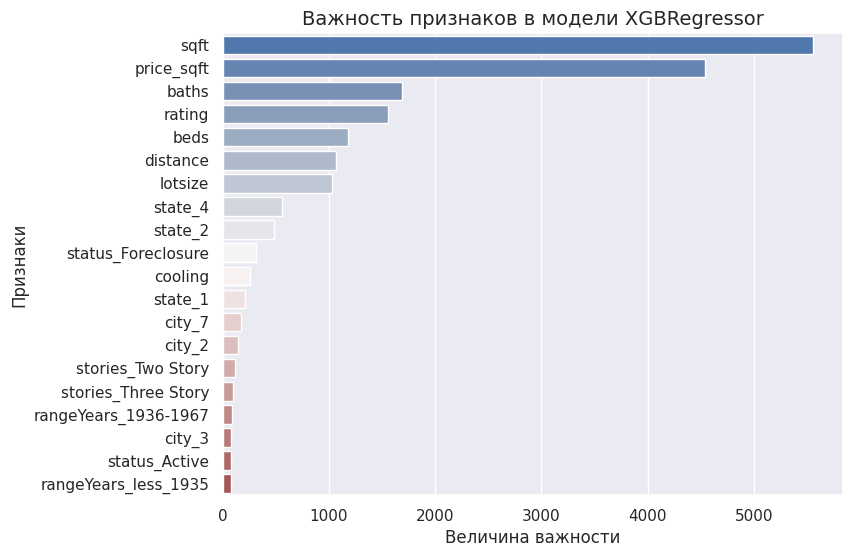

In [49]:
best_features = pd.Series(best_model.get_booster().get_score(importance_type='weight'),
                          index=X_train.columns).sort_values(ascending=False)

barplot = sns.barplot(
    data=best_features.to_frame(name='importance').reset_index()[:20],
    x='importance',
    y='index',
    orient='h',
    palette='vlag'
)
barplot.set_title('Важность признаков в модели XGBRegressor', fontsize=14)
barplot.set_xlabel('Величина важности')
barplot.set_ylabel('Признаки')


- Площадь недвижимости играет важную роль в цене.

In [50]:
best_feat_list = best_features.index[:20].to_list()
print(best_feat_list)
X_full[sorted(best_feat_list)].sample(3)

['sqft', 'price_sqft', 'baths', 'rating', 'beds', 'distance', 'lotsize', 'state_4', 'state_2', 'status_Foreclosure', 'cooling', 'state_1', 'city_7', 'city_2', 'stories_Two Story', 'stories_Three Story', 'rangeYears_1936-1967', 'city_3', 'status_Active', 'rangeYears_less_1935']


,baths,beds,city_2,city_3,city_7,cooling,distance,lotsize,price_sqft,rangeYears_1936-1967,rangeYears_less_1935,rating,sqft,state_1,state_2,state_4,status_Active,status_Foreclosure,stories_Three Story,stories_Two Story
76808,1,3,0,0,0,1,0.779325,14810.4,108.0,1,0,5.33,1660.0,0,0,0,1,0,0,0
5955,2,3,1,0,1,1,1.147402,12197.0,108.0,0,0,3.00,1570.0,1,0,0,1,0,0,0
11034,2,4,0,0,0,0,0.683097,18730.8,153.0,0,0,6.00,1800.0,1,1,0,1,0,0,0


## 7. Модель к продакшену.

In [51]:
# Cериализация модели в файл формата pkl
with open(PICKLE_DIR+'best_model.pkl', 'wb') as output:
    pickle.dump(best_model, output)

In [52]:
print(X_full.columns.to_list())

['status_Active', 'status_Other', 'status_Pending', 'status_New', 'status_Foreclosure', 'propertyType_Single-family', 'propertyType_Townhouse', 'propertyType_Condominium', 'propertyType_Land', 'stories_Two Story', 'stories_Single Story', 'stories_Basement', 'stories_Mid Rise', 'stories_None Story', 'stories_Three Story', 'stories_Low Rise', 'stories_High Rise', 'rangeYears_2019-2024', 'rangeYears_1968-1997', 'rangeYears_2011-2017', 'rangeYears_1936-1967', 'rangeYears_1998-2008', 'rangeYears_less_1935', 'state_0', 'state_1', 'state_2', 'state_3', 'state_4', 'city_0', 'city_1', 'city_2', 'city_3', 'city_4', 'city_5', 'city_6', 'city_7', 'city_8', 'beds', 'baths', 'sqft', 'lotsize', 'price_sqft', 'rating', 'distance', 'private_pool', 'cooling', 'garage']


In [56]:
# Возьмем временно одну выборку для продакшена
test_data = X_train.sample(random_state=77) #.round(3).values.tolist()[0]
ind = test_data.index
test_data = test_data.round(3).values.tolist()[0]
Y = df.target.loc[ind].values
print('Тестовый набор:')
print(test_data)
print('Target =', Y)

test_data = np.array(test_data).reshape(1, -1)

# Выполняем предсказание с помощью обученной модели
prediction = best_model.predict(test_data).reshape(-1, 1)
pred_trans =  pow_trans_bx.inverse_transform(prediction).round(0).astype(int)

print('Предсказание:', pred_trans[0])
# Тестовый набор:
# [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 3.0, 2.0, 1682.0, 1682.0, 184.0, 5.2, 1.834, 0.0, 1.0, 0.0]
# Target = [309900]
# Предсказание: [304871]

Тестовый набор:
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 3.0, 2.0, 1682.0, 1682.0, 184.0, 5.2, 1.834, 0.0, 1.0, 0.0]
Target = [309900]
Предсказание: [304871]


In [14]:
# Тестовый набор:
#['status_Active', 'status_Other', 'status_Pending', 'status_New', 'status_Foreclosure',
# 'propertyType_Single-family', 'propertyType_Townhouse', 'propertyType_Condominium', 'propertyType_Land',
# 'stories_Two Story', 'stories_Single Story', 'stories_Basement', 'stories_Mid Rise', 'stories_None Story', 'stories_Three Story', 'stories_Low Rise', 'stories_High Rise',
# 'rangeYears_2019-2024', 'rangeYears_1968-1997', 'rangeYears_2011-2017', 'rangeYears_1936-1967', 'rangeYears_1998-2008', 'rangeYears_less_1935',
# 'state_0', 'state_1', 'state_2', 'state_3', 'state_4', 'city_0', 'city_1', 'city_2', 'city_3', 'city_4', 'city_5', 'city_6', 'city_7', 'city_8',
# 'beds', 'baths', 'sqft', 'lotsize', 'price_sqft', 'rating', 'distance', 'private_pool', 'cooling', 'garage']

# data_test = [[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 3.0, 2.0, 1856.0, 3920.0, 62.0, 2.67, 0.548, 0.0, 0.0, 0.0]]
data_test = [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 3.0, 2.0, 1682.0, 1682.0, 184.0, 5.2, 1.834, 0.0, 1.0, 1.0]]
# Десериализуем модель из файла
with open(DATA_DIR+'best_model.pkl', 'rb') as pkl_file:
    model_pkl = pickle.load(pkl_file)

# Десериализуем трансформер из файла
with open(DATA_DIR+'transformer_box_cox.pkl', 'rb') as pkl_file:
    transformer = pickle.load(pkl_file)

# Формируем предсказание
pred = model_pkl.predict(data_test).reshape(-1,1)
pred_trans = transformer.inverse_transform(pred).round(0).astype(int)[0]
print(pred_trans)

# [121651]
# изменили последнее значение, который отвечает за наличие гаража
# Цена недвижимости без гаража сниженная.
# [121435]

[304905]


In [17]:
data_test = [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 3.0, 2.0, 1682.0, 1682.0, 184.0, 5.2, 1.834, 0.0, 1.0, 0.0]]
# Десериализуем модель из файла
with open(DATA_DIR+'model_with_target_transform.pkl', 'rb') as pkl_file:
    pipe_pkl = pickle.load(pkl_file)

# Формируем предсказание
pred = pipe_pkl.predict(data_test).reshape(-1,1).round(0).astype(int)[0]
print(pred)
# [305390] # Недвижимость с гаражом
# [305386] # Недвижимость без гаража


[310002]


- Взяли пробный тестовый набор, изменили признак "Гараж"(последнее значение) и провели предсказание. Цены с гаражом выше.


## Вывод.

Задача выполнена. Метрики модели вполне хорошие. Использовали очень хороший регрессор XGBoost.
Моделирование с полным кодированием категориальных признаков по методу OneHotEncoding показывала хорошие результаты. 

Недостатки:
- Нет использования классов Imputer
- Некоторые процессы можно автоматизировать с помощью пайплайна
- В продакшене можно создать полноценную страничку для тестирования прогнозирования цены на недвижимость